In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import os
import random
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
import tensorflow.keras as keras
import warnings
warnings.simplefilter("ignore")

%load_ext pycodestyle_magic
%pycodestyle_on --ignore E501

time: 1.88 s (started: 2022-07-26 16:20:17 +00:00)


# Prepare data

In [2]:
stock_price_df = pd.read_csv("../../stock08_price.csv")

universe = list(stock_price_df.columns.values[1:])
universe.remove("SP500")
# train data
portfolio_train = ['CELG', 'PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'CRM', 'NEM', 'JNPR', 'LB', 'CTAS', 'MAT', 'MDLZ', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'GRMN', 'CI', 'ZION', 'COO', 'TIF', 'RHT', 'FDX', 'LLL', 'GLW', 'GPN', 'IPGP', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'AAP', 'DAL', 'A', 'MON', 'BRK', 'BMY', 'KMB', 'JPM', 'CCI', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'UPS', 'WMB', 'IFF', 'CMS', 'ARNC', 'VIAB', 'MMC', 'REG', 'ES', 'ITW', 'NDAQ', 'AIZ', 'VRTX', 'CTL', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'EXR', 'VNO', 'BBT', 'WDC', 'UAL', 'PVH', 'NOC', 'PCAR', 'NSC', 'UAA', 'FFIV', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'CMG', 'ALK', 'ULTA', 'TMK', 'TAP', 'SCG', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'WU', 'ACN', 'HIG', 'TEL', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'ETFC', 'CMA', 'NRG', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'CBS', 'ALGN', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'XLNX', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG', 'FOX', 'MA']
# all data
portfolio_all = universe
# all data - train data
portfolio_other = [p for p in universe if p not in portfolio_train]
print(len(portfolio_train), len(portfolio_all), len(portfolio_other))
# paper evaluation set
paper_eva_info = {"paper_eva_1": {"portfolio": ['PRGO', 'MRO', 'ADP', 'HCP', 'FITB', 'PEG', 'SYMC', 'EOG', 'MDT', 'NI'], "file_name": "paper_eva_1_res"}, 
                  "paper_eva_2": {"portfolio": ['STI', 'COP', 'MCD', 'AON', 'JBHT', 'DISH', 'GS', 'LRCX', 'CTXS', 'LEG'], "file_name": "paper_eva_2_res"},
                  "paper_eva_3": {"portfolio": ['TJX', 'EMN', 'JCI', 'C', 'BIIB', 'HOG', 'PX', 'PH', 'XEC', 'JEC'], "file_name": "paper_eva_3_res"},
                  "paper_eva_4": {"portfolio": ['ROP', 'AZO', 'URI', 'TROW', 'CMCSA', 'SLB', 'VZ', 'MAC', 'ADS', 'MCK'], "file_name": "paper_eva_4_res"},
                  "paper_eva_5": {"portfolio": ['RL', 'CVX', 'SRE', 'PFE', 'PCG', 'UTX', 'NTRS', 'INCY', 'COP', 'HRL'], "file_name": "paper_eva_5_res"},}

#paper_eva_implement = "paper_eva_5"
#portfolio_implement = paper_eva_info[paper_eva_implement]['portfolio']
#output_file_name = paper_eva_info[paper_eva_implement]['file_name']
#fig_title = paper_eva_implement
paper_eva_implement = "295_other"
portfolio_implement = portfolio_other
output_file_name =  "295_res"
fig_title = paper_eva_implement


pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))
# display(stock_price_df)

6:80: E501 line too long (1073 > 79 characters)
13:80: E501 line too long (153 > 79 characters)
13:154: W291 trailing whitespace
14:80: E501 line too long (154 > 79 characters)
15:80: E501 line too long (148 > 79 characters)
16:80: E501 line too long (153 > 79 characters)
17:80: E501 line too long (153 > 79 characters)
17:152: E231 missing whitespace after ','
19:1: E265 block comment should start with '# '
20:1: E265 block comment should start with '# '
21:1: E265 block comment should start with '# '
22:1: E265 block comment should start with '# '
25:19: E222 multiple spaces after operator
30:80: E501 line too long (83 > 79 characters)


150 445 295
time: 109 ms (started: 2022-07-26 16:20:19 +00:00)


In [3]:
def gen_unseen_data_corr(portfolio: list, ret_date: bool = False) -> "pd.DataFrame, pd.Series | pd.DataFrame":
    tmp_corr = stock_price_df[portfolio[0]].rolling(window=100).corr(stock_price_df[portfolio[1]])
    tmp_corr = tmp_corr.iloc[99::100]
    corr_series = tmp_corr[3:24] # correspond to test2_dataset of original paper
    #corr_series = tmp_corr[:21] # correspond to train_dataset of original papaer 
    unseen_data_df = pd.DataFrame(corr_series).reset_index().drop(['Date'], axis=1).T
    if ret_date:
        return unseen_data_df, corr_series
    else:
        return unseen_data_df

1:80: E501 line too long (110 > 79 characters)
2:80: E501 line too long (98 > 79 characters)
4:33: E261 at least two spaces before inline comment
4:80: E501 line too long (80 > 79 characters)
5:5: E265 block comment should start with '# '
5:80: E501 line too long (81 > 79 characters)
5:82: W291 trailing whitespace
6:80: E501 line too long (85 > 79 characters)


time: 653 µs (started: 2022-07-26 16:20:19 +00:00)


In [4]:
unseen_data_df = gen_unseen_data_corr(['RL', 'CVX'])
unseen_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.301064,0.870396,0.895088,0.803884,0.763552,0.437946,0.671847,0.239142,0.703358,0.74433,...,0.396555,0.246283,0.103744,0.01833,0.188772,0.739464,-0.214199,0.285949,-0.352241,0.32908


time: 15.3 ms (started: 2022-07-26 16:20:20 +00:00)


# ARIMA model

In [5]:
def arima_model(dataset: "pd.DataFrame", portfolio: list, overview: bool = False) -> ("np.array", "pd.DataFrame", str):
    model_110 = ARIMA(order=(1, 1, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_011 = ARIMA(order=(0, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_111 = ARIMA(order=(1, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_211 = ARIMA(order=(2, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_210 = ARIMA(order=(2, 1, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    #model_330 = ARIMA(order=(3, 3, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)

    #model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210, "model_330": model_330}
    model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210}

    tested_models = []
    arima_model = None
    find_arima_model = False
    residual = []
    for s in np.array(dataset):
        while not find_arima_model:
            try:
                for model_key in model_dict:
                    if model_key not in tested_models:
                        test_model = model_dict[model_key].fit(s)
                        if arima_model is None:
                            arima_model = test_model
                            arima_model_name = model_key
                        elif arima_model.aic() <= test_model.aic():
                            pass
                        else:
                            arima_model = test_model
                            arima_model_name = model_key
                    tested_models.append(model_key)

            except Exception:
                if len(model_dict)-1 != 0:
                    del model_dict[model_key]
                else:
                    print(f"fatal error, {portfolio} doesn't have appropriate arima model")
                    break
            else:
                #model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210, "model_330": model_330}
                model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210}
                tested_models.clear()
                find_arima_model = True

        arima_pred = list(arima_model.predict_in_sample())
        arima_pred = [np.mean(arima_pred[1:])] + arima_pred[1:]
        arima_pred = np.clip(np.array(arima_pred), -1, 1)

        res = pd.Series(np.array(s) - arima_pred)
        residual.append(np.array(res)[:20])
        find_arima_model = False
    residual = pd.DataFrame(residual)

    if overview:
        plt.plot(arima_pred, label="arima_pred")
        plt.plot(dataset.T, label="data")
        plt.plot(res, label="res")
        plt.legend()
        plt.show()
        plt.close()

    return arima_pred, residual, arima_model_name

1:80: E501 line too long (119 > 79 characters)
2:80: E501 line too long (105 > 79 characters)
3:80: E501 line too long (105 > 79 characters)
4:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
6:80: E501 line too long (105 > 79 characters)
7:5: E265 block comment should start with '# '
7:80: E501 line too long (106 > 79 characters)
9:5: E265 block comment should start with '# '
9:80: E501 line too long (162 > 79 characters)
10:80: E501 line too long (137 > 79 characters)
36:80: E501 line too long (91 > 79 characters)
39:17: E265 block comment should start with '# '
39:80: E501 line too long (174 > 79 characters)
40:80: E501 line too long (149 > 79 characters)


time: 1.58 ms (started: 2022-07-26 16:20:20 +00:00)


# LSTM

In [6]:
class DoubleTanh(Activation):
    def __init__(self, activation, **kwargs):
        super(DoubleTanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'


def double_tanh(x):
    return (K.tanh(x) * 2)


get_custom_objects().update({'double_tanh': DoubleTanh(double_tanh)})

filepath = './stock_correlation_prediction/models/hybrid_LSTM_20220427/epoch262.h5'
#filepath = '../../models/hybrid_LSTM/epoch247.h5'
custom_objects = {"Double_Tanh": DoubleTanh}
with keras.utils.custom_object_scope(custom_objects):
    lstm_model = load_model(filepath)

2022-07-26 16:20:20.119657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 16:20:20.123720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 16:20:20.123921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-26 16:20:20.124600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

time: 846 ms (started: 2022-07-26 16:20:20 +00:00)


# Hybrid model

In [7]:
def stl_decompn(corr_series: "pd.Series", overview: bool = False) -> (float, float, float):
    output_resid = 100000
    output_trend = None
    output_period = None
    for p in range(2, 11):
        decompose_result_mult = seasonal_decompose(corr_series, period=p)
        resid_sum = np.abs(decompose_result_mult.resid).mean()
        if output_resid > resid_sum:
            output_resid = resid_sum
            output_trend = decompose_result_mult.trend.dropna()
            output_period = p
    
    reg = LinearRegression().fit(np.arange(len(output_trend)).reshape(-1, 1), output_trend)

    if overview:
        decompose_result_mult = seasonal_decompose(corr_series, period=output_period)
        trend = decompose_result_mult.trend.dropna().reset_index(drop=True)
        plt.figure(figsize=(7, 1))
        plt.plot(trend)
        plt.plot([0, len(trend)], [reg.intercept_, reg.intercept_+len(trend)*reg.coef_])
        plt.title("trend & regression line")
        plt.show()
        plt.close()
        decompose_result_mult.plot()
        plt.show()
        plt.close()

    return output_period, output_resid, output_trend.std(), reg.coef_[0]

1:80: E501 line too long (91 > 79 characters)
12:1: W293 blank line contains whitespace
13:80: E501 line too long (91 > 79 characters)
16:80: E501 line too long (85 > 79 characters)
20:80: E501 line too long (88 > 79 characters)


time: 944 µs (started: 2022-07-26 16:20:20 +00:00)


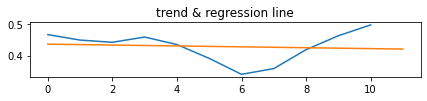

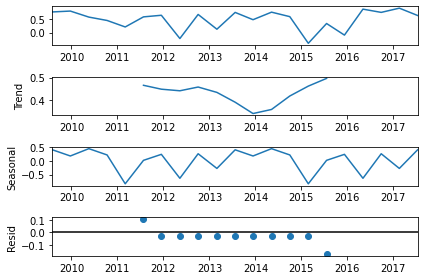

(10, 0.05197403038285887, 0.04734630191453318, -0.0013984760779681504)

1:80: E501 line too long (98 > 79 characters)


time: 369 ms (started: 2022-07-26 16:20:21 +00:00)


In [8]:
unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr(['CNP', 'RSG'], ret_date=True)
stl_decompn(unseen_data_corr_series, overview=True)

In [ ]:
res_list = []
unseen_data_corr_df_concat = pd.DataFrame(columns=list(range(21))+['portfolio'])
unseen_data_arima_resid_concat = pd.DataFrame(columns=list(range(20))+['portfolio'])
count = 0
for portfolio in tqdm(combinations(portfolio_implement, 2)):
    # unseen_data_corr = gen_unseen_data_corr(portfolio)
    unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr(portfolio, ret_date=True)
    arima_pred, residual, arima_model_name = arima_model(unseen_data_corr_df, portfolio)
    unseen_res = residual.values.reshape((-1, 20, 1))
    lstm_pred = lstm_model.predict(unseen_res)
    season_period, stl_resid, stl_trend_std, coef_reg_trend = stl_decompn(unseen_data_corr_series)
    portfolio_res_dic = {"portfolio": f"{portfolio[0]} & {portfolio[1]}",
                         "corr_ser_mean": unseen_data_corr_series.mean(),
                         "corr_ser_std": unseen_data_corr_series.std(),
                         "corr_season_period": season_period,
                         "corr_stl_resid": stl_resid,
                         "corr_stl_trend_std": stl_trend_std,
                         "corr_trend_coef": coef_reg_trend,
                         "arima_model": arima_model_name,
                         "lstm_pred": lstm_pred[0][0],
                         "arima_pred": arima_pred[-1],
                         "hybrid_model_pred": arima_pred[-1]+lstm_pred[0][0],
                         "ground_truth": unseen_data_corr_df.iloc[0, -1],
                         "arima_err": unseen_data_corr_df.iloc[0, -1] - arima_pred[-1],
                         "lstm_compen_err": arima_pred[-1] - lstm_pred[0][0],
                         "error": (unseen_data_corr_df.iloc[0, -1] - (arima_pred[-1]+lstm_pred[0][0])),
                         "absolute_err": math.copysign((unseen_data_corr_df.iloc[0, -1] - (arima_pred[-1]+lstm_pred[0][0])), 1), 
                         "lstm_compensation_dir": np.sign(unseen_data_corr_df.iloc[0, -1] - arima_pred[-1])*np.sign(lstm_pred[0][0])}

    res_list.append(portfolio_res_dic)
    unseen_data_corr_df['portfolio'] = f"{portfolio[0]} & {portfolio[1]}"
    unseen_data_corr_df_concat = pd.concat([unseen_data_corr_df_concat, unseen_data_corr_df]) 
    residual['portfolio'] = f"{portfolio[0]} & {portfolio[1]}"
    unseen_data_arima_resid_concat = pd.concat([unseen_data_arima_resid_concat, residual]) 
    #count = count + 1
    #if count > 10:
    #    break

0it [00:00, ?it/s]2022-07-26 16:20:22.254402: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 1s 1s/step


1it [00:01,  1.28s/it]

1/1 [==============================] - 0s 10ms/step


2it [00:01,  1.56it/s]

1/1 [==============================] - 0s 9ms/step


3it [00:01,  2.26it/s]

1/1 [==============================] - 0s 10ms/step


4it [00:01,  2.79it/s]

1/1 [==============================] - 0s 10ms/step


5it [00:02,  3.40it/s]

1/1 [==============================] - 0s 9ms/step


6it [00:02,  3.98it/s]

1/1 [==============================] - 0s 9ms/step


7it [00:02,  4.35it/s]

1/1 [==============================] - 0s 9ms/step


8it [00:02,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


9it [00:02,  5.05it/s]

1/1 [==============================] - 0s 9ms/step


10it [00:02,  5.60it/s]

1/1 [==============================] - 0s 10ms/step


11it [00:03,  5.05it/s]

1/1 [==============================] - 0s 9ms/step


12it [00:03,  5.68it/s]

1/1 [==============================] - 0s 10ms/step


13it [00:03,  5.53it/s]

1/1 [==============================] - 0s 10ms/step


14it [00:03,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


15it [00:03,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


16it [00:04,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


17it [00:04,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


18it [00:04,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


19it [00:04,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


20it [00:04,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


21it [00:05,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


22it [00:05,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


23it [00:05,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


24it [00:05,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


25it [00:05,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


26it [00:06,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


27it [00:06,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


28it [00:06,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


29it [00:06,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


30it [00:07,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


31it [00:07,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


32it [00:07,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


33it [00:07,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


34it [00:07,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


35it [00:07,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


36it [00:08,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


37it [00:08,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


38it [00:08,  5.00it/s]

1/1 [==============================] - 0s 11ms/step


39it [00:08,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


40it [00:08,  5.85it/s]

1/1 [==============================] - 0s 9ms/step


41it [00:09,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


42it [00:09,  5.22it/s]

1/1 [==============================] - 0s 9ms/step


43it [00:09,  5.28it/s]

1/1 [==============================] - 0s 9ms/step


44it [00:09,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


45it [00:09,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


46it [00:09,  5.63it/s]

1/1 [==============================] - 0s 10ms/step


47it [00:10,  5.30it/s]

1/1 [==============================] - 0s 9ms/step


48it [00:10,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


49it [00:10,  5.55it/s]

1/1 [==============================] - 0s 10ms/step


50it [00:10,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


51it [00:10,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


52it [00:11,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


53it [00:11,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


54it [00:11,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


55it [00:11,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


56it [00:11,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


57it [00:12,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


58it [00:12,  5.14it/s]

1/1 [==============================] - 0s 9ms/step


59it [00:12,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


60it [00:12,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


61it [00:12,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


62it [00:13,  5.52it/s]

1/1 [==============================] - 0s 10ms/step


63it [00:13,  5.07it/s]

1/1 [==============================] - 0s 11ms/step


64it [00:13,  4.25it/s]

1/1 [==============================] - 0s 10ms/step


65it [00:13,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


66it [00:13,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


67it [00:14,  5.64it/s]

1/1 [==============================] - 0s 10ms/step


68it [00:14,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


69it [00:14,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


70it [00:14,  4.96it/s]

1/1 [==============================] - 0s 11ms/step


71it [00:14,  5.25it/s]

1/1 [==============================] - 0s 13ms/step


72it [00:15,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


73it [00:15,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


74it [00:15,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


75it [00:15,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


76it [00:15,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


77it [00:16,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


78it [00:16,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


79it [00:16,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


80it [00:16,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


81it [00:16,  4.97it/s]

1/1 [==============================] - 0s 11ms/step


82it [00:17,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


83it [00:17,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


84it [00:17,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


85it [00:17,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


86it [00:17,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


87it [00:18,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


88it [00:18,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


89it [00:18,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


90it [00:18,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


91it [00:18,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


92it [00:19,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


93it [00:19,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


94it [00:19,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


95it [00:19,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


96it [00:19,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


97it [00:20,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


98it [00:20,  4.83it/s]

1/1 [==============================] - 0s 13ms/step


99it [00:20,  4.71it/s]

1/1 [==============================] - 0s 11ms/step


100it [00:20,  5.05it/s]

1/1 [==============================] - 0s 11ms/step


101it [00:20,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


102it [00:21,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


103it [00:21,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


104it [00:21,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


105it [00:21,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


106it [00:21,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


107it [00:22,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


108it [00:22,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


109it [00:22,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


110it [00:22,  4.81it/s]

1/1 [==============================] - 0s 9ms/step


111it [00:22,  4.80it/s]

1/1 [==============================] - 0s 9ms/step


112it [00:23,  4.48it/s]

1/1 [==============================] - 0s 9ms/step


113it [00:23,  4.55it/s]

1/1 [==============================] - 0s 11ms/step


114it [00:23,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


115it [00:23,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


116it [00:24,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


117it [00:24,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


118it [00:24,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


119it [00:24,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


120it [00:24,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


121it [00:24,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


122it [00:25,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


123it [00:25,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


124it [00:25,  5.55it/s]

1/1 [==============================] - 0s 10ms/step


125it [00:25,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


126it [00:25,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


127it [00:26,  4.48it/s]

1/1 [==============================] - 0s 13ms/step


128it [00:26,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


129it [00:26,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


130it [00:26,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


131it [00:27,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


132it [00:27,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


133it [00:27,  5.34it/s]

1/1 [==============================] - 0s 9ms/step


134it [00:27,  5.85it/s]

1/1 [==============================] - 0s 9ms/step


135it [00:27,  6.21it/s]

1/1 [==============================] - 0s 10ms/step


136it [00:27,  5.74it/s]

1/1 [==============================] - 0s 10ms/step


137it [00:28,  5.86it/s]

1/1 [==============================] - 0s 10ms/step


138it [00:28,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


139it [00:28,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


140it [00:28,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


141it [00:28,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


142it [00:28,  5.53it/s]

1/1 [==============================] - 0s 10ms/step


143it [00:29,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


144it [00:29,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


145it [00:29,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


146it [00:29,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


147it [00:30,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


148it [00:30,  5.50it/s]

1/1 [==============================] - 0s 9ms/step


149it [00:30,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


150it [00:30,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


151it [00:30,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


152it [00:30,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


153it [00:31,  4.89it/s]

1/1 [==============================] - 0s 11ms/step


154it [00:31,  5.04it/s]

1/1 [==============================] - 0s 11ms/step


155it [00:31,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


156it [00:31,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


157it [00:31,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


158it [00:32,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


159it [00:32,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


160it [00:32,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


161it [00:32,  4.66it/s]

1/1 [==============================] - 0s 9ms/step


162it [00:33,  4.78it/s]

1/1 [==============================] - 0s 9ms/step


163it [00:33,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


164it [00:33,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


165it [00:33,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


166it [00:33,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


167it [00:34,  3.91it/s]

1/1 [==============================] - 0s 11ms/step


168it [00:34,  4.23it/s]

1/1 [==============================] - 0s 11ms/step


169it [00:34,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


170it [00:34,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


171it [00:34,  4.89it/s]

1/1 [==============================] - 0s 9ms/step


172it [00:35,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


173it [00:35,  4.78it/s]

1/1 [==============================] - 0s 9ms/step


174it [00:35,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


175it [00:35,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


176it [00:35,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


177it [00:36,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


178it [00:36,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


179it [00:36,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


180it [00:36,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


181it [00:36,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


182it [00:37,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


183it [00:37,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


184it [00:37,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


185it [00:37,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


186it [00:37,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


187it [00:38,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


188it [00:38,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


189it [00:38,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


190it [00:38,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


191it [00:39,  4.62it/s]

1/1 [==============================] - 0s 11ms/step


192it [00:39,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


193it [00:39,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


194it [00:39,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


195it [00:39,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


196it [00:39,  5.49it/s]

1/1 [==============================] - 0s 10ms/step


197it [00:40,  5.21it/s]

1/1 [==============================] - 0s 9ms/step


198it [00:40,  4.87it/s]

1/1 [==============================] - 0s 9ms/step


199it [00:40,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


200it [00:40,  4.75it/s]

1/1 [==============================] - 0s 9ms/step


201it [00:41,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


202it [00:41,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


203it [00:41,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


204it [00:41,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


205it [00:41,  4.82it/s]

1/1 [==============================] - 0s 9ms/step


206it [00:42,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


207it [00:42,  5.16it/s]

1/1 [==============================] - 0s 9ms/step


208it [00:42,  5.49it/s]

1/1 [==============================] - 0s 9ms/step


209it [00:42,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


210it [00:42,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


211it [00:42,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


212it [00:43,  5.53it/s]

1/1 [==============================] - 0s 10ms/step


213it [00:43,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


214it [00:43,  5.31it/s]

1/1 [==============================] - 0s 9ms/step


215it [00:43,  5.28it/s]

1/1 [==============================] - 0s 9ms/step


216it [00:43,  5.70it/s]

1/1 [==============================] - 0s 11ms/step


217it [00:44,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


218it [00:44,  4.47it/s]

1/1 [==============================] - 0s 11ms/step


219it [00:44,  5.02it/s]

1/1 [==============================] - 0s 11ms/step


220it [00:44,  5.56it/s]

1/1 [==============================] - 0s 11ms/step


221it [00:44,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


222it [00:45,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


223it [00:45,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


224it [00:45,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


225it [00:45,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


226it [00:45,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


227it [00:46,  5.44it/s]

1/1 [==============================] - 0s 9ms/step


228it [00:46,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


229it [00:46,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


230it [00:46,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


231it [00:46,  5.53it/s]

1/1 [==============================] - 0s 10ms/step


232it [00:46,  5.73it/s]

1/1 [==============================] - 0s 10ms/step


233it [00:47,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


234it [00:47,  4.90it/s]

1/1 [==============================] - 0s 9ms/step


235it [00:47,  5.07it/s]

1/1 [==============================] - 0s 9ms/step


236it [00:47,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


237it [00:47,  5.62it/s]

1/1 [==============================] - 0s 10ms/step


238it [00:48,  5.95it/s]

1/1 [==============================] - 0s 9ms/step


239it [00:48,  5.49it/s]

1/1 [==============================] - 0s 9ms/step


240it [00:48,  5.14it/s]

1/1 [==============================] - 0s 9ms/step


241it [00:48,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


242it [00:48,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


243it [00:49,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


244it [00:49,  4.89it/s]

1/1 [==============================] - 0s 9ms/step


245it [00:49,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


246it [00:49,  5.16it/s]

1/1 [==============================] - 0s 9ms/step


247it [00:49,  4.92it/s]

1/1 [==============================] - 0s 9ms/step


248it [00:50,  4.70it/s]

1/1 [==============================] - 0s 9ms/step


249it [00:50,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


250it [00:50,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


251it [00:50,  4.69it/s]

1/1 [==============================] - 0s 9ms/step


252it [00:50,  4.62it/s]

1/1 [==============================] - 0s 9ms/step


253it [00:51,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


254it [00:51,  5.09it/s]

1/1 [==============================] - 0s 9ms/step


255it [00:51,  4.73it/s]

1/1 [==============================] - 0s 9ms/step


256it [00:51,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


257it [00:51,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


258it [00:52,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


259it [00:52,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


260it [00:52,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


261it [00:52,  5.10it/s]

1/1 [==============================] - 0s 9ms/step


262it [00:52,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


263it [00:53,  5.41it/s]

1/1 [==============================] - 0s 9ms/step


264it [00:53,  5.53it/s]

1/1 [==============================] - 0s 9ms/step


265it [00:53,  5.45it/s]

1/1 [==============================] - 0s 9ms/step


266it [00:53,  5.25it/s]

1/1 [==============================] - 0s 11ms/step


267it [00:53,  4.23it/s]

1/1 [==============================] - 0s 10ms/step


268it [00:54,  4.21it/s]

1/1 [==============================] - 0s 10ms/step


269it [00:54,  4.20it/s]

1/1 [==============================] - 0s 10ms/step


270it [00:54,  4.32it/s]

1/1 [==============================] - 0s 10ms/step


271it [00:54,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


272it [00:55,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


273it [00:55,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


274it [00:55,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


275it [00:55,  4.85it/s]

1/1 [==============================] - 0s 9ms/step


276it [00:55,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


277it [00:55,  5.61it/s]

1/1 [==============================] - 0s 9ms/step


278it [00:56,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


279it [00:56,  4.95it/s]

1/1 [==============================] - 0s 9ms/step


280it [00:56,  5.08it/s]

1/1 [==============================] - 0s 9ms/step


281it [00:56,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


282it [00:56,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


283it [00:57,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


284it [00:57,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


285it [00:57,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


286it [00:57,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


287it [00:58,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


288it [00:58,  4.96it/s]

1/1 [==============================] - 0s 9ms/step


289it [00:58,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


290it [00:58,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


291it [00:58,  5.20it/s]

1/1 [==============================] - 0s 9ms/step


292it [00:58,  5.74it/s]

1/1 [==============================] - 0s 10ms/step


293it [00:59,  5.83it/s]

1/1 [==============================] - 0s 12ms/step


294it [00:59,  5.44it/s]

1/1 [==============================] - 0s 9ms/step


295it [00:59,  5.38it/s]

1/1 [==============================] - 0s 10ms/step


296it [00:59,  5.20it/s]

1/1 [==============================] - 0s 9ms/step


297it [00:59,  4.97it/s]

1/1 [==============================] - 0s 9ms/step


298it [01:00,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


299it [01:00,  4.70it/s]

1/1 [==============================] - 0s 9ms/step


300it [01:00,  4.52it/s]

1/1 [==============================] - 0s 9ms/step


301it [01:00,  4.51it/s]

1/1 [==============================] - 0s 9ms/step


302it [01:01,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


303it [01:01,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


304it [01:01,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


305it [01:01,  5.42it/s]

1/1 [==============================] - 0s 9ms/step


306it [01:01,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


307it [01:02,  4.84it/s]

1/1 [==============================] - 0s 9ms/step


308it [01:02,  5.12it/s]

1/1 [==============================] - 0s 13ms/step


309it [01:02,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


310it [01:02,  5.10it/s]

1/1 [==============================] - 0s 9ms/step


311it [01:02,  5.43it/s]

1/1 [==============================] - 0s 9ms/step


312it [01:02,  4.96it/s]

1/1 [==============================] - 0s 9ms/step


313it [01:03,  5.17it/s]

1/1 [==============================] - 0s 9ms/step


314it [01:03,  4.71it/s]

1/1 [==============================] - 0s 9ms/step


315it [01:03,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


316it [01:03,  4.82it/s]

1/1 [==============================] - 0s 9ms/step


317it [01:04,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


318it [01:04,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


319it [01:04,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


320it [01:04,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


321it [01:05,  3.93it/s]

1/1 [==============================] - 0s 10ms/step


322it [01:05,  4.21it/s]

1/1 [==============================] - 0s 10ms/step


323it [01:05,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


324it [01:05,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


325it [01:05,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


326it [01:06,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


327it [01:06,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


328it [01:06,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


329it [01:06,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


330it [01:06,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


331it [01:07,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


332it [01:07,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


333it [01:07,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


334it [01:07,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


335it [01:07,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


336it [01:08,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


337it [01:08,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


338it [01:08,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


339it [01:08,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


340it [01:08,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


341it [01:09,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


342it [01:09,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


343it [01:09,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


344it [01:09,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


345it [01:09,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


346it [01:10,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


347it [01:10,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


348it [01:10,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


349it [01:10,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


350it [01:11,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


351it [01:11,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


352it [01:11,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


353it [01:11,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


354it [01:11,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


355it [01:11,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


356it [01:12,  6.14it/s]

1/1 [==============================] - 0s 10ms/step


357it [01:12,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


358it [01:12,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


359it [01:12,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


360it [01:12,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


361it [01:13,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


362it [01:13,  5.25it/s]

1/1 [==============================] - 0s 9ms/step


363it [01:13,  5.74it/s]

1/1 [==============================] - 0s 10ms/step


364it [01:13,  6.16it/s]

1/1 [==============================] - 0s 10ms/step


365it [01:13,  5.96it/s]

1/1 [==============================] - 0s 10ms/step


366it [01:13,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


367it [01:14,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


368it [01:14,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


369it [01:14,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


370it [01:14,  4.91it/s]

1/1 [==============================] - 0s 9ms/step


371it [01:15,  4.66it/s]

1/1 [==============================] - 0s 11ms/step


372it [01:15,  4.07it/s]

1/1 [==============================] - 0s 11ms/step


373it [01:15,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


374it [01:15,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


375it [01:15,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


376it [01:16,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


377it [01:16,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


378it [01:16,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


379it [01:16,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


380it [01:16,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


381it [01:17,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


382it [01:17,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


383it [01:17,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


384it [01:17,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


385it [01:18,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


386it [01:18,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


387it [01:18,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


388it [01:18,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


389it [01:18,  5.19it/s]

1/1 [==============================] - 0s 9ms/step


390it [01:19,  5.15it/s]

1/1 [==============================] - 0s 9ms/step


391it [01:19,  4.89it/s]

1/1 [==============================] - 0s 9ms/step


392it [01:19,  4.84it/s]

1/1 [==============================] - 0s 11ms/step


393it [01:19,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


394it [01:19,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


395it [01:20,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


396it [01:20,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


397it [01:20,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


398it [01:20,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


399it [01:20,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


400it [01:21,  4.52it/s]

1/1 [==============================] - 0s 16ms/step


401it [01:21,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


402it [01:21,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


403it [01:21,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


404it [01:21,  4.63it/s]

1/1 [==============================] - 0s 9ms/step


405it [01:22,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


406it [01:22,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


407it [01:22,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


408it [01:22,  4.87it/s]

1/1 [==============================] - 0s 9ms/step


409it [01:22,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


410it [01:23,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


411it [01:23,  4.78it/s]

1/1 [==============================] - 0s 9ms/step


412it [01:23,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


413it [01:23,  4.92it/s]

1/1 [==============================] - 0s 9ms/step


414it [01:23,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


415it [01:24,  4.90it/s]

1/1 [==============================] - 0s 9ms/step


416it [01:24,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


417it [01:24,  5.01it/s]

1/1 [==============================] - 0s 9ms/step


418it [01:24,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


419it [01:25,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


420it [01:25,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


421it [01:25,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


422it [01:25,  5.50it/s]

1/1 [==============================] - 0s 9ms/step


423it [01:25,  5.77it/s]

1/1 [==============================] - 0s 9ms/step


424it [01:25,  5.22it/s]

1/1 [==============================] - 0s 11ms/step


425it [01:26,  4.22it/s]

1/1 [==============================] - 0s 11ms/step


426it [01:26,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


427it [01:26,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


428it [01:26,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


429it [01:27,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


430it [01:27,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


431it [01:27,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


432it [01:27,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


433it [01:27,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


434it [01:28,  4.65it/s]

1/1 [==============================] - 0s 9ms/step


435it [01:28,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


436it [01:28,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


437it [01:28,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


438it [01:28,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


439it [01:29,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


440it [01:29,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


441it [01:29,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


442it [01:29,  5.63it/s]

1/1 [==============================] - 0s 10ms/step


443it [01:29,  5.35it/s]

1/1 [==============================] - 0s 9ms/step


444it [01:30,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


445it [01:30,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


446it [01:30,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


447it [01:30,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


448it [01:30,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


449it [01:31,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


450it [01:31,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


451it [01:31,  4.32it/s]

1/1 [==============================] - 0s 10ms/step


452it [01:31,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


453it [01:31,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


454it [01:32,  4.70it/s]

1/1 [==============================] - 0s 9ms/step


455it [01:32,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


456it [01:32,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


457it [01:32,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


458it [01:32,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


459it [01:33,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


460it [01:33,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


461it [01:33,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


462it [01:33,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


463it [01:34,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


464it [01:34,  4.66it/s]

1/1 [==============================] - 0s 9ms/step


465it [01:34,  4.62it/s]

1/1 [==============================] - 0s 9ms/step


466it [01:34,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


467it [01:35,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


468it [01:35,  4.31it/s]

1/1 [==============================] - 0s 10ms/step


469it [01:35,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


470it [01:35,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


471it [01:35,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


472it [01:36,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


473it [01:36,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


474it [01:36,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


475it [01:36,  4.66it/s]

1/1 [==============================] - 0s 11ms/step


476it [01:36,  4.12it/s]

1/1 [==============================] - 0s 10ms/step


477it [01:37,  4.33it/s]

1/1 [==============================] - 0s 10ms/step


478it [01:37,  4.41it/s]

1/1 [==============================] - 0s 11ms/step


479it [01:37,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


480it [01:37,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


481it [01:38,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


482it [01:38,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


483it [01:38,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


484it [01:38,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


485it [01:38,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


486it [01:39,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


487it [01:39,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


488it [01:39,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


489it [01:39,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


490it [01:39,  5.38it/s]

1/1 [==============================] - 0s 10ms/step


491it [01:39,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


492it [01:40,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


493it [01:40,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


494it [01:40,  5.60it/s]

1/1 [==============================] - 0s 10ms/step


495it [01:40,  5.35it/s]

1/1 [==============================] - 0s 9ms/step


496it [01:40,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


497it [01:41,  5.82it/s]

1/1 [==============================] - 0s 9ms/step


498it [01:41,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


499it [01:41,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


500it [01:41,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


501it [01:41,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


502it [01:42,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


503it [01:42,  4.84it/s]

1/1 [==============================] - 0s 9ms/step


504it [01:42,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


505it [01:42,  5.44it/s]

1/1 [==============================] - 0s 10ms/step


506it [01:42,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


507it [01:43,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


508it [01:43,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


509it [01:43,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


510it [01:43,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


511it [01:43,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


512it [01:44,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


513it [01:44,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


514it [01:44,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


515it [01:44,  4.76it/s]

1/1 [==============================] - 0s 9ms/step


516it [01:44,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


517it [01:45,  4.75it/s]

1/1 [==============================] - 0s 9ms/step


518it [01:45,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


519it [01:45,  4.52it/s]

1/1 [==============================] - 0s 9ms/step


520it [01:45,  4.60it/s]

1/1 [==============================] - 0s 11ms/step


521it [01:46,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


522it [01:46,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


523it [01:46,  4.76it/s]

1/1 [==============================] - 0s 9ms/step


524it [01:46,  4.64it/s]

1/1 [==============================] - 0s 9ms/step


525it [01:46,  5.00it/s]

1/1 [==============================] - 0s 9ms/step


526it [01:47,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


527it [01:47,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


528it [01:47,  4.06it/s]

1/1 [==============================] - 0s 10ms/step


529it [01:47,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


530it [01:48,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


531it [01:48,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


532it [01:48,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


533it [01:48,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


534it [01:48,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


535it [01:49,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


536it [01:49,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


537it [01:49,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


538it [01:49,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


539it [01:49,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


540it [01:49,  5.88it/s]

1/1 [==============================] - 0s 10ms/step


541it [01:50,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


542it [01:50,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


543it [01:50,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


544it [01:50,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


545it [01:50,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


546it [01:51,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


547it [01:51,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


548it [01:51,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


549it [01:51,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


550it [01:51,  4.94it/s]

1/1 [==============================] - 0s 9ms/step


551it [01:52,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


552it [01:52,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


553it [01:52,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


554it [01:52,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


555it [01:52,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


556it [01:53,  5.40it/s]

1/1 [==============================] - 0s 9ms/step


557it [01:53,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


558it [01:53,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


559it [01:53,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


560it [01:53,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


561it [01:54,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


562it [01:54,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


563it [01:54,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


564it [01:54,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


565it [01:54,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


566it [01:55,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


567it [01:55,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


568it [01:55,  5.62it/s]

1/1 [==============================] - 0s 10ms/step


569it [01:55,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


570it [01:55,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


571it [01:56,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


572it [01:56,  4.61it/s]

1/1 [==============================] - 0s 11ms/step


573it [01:56,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


574it [01:56,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


575it [01:57,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


576it [01:57,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


577it [01:57,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


578it [01:57,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


579it [01:57,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


580it [01:58,  4.46it/s]

1/1 [==============================] - 0s 11ms/step


581it [01:58,  3.88it/s]

1/1 [==============================] - 0s 10ms/step


582it [01:58,  4.28it/s]

1/1 [==============================] - 0s 10ms/step


583it [01:58,  4.27it/s]

1/1 [==============================] - 0s 10ms/step


584it [01:59,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


585it [01:59,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


586it [01:59,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


587it [01:59,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


588it [01:59,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


589it [01:59,  5.64it/s]

1/1 [==============================] - 0s 10ms/step


590it [02:00,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


591it [02:00,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


592it [02:00,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


593it [02:00,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


594it [02:01,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


595it [02:01,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


596it [02:01,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


597it [02:01,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


598it [02:01,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


599it [02:01,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


600it [02:02,  4.90it/s]

1/1 [==============================] - 0s 9ms/step


601it [02:02,  4.73it/s]

1/1 [==============================] - 0s 9ms/step


602it [02:02,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


603it [02:02,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


604it [02:03,  4.77it/s]

1/1 [==============================] - 0s 11ms/step


605it [02:03,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


606it [02:03,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


607it [02:03,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


608it [02:03,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


609it [02:04,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


610it [02:04,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


611it [02:04,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


612it [02:04,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


613it [02:04,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


614it [02:05,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


615it [02:05,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


616it [02:05,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


617it [02:05,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


618it [02:05,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


619it [02:06,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


620it [02:06,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


621it [02:06,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


622it [02:06,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


623it [02:06,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


624it [02:07,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


625it [02:07,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


626it [02:07,  5.05it/s]

1/1 [==============================] - 0s 9ms/step


627it [02:07,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


628it [02:07,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


629it [02:08,  4.58it/s]

1/1 [==============================] - 0s 9ms/step


630it [02:08,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


631it [02:08,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


632it [02:08,  4.03it/s]

1/1 [==============================] - 0s 10ms/step


633it [02:09,  4.22it/s]

1/1 [==============================] - 0s 11ms/step


634it [02:09,  4.28it/s]

1/1 [==============================] - 0s 11ms/step


635it [02:09,  4.32it/s]

1/1 [==============================] - 0s 10ms/step


636it [02:09,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


637it [02:10,  4.28it/s]

1/1 [==============================] - 0s 10ms/step


638it [02:10,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


639it [02:10,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


640it [02:10,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


641it [02:10,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


642it [02:10,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


643it [02:11,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


644it [02:11,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


645it [02:11,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


646it [02:11,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


647it [02:12,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


648it [02:12,  4.89it/s]

1/1 [==============================] - 0s 11ms/step


649it [02:12,  4.70it/s]

1/1 [==============================] - 0s 9ms/step


650it [02:12,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


651it [02:12,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


652it [02:13,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


653it [02:13,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


654it [02:13,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


655it [02:13,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


656it [02:13,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


657it [02:14,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


658it [02:14,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


659it [02:14,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


660it [02:14,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


661it [02:14,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


662it [02:15,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


663it [02:15,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


664it [02:15,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


665it [02:15,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


666it [02:15,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


667it [02:16,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


668it [02:16,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


669it [02:16,  4.69it/s]

1/1 [==============================] - 0s 11ms/step


670it [02:16,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


671it [02:17,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


672it [02:17,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


673it [02:17,  5.49it/s]

1/1 [==============================] - 0s 10ms/step


674it [02:17,  5.38it/s]

1/1 [==============================] - 0s 10ms/step


675it [02:17,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


676it [02:17,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


677it [02:18,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


678it [02:18,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


679it [02:18,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


680it [02:18,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


681it [02:19,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


682it [02:19,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


683it [02:19,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


684it [02:19,  4.42it/s]

1/1 [==============================] - 0s 11ms/step


685it [02:20,  3.88it/s]

1/1 [==============================] - 0s 11ms/step


686it [02:20,  4.22it/s]

1/1 [==============================] - 0s 11ms/step


687it [02:20,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


688it [02:20,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


689it [02:20,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


690it [02:21,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


691it [02:21,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


692it [02:21,  5.53it/s]

1/1 [==============================] - 0s 10ms/step


693it [02:21,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


694it [02:21,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


695it [02:22,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


696it [02:22,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


697it [02:22,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


698it [02:22,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


699it [02:22,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


700it [02:23,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


701it [02:23,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


702it [02:23,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


703it [02:23,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


704it [02:23,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


705it [02:24,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


706it [02:24,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


707it [02:24,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


708it [02:24,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


709it [02:24,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


710it [02:25,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


711it [02:25,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


712it [02:25,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


713it [02:25,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


714it [02:25,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


715it [02:26,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


716it [02:26,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


717it [02:26,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


718it [02:26,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


719it [02:26,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


720it [02:27,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


721it [02:27,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


722it [02:27,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


723it [02:27,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


724it [02:27,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


725it [02:28,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


726it [02:28,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


727it [02:28,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


728it [02:28,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


729it [02:28,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


730it [02:29,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


731it [02:29,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


732it [02:29,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


733it [02:29,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


734it [02:29,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


735it [02:30,  5.21it/s]

1/1 [==============================] - 0s 11ms/step


736it [02:30,  4.20it/s]

1/1 [==============================] - 0s 11ms/step


737it [02:30,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


738it [02:30,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


739it [02:31,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


740it [02:31,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


741it [02:31,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


742it [02:31,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


743it [02:31,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


744it [02:32,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


745it [02:32,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


746it [02:32,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


747it [02:32,  4.48it/s]

1/1 [==============================] - 0s 11ms/step


748it [02:32,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


749it [02:33,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


750it [02:33,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


751it [02:33,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


752it [02:33,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


753it [02:34,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


754it [02:34,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


755it [02:34,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


756it [02:34,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


757it [02:34,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


758it [02:35,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


759it [02:35,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


760it [02:35,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


761it [02:35,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


762it [02:35,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


763it [02:36,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


764it [02:36,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


765it [02:36,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


766it [02:36,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


767it [02:36,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


768it [02:37,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


769it [02:37,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


770it [02:37,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


771it [02:37,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


772it [02:37,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


773it [02:38,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


774it [02:38,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


775it [02:38,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


776it [02:38,  4.95it/s]

1/1 [==============================] - 0s 11ms/step


777it [02:38,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


778it [02:39,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


779it [02:39,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


780it [02:39,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


781it [02:39,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


782it [02:39,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


783it [02:40,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


784it [02:40,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


785it [02:40,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


786it [02:40,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


787it [02:40,  5.24it/s]

1/1 [==============================] - 0s 11ms/step


788it [02:41,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


789it [02:41,  4.84it/s]

1/1 [==============================] - 0s 15ms/step


790it [02:41,  4.82it/s]

1/1 [==============================] - 0s 11ms/step


791it [02:41,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


792it [02:42,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


793it [02:42,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


794it [02:42,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


795it [02:42,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


796it [02:42,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


797it [02:43,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


798it [02:43,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


799it [02:43,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


800it [02:43,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


801it [02:43,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


802it [02:44,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


803it [02:44,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


804it [02:44,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


805it [02:44,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


806it [02:44,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


807it [02:45,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


808it [02:45,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


809it [02:45,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


810it [02:45,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


811it [02:46,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


812it [02:46,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


813it [02:46,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


814it [02:46,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


815it [02:46,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


816it [02:47,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


817it [02:47,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


818it [02:47,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


819it [02:47,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


820it [02:47,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


821it [02:48,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


822it [02:48,  5.06it/s]

1/1 [==============================] - 0s 11ms/step


823it [02:48,  5.18it/s]

1/1 [==============================] - 0s 11ms/step


824it [02:48,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


825it [02:48,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


826it [02:49,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


827it [02:49,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


828it [02:49,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


829it [02:49,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


830it [02:49,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


831it [02:50,  4.94it/s]

1/1 [==============================] - 0s 11ms/step


832it [02:50,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


833it [02:50,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


834it [02:50,  5.05it/s]

1/1 [==============================] - 0s 11ms/step


835it [02:50,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


836it [02:51,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


837it [02:51,  4.79it/s]

1/1 [==============================] - 0s 11ms/step


838it [02:51,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


839it [02:51,  4.86it/s]

1/1 [==============================] - 0s 9ms/step


840it [02:51,  4.81it/s]

1/1 [==============================] - 0s 11ms/step


841it [02:52,  4.06it/s]

1/1 [==============================] - 0s 10ms/step


842it [02:52,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


843it [02:52,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


844it [02:52,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


845it [02:53,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


846it [02:53,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


847it [02:53,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


848it [02:53,  4.71it/s]

1/1 [==============================] - 0s 11ms/step


849it [02:53,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


850it [02:53,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


851it [02:54,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


852it [02:54,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


853it [02:54,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


854it [02:54,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


855it [02:55,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


856it [02:55,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


857it [02:55,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


858it [02:55,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


859it [02:55,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


860it [02:56,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


861it [02:56,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


862it [02:56,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


863it [02:56,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


864it [02:57,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


865it [02:57,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


866it [02:57,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


867it [02:57,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


868it [02:57,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


869it [02:58,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


870it [02:58,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


871it [02:58,  4.54it/s]

1/1 [==============================] - 0s 9ms/step


872it [02:58,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


873it [02:58,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


874it [02:59,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


875it [02:59,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


876it [02:59,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


877it [02:59,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


878it [02:59,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


879it [03:00,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


880it [03:00,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


881it [03:00,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


882it [03:00,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


883it [03:00,  4.89it/s]

1/1 [==============================] - 0s 9ms/step


884it [03:01,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


885it [03:01,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


886it [03:01,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


887it [03:01,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


888it [03:01,  4.87it/s]

1/1 [==============================] - 0s 9ms/step


889it [03:02,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


890it [03:02,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


891it [03:02,  4.97it/s]

1/1 [==============================] - 0s 11ms/step


892it [03:02,  4.07it/s]

1/1 [==============================] - 0s 10ms/step


893it [03:03,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


894it [03:03,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


895it [03:03,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


896it [03:03,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


897it [03:03,  4.89it/s]

1/1 [==============================] - 0s 11ms/step


898it [03:04,  4.80it/s]

1/1 [==============================] - 0s 11ms/step


899it [03:04,  4.65it/s]

1/1 [==============================] - 0s 11ms/step


900it [03:04,  4.88it/s]

1/1 [==============================] - 0s 11ms/step


901it [03:04,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


902it [03:05,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


903it [03:05,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


904it [03:05,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


905it [03:05,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


906it [03:05,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


907it [03:06,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


908it [03:06,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


909it [03:06,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


910it [03:06,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


911it [03:07,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


912it [03:07,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


913it [03:07,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


914it [03:07,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


915it [03:07,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


916it [03:07,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


917it [03:08,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


918it [03:08,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


919it [03:08,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


920it [03:08,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


921it [03:08,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


922it [03:09,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


923it [03:09,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


924it [03:09,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


925it [03:09,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


926it [03:09,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


927it [03:10,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


928it [03:10,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


929it [03:10,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


930it [03:10,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


931it [03:10,  4.88it/s]

1/1 [==============================] - 0s 11ms/step


932it [03:11,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


933it [03:11,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


934it [03:11,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


935it [03:11,  5.19it/s]

1/1 [==============================] - 0s 11ms/step


936it [03:11,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


937it [03:12,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


938it [03:12,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


939it [03:12,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


940it [03:12,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


941it [03:12,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


942it [03:13,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


943it [03:13,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


944it [03:13,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


945it [03:13,  4.40it/s]

1/1 [==============================] - 0s 11ms/step


946it [03:14,  3.81it/s]

1/1 [==============================] - 0s 10ms/step


947it [03:14,  3.91it/s]

1/1 [==============================] - 0s 10ms/step


948it [03:14,  4.24it/s]

1/1 [==============================] - 0s 10ms/step


949it [03:14,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


950it [03:15,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


951it [03:15,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


952it [03:15,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


953it [03:15,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


954it [03:15,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


955it [03:16,  4.46it/s]

1/1 [==============================] - 0s 9ms/step


956it [03:16,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


957it [03:16,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


958it [03:16,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


959it [03:16,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


960it [03:17,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


961it [03:17,  4.50it/s]

1/1 [==============================] - 0s 11ms/step


962it [03:17,  4.83it/s]

1/1 [==============================] - 0s 11ms/step


963it [03:17,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


964it [03:18,  4.58it/s]

1/1 [==============================] - 0s 11ms/step


965it [03:18,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


966it [03:18,  4.33it/s]

1/1 [==============================] - 0s 10ms/step


967it [03:18,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


968it [03:18,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


969it [03:19,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


970it [03:19,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


971it [03:19,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


972it [03:19,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


973it [03:19,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


974it [03:20,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


975it [03:20,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


976it [03:20,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


977it [03:20,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


978it [03:20,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


979it [03:21,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


980it [03:21,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


981it [03:21,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


982it [03:21,  4.37it/s]

1/1 [==============================] - 0s 10ms/step


983it [03:21,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


984it [03:22,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


985it [03:22,  4.87it/s]

1/1 [==============================] - 0s 9ms/step


986it [03:22,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


987it [03:22,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


988it [03:22,  5.02it/s]

1/1 [==============================] - 0s 9ms/step


989it [03:23,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


990it [03:23,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


991it [03:23,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


992it [03:23,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


993it [03:23,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


994it [03:24,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


995it [03:24,  4.67it/s]

1/1 [==============================] - 0s 11ms/step


996it [03:24,  3.92it/s]

1/1 [==============================] - 0s 11ms/step


997it [03:24,  4.24it/s]

1/1 [==============================] - 0s 10ms/step


998it [03:25,  4.40it/s]

1/1 [==============================] - 0s 11ms/step


999it [03:25,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


1000it [03:25,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


1001it [03:25,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


1002it [03:25,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1003it [03:26,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


1004it [03:26,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


1005it [03:26,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


1006it [03:26,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


1007it [03:26,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


1008it [03:27,  5.67it/s]

1/1 [==============================] - 0s 10ms/step


1009it [03:27,  6.00it/s]

1/1 [==============================] - 0s 10ms/step


1010it [03:27,  6.30it/s]

1/1 [==============================] - 0s 10ms/step


1011it [03:27,  5.99it/s]

1/1 [==============================] - 0s 10ms/step


1012it [03:27,  5.78it/s]

1/1 [==============================] - 0s 10ms/step


1013it [03:27,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


1014it [03:28,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


1015it [03:28,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


1016it [03:28,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


1017it [03:28,  5.96it/s]

1/1 [==============================] - 0s 10ms/step


1018it [03:28,  5.66it/s]

1/1 [==============================] - 0s 10ms/step


1019it [03:28,  5.70it/s]

1/1 [==============================] - 0s 10ms/step


1020it [03:29,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


1021it [03:29,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


1022it [03:29,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


1023it [03:29,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


1024it [03:29,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


1025it [03:30,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


1026it [03:30,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1027it [03:30,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


1028it [03:30,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


1029it [03:31,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


1030it [03:31,  4.81it/s]

1/1 [==============================] - 0s 11ms/step


1031it [03:31,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1032it [03:31,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1033it [03:31,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1034it [03:32,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1035it [03:32,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1036it [03:32,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1037it [03:32,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1038it [03:32,  4.31it/s]

1/1 [==============================] - 0s 10ms/step


1039it [03:33,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


1040it [03:33,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1041it [03:33,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1042it [03:33,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


1043it [03:34,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


1044it [03:34,  4.81it/s]

1/1 [==============================] - 0s 9ms/step


1045it [03:34,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1046it [03:34,  4.64it/s]

1/1 [==============================] - 0s 9ms/step


1047it [03:34,  4.67it/s]

1/1 [==============================] - 0s 11ms/step


1048it [03:35,  4.15it/s]

1/1 [==============================] - 0s 10ms/step


1049it [03:35,  4.01it/s]

1/1 [==============================] - 0s 10ms/step


1050it [03:35,  3.93it/s]

1/1 [==============================] - 0s 10ms/step


1051it [03:35,  4.18it/s]

1/1 [==============================] - 0s 10ms/step


1052it [03:36,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1053it [03:36,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1054it [03:36,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1055it [03:36,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1056it [03:36,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


1057it [03:37,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1058it [03:37,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1059it [03:37,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


1060it [03:37,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


1061it [03:38,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


1062it [03:38,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


1063it [03:38,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1064it [03:38,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


1065it [03:38,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


1066it [03:39,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


1067it [03:39,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


1068it [03:39,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


1069it [03:39,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


1070it [03:39,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1071it [03:40,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1072it [03:40,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1073it [03:40,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


1074it [03:40,  4.54it/s]

1/1 [==============================] - 0s 12ms/step


1075it [03:40,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


1076it [03:41,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1077it [03:41,  4.46it/s]

1/1 [==============================] - 0s 11ms/step


1078it [03:41,  4.88it/s]

1/1 [==============================] - 0s 9ms/step


1079it [03:41,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1080it [03:42,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1081it [03:42,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1082it [03:42,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


1083it [03:42,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1084it [03:42,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


1085it [03:43,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


1086it [03:43,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1087it [03:43,  5.04it/s]

1/1 [==============================] - 0s 9ms/step


1088it [03:43,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


1089it [03:43,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1090it [03:44,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1091it [03:44,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


1092it [03:44,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1093it [03:44,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


1094it [03:44,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1095it [03:45,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


1096it [03:45,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1097it [03:45,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


1098it [03:45,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


1099it [03:45,  4.83it/s]

1/1 [==============================] - 0s 11ms/step


1100it [03:46,  5.10it/s]

1/1 [==============================] - 0s 12ms/step


1101it [03:46,  4.21it/s]

1/1 [==============================] - 0s 10ms/step


1102it [03:46,  4.58it/s]

1/1 [==============================] - 0s 11ms/step


1103it [03:46,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1104it [03:46,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


1105it [03:47,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


1106it [03:47,  5.60it/s]

1/1 [==============================] - 0s 10ms/step


1107it [03:47,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


1108it [03:47,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


1109it [03:47,  5.55it/s]

1/1 [==============================] - 0s 10ms/step


1110it [03:48,  5.35it/s]

1/1 [==============================] - 0s 11ms/step


1111it [03:48,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


1112it [03:48,  6.10it/s]

1/1 [==============================] - 0s 10ms/step


1113it [03:48,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


1114it [03:48,  5.44it/s]

1/1 [==============================] - 0s 10ms/step


1115it [03:48,  6.16it/s]

1/1 [==============================] - 0s 9ms/step


1116it [03:49,  6.21it/s]

1/1 [==============================] - 0s 10ms/step


1117it [03:49,  6.05it/s]

1/1 [==============================] - 0s 10ms/step


1118it [03:49,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


1119it [03:49,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


1120it [03:49,  5.20it/s]

1/1 [==============================] - 0s 9ms/step


1121it [03:50,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


1122it [03:50,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


1123it [03:50,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


1124it [03:50,  4.87it/s]

1/1 [==============================] - 0s 9ms/step


1125it [03:50,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1126it [03:51,  4.68it/s]

1/1 [==============================] - 0s 9ms/step


1127it [03:51,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


1128it [03:51,  4.79it/s]

1/1 [==============================] - 0s 9ms/step


1129it [03:51,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


1130it [03:51,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1131it [03:52,  4.89it/s]

1/1 [==============================] - 0s 9ms/step


1132it [03:52,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1133it [03:52,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1134it [03:52,  4.51it/s]

1/1 [==============================] - 0s 9ms/step


1135it [03:53,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


1136it [03:53,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


1137it [03:53,  4.53it/s]

1/1 [==============================] - 0s 9ms/step


1138it [03:53,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1139it [03:53,  4.63it/s]

1/1 [==============================] - 0s 9ms/step


1140it [03:54,  4.59it/s]

1/1 [==============================] - 0s 9ms/step


1141it [03:54,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


1142it [03:54,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


1143it [03:54,  4.71it/s]

1/1 [==============================] - 0s 9ms/step


1144it [03:54,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1145it [03:55,  4.83it/s]

1/1 [==============================] - 0s 9ms/step


1146it [03:55,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1147it [03:55,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1148it [03:55,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1149it [03:56,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1150it [03:56,  5.03it/s]

1/1 [==============================] - 0s 9ms/step


1151it [03:56,  5.36it/s]

1/1 [==============================] - 0s 11ms/step


1152it [03:56,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


1153it [03:56,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


1154it [03:57,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1155it [03:57,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1156it [03:57,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


1157it [03:57,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


1158it [03:57,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1159it [03:58,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


1160it [03:58,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


1161it [03:58,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


1162it [03:58,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1163it [03:58,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


1164it [03:59,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


1165it [03:59,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


1166it [03:59,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


1167it [03:59,  5.06it/s]

1/1 [==============================] - 0s 13ms/step


1168it [03:59,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1169it [04:00,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1170it [04:00,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1171it [04:00,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


1172it [04:00,  5.44it/s]

1/1 [==============================] - 0s 10ms/step


1173it [04:00,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


1174it [04:01,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


1175it [04:01,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1176it [04:01,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1177it [04:01,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


1178it [04:01,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1179it [04:02,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1180it [04:02,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1181it [04:02,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1182it [04:02,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1183it [04:02,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


1184it [04:03,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1185it [04:03,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1186it [04:03,  4.78it/s]

1/1 [==============================] - 0s 9ms/step


1187it [04:03,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1188it [04:04,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1189it [04:04,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1190it [04:04,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1191it [04:04,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


1192it [04:04,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1193it [04:05,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


1194it [04:05,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1195it [04:05,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1196it [04:05,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


1197it [04:06,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


1198it [04:06,  4.65it/s]

1/1 [==============================] - 0s 9ms/step


1199it [04:06,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1200it [04:06,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


1201it [04:06,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


1202it [04:07,  4.82it/s]

1/1 [==============================] - 0s 9ms/step


1203it [04:07,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1204it [04:07,  4.80it/s]

1/1 [==============================] - 0s 11ms/step


1205it [04:07,  4.00it/s]

1/1 [==============================] - 0s 10ms/step


1206it [04:08,  4.14it/s]

1/1 [==============================] - 0s 10ms/step


1207it [04:08,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1208it [04:08,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1209it [04:08,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1210it [04:08,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


1211it [04:09,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


1212it [04:09,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


1213it [04:09,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


1214it [04:09,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1215it [04:09,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1216it [04:10,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


1217it [04:10,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1218it [04:10,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


1219it [04:10,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1220it [04:11,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


1221it [04:11,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1222it [04:11,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1223it [04:11,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


1224it [04:11,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


1225it [04:12,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


1226it [04:12,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


1227it [04:12,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1228it [04:12,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1229it [04:13,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1230it [04:13,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1231it [04:13,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1232it [04:13,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


1233it [04:13,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1234it [04:14,  4.78it/s]

1/1 [==============================] - 0s 9ms/step


1235it [04:14,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1236it [04:14,  4.71it/s]

1/1 [==============================] - 0s 9ms/step


1237it [04:14,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


1238it [04:14,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


1239it [04:15,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


1240it [04:15,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


1241it [04:15,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1242it [04:15,  4.70it/s]

1/1 [==============================] - 0s 9ms/step


1243it [04:15,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1244it [04:16,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1245it [04:16,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1246it [04:16,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1247it [04:16,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1248it [04:17,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


1249it [04:17,  4.51it/s]

1/1 [==============================] - 0s 9ms/step


1250it [04:17,  4.95it/s]

1/1 [==============================] - 0s 9ms/step


1251it [04:17,  4.85it/s]

1/1 [==============================] - 0s 9ms/step


1252it [04:17,  4.75it/s]

1/1 [==============================] - 0s 9ms/step


1253it [04:18,  4.83it/s]

1/1 [==============================] - 0s 9ms/step


1254it [04:18,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


1255it [04:18,  4.83it/s]

1/1 [==============================] - 0s 12ms/step


1256it [04:18,  4.11it/s]

1/1 [==============================] - 0s 10ms/step


1257it [04:18,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1258it [04:19,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


1259it [04:19,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


1260it [04:19,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


1261it [04:19,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


1262it [04:20,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


1263it [04:20,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


1264it [04:20,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


1265it [04:20,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


1266it [04:20,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1267it [04:21,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1268it [04:21,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


1269it [04:21,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


1270it [04:21,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1271it [04:21,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


1272it [04:22,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


1273it [04:22,  4.22it/s]

1/1 [==============================] - 0s 10ms/step


1274it [04:22,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


1275it [04:22,  4.33it/s]

1/1 [==============================] - 0s 13ms/step


1276it [04:23,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


1277it [04:23,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


1278it [04:23,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


1279it [04:23,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


1280it [04:23,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1281it [04:24,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


1282it [04:24,  4.89it/s]

1/1 [==============================] - 0s 9ms/step


1283it [04:24,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1284it [04:24,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


1285it [04:24,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


1286it [04:25,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1287it [04:25,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


1288it [04:25,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1289it [04:25,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


1290it [04:25,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


1291it [04:26,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1292it [04:26,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


1293it [04:26,  4.94it/s]

1/1 [==============================] - 0s 9ms/step


1294it [04:26,  4.78it/s]

1/1 [==============================] - 0s 9ms/step


1295it [04:26,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1296it [04:27,  4.70it/s]

1/1 [==============================] - 0s 9ms/step


1297it [04:27,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1298it [04:27,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1299it [04:27,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1300it [04:28,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


1301it [04:28,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1302it [04:28,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


1303it [04:28,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1304it [04:28,  4.87it/s]

1/1 [==============================] - 0s 9ms/step


1305it [04:29,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


1306it [04:29,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


1307it [04:29,  4.85it/s]

1/1 [==============================] - 0s 11ms/step


1308it [04:29,  4.29it/s]

1/1 [==============================] - 0s 11ms/step


1309it [04:29,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


1310it [04:30,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


1311it [04:30,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1312it [04:30,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1313it [04:30,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


1314it [04:30,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


1315it [04:31,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1316it [04:31,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1317it [04:31,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1318it [04:31,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1319it [04:31,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1320it [04:32,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1321it [04:32,  4.85it/s]

1/1 [==============================] - 0s 9ms/step


1322it [04:32,  4.79it/s]

1/1 [==============================] - 0s 9ms/step


1323it [04:32,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


1324it [04:33,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1325it [04:33,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


1326it [04:33,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


1327it [04:33,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


1328it [04:33,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1329it [04:34,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1330it [04:34,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


1331it [04:34,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


1332it [04:34,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1333it [04:34,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


1334it [04:35,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1335it [04:35,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1336it [04:35,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


1337it [04:35,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1338it [04:35,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


1339it [04:36,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


1340it [04:36,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


1341it [04:36,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


1342it [04:36,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1343it [04:36,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1344it [04:37,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1345it [04:37,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


1346it [04:37,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


1347it [04:37,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


1348it [04:37,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1349it [04:38,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


1350it [04:38,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1351it [04:38,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


1352it [04:38,  4.33it/s]

1/1 [==============================] - 0s 10ms/step


1353it [04:39,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


1354it [04:39,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


1355it [04:39,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1356it [04:39,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1357it [04:39,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1358it [04:40,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1359it [04:40,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


1360it [04:40,  4.52it/s]

1/1 [==============================] - 0s 11ms/step


1361it [04:40,  3.91it/s]

1/1 [==============================] - 0s 10ms/step


1362it [04:41,  4.05it/s]

1/1 [==============================] - 0s 10ms/step


1363it [04:41,  4.14it/s]

1/1 [==============================] - 0s 10ms/step


1364it [04:41,  4.27it/s]

1/1 [==============================] - 0s 10ms/step


1365it [04:41,  4.32it/s]

1/1 [==============================] - 0s 10ms/step


1366it [04:41,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


1367it [04:42,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


1368it [04:42,  4.38it/s]

1/1 [==============================] - 0s 10ms/step


1369it [04:42,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


1370it [04:42,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


1371it [04:43,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1372it [04:43,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1373it [04:43,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


1374it [04:43,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1375it [04:43,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1376it [04:44,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


1377it [04:44,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1378it [04:44,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


1379it [04:44,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1380it [04:44,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


1381it [04:45,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


1382it [04:45,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


1383it [04:45,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


1384it [04:45,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1385it [04:45,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1386it [04:46,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


1387it [04:46,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1388it [04:46,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


1389it [04:46,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1390it [04:46,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1391it [04:47,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1392it [04:47,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1393it [04:47,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1394it [04:47,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


1395it [04:47,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


1396it [04:48,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


1397it [04:48,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1398it [04:48,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1399it [04:48,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


1400it [04:48,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


1401it [04:49,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


1402it [04:49,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


1403it [04:49,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1404it [04:49,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


1405it [04:50,  4.38it/s]

1/1 [==============================] - 0s 10ms/step


1406it [04:50,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


1407it [04:50,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


1408it [04:50,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


1409it [04:50,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1410it [04:51,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1411it [04:51,  4.62it/s]

1/1 [==============================] - 0s 11ms/step


1412it [04:51,  3.95it/s]

1/1 [==============================] - 0s 10ms/step


1413it [04:51,  4.10it/s]

1/1 [==============================] - 0s 10ms/step


1414it [04:52,  4.17it/s]

1/1 [==============================] - 0s 10ms/step


1415it [04:52,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


1416it [04:52,  4.31it/s]

1/1 [==============================] - 0s 10ms/step


1417it [04:52,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


1418it [04:53,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


1419it [04:53,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1420it [04:53,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1421it [04:53,  4.95it/s]

1/1 [==============================] - 0s 12ms/step


1422it [04:53,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


1423it [04:53,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


1424it [04:54,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


1425it [04:54,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


1426it [04:54,  5.49it/s]

1/1 [==============================] - 0s 10ms/step


1427it [04:54,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


1428it [04:54,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


1429it [04:55,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


1430it [04:55,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


1431it [04:55,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1432it [04:55,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


1433it [04:55,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1434it [04:56,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


1435it [04:56,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1436it [04:56,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


1437it [04:56,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


1438it [04:57,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1439it [04:57,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1440it [04:57,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1441it [04:57,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1442it [04:57,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1443it [04:58,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1444it [04:58,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1445it [04:58,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


1446it [04:58,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


1447it [04:58,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


1448it [04:59,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


1449it [04:59,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1450it [04:59,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


1451it [04:59,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


1452it [04:59,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


1453it [05:00,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1454it [05:00,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


1455it [05:00,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1456it [05:00,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1457it [05:00,  4.77it/s]

1/1 [==============================] - 0s 9ms/step


1458it [05:01,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1459it [05:01,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1460it [05:01,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1461it [05:01,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


1462it [05:01,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


1463it [05:02,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


1464it [05:02,  5.50it/s]

1/1 [==============================] - 0s 11ms/step


1465it [05:02,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1466it [05:02,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1467it [05:02,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


1468it [05:03,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1469it [05:03,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1470it [05:03,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1471it [05:03,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


1472it [05:03,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


1473it [05:04,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


1474it [05:04,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


1475it [05:04,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1476it [05:04,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1477it [05:04,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


1478it [05:05,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


1479it [05:05,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1480it [05:05,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


1481it [05:05,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1482it [05:05,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


1483it [05:06,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1484it [05:06,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


1485it [05:06,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1486it [05:06,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


1487it [05:07,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


1488it [05:07,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1489it [05:07,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


1490it [05:07,  4.62it/s]

1/1 [==============================] - 0s 11ms/step


1491it [05:07,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


1492it [05:08,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1493it [05:08,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1494it [05:08,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


1495it [05:08,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


1496it [05:08,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1497it [05:09,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1498it [05:09,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


1499it [05:09,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1500it [05:09,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1501it [05:10,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


1502it [05:10,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1503it [05:10,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


1504it [05:10,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


1505it [05:10,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


1506it [05:11,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


1507it [05:11,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


1508it [05:11,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


1509it [05:11,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


1510it [05:12,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


1511it [05:12,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


1512it [05:12,  4.53it/s]

1/1 [==============================] - 0s 11ms/step


1513it [05:12,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1514it [05:12,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1515it [05:13,  4.65it/s]

1/1 [==============================] - 0s 11ms/step


1516it [05:13,  4.08it/s]

1/1 [==============================] - 0s 10ms/step


1517it [05:13,  4.31it/s]

1/1 [==============================] - 0s 10ms/step


1518it [05:13,  4.19it/s]

1/1 [==============================] - 0s 10ms/step


1519it [05:14,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


1520it [05:14,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


1521it [05:14,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1522it [05:14,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1523it [05:14,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1524it [05:15,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1525it [05:15,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


1526it [05:15,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1527it [05:15,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1528it [05:15,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


1529it [05:16,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


1530it [05:16,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


1531it [05:16,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


1532it [05:16,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1533it [05:16,  5.63it/s]

1/1 [==============================] - 0s 12ms/step


1534it [05:16,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


1535it [05:17,  5.12it/s]

1/1 [==============================] - 0s 11ms/step


1536it [05:17,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


1537it [05:17,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1538it [05:17,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1539it [05:17,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1540it [05:18,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


1541it [05:18,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


1542it [05:18,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


1543it [05:18,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1544it [05:19,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


1545it [05:19,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1546it [05:19,  4.80it/s]

1/1 [==============================] - 0s 11ms/step


1547it [05:19,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


1548it [05:19,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


1549it [05:19,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


1550it [05:20,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1551it [05:20,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1552it [05:20,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


1553it [05:20,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


1554it [05:21,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1555it [05:21,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


1556it [05:21,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


1557it [05:21,  5.27it/s]

1/1 [==============================] - 0s 9ms/step


1558it [05:21,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


1559it [05:22,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


1560it [05:22,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1561it [05:22,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


1562it [05:22,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1563it [05:22,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1564it [05:23,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1565it [05:23,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


1566it [05:23,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


1567it [05:23,  4.84it/s]

1/1 [==============================] - 0s 11ms/step


1568it [05:24,  4.06it/s]

1/1 [==============================] - 0s 10ms/step


1569it [05:24,  4.60it/s]

1/1 [==============================] - 0s 11ms/step


1570it [05:24,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


1571it [05:24,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


1572it [05:24,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1573it [05:25,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1574it [05:25,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


1575it [05:25,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1576it [05:25,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


1577it [05:25,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1578it [05:26,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


1579it [05:26,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1580it [05:26,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


1581it [05:26,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


1582it [05:26,  4.49it/s]

1/1 [==============================] - 0s 14ms/step


1583it [05:27,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


1584it [05:27,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


1585it [05:27,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


1586it [05:27,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1587it [05:27,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1588it [05:28,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


1589it [05:28,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


1590it [05:28,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1591it [05:28,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


1592it [05:28,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


1593it [05:29,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


1594it [05:29,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


1595it [05:29,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


1596it [05:29,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


1597it [05:29,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1598it [05:30,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


1599it [05:30,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


1600it [05:30,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1601it [05:30,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


1602it [05:31,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


1603it [05:31,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1604it [05:31,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


1605it [05:31,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1606it [05:31,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


1607it [05:32,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1608it [05:32,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1609it [05:32,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1610it [05:32,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


1611it [05:32,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


1612it [05:33,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


1613it [05:33,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


1614it [05:33,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


1615it [05:33,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


1616it [05:33,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1617it [05:34,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1618it [05:34,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


1619it [05:34,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1620it [05:34,  4.77it/s]

1/1 [==============================] - 0s 11ms/step


1621it [05:35,  4.10it/s]

1/1 [==============================] - 0s 10ms/step


1622it [05:35,  4.14it/s]

1/1 [==============================] - 0s 10ms/step


1623it [05:35,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1624it [05:35,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1625it [05:35,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1626it [05:36,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1627it [05:36,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


1628it [05:36,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


1629it [05:36,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1630it [05:36,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


1631it [05:37,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1632it [05:37,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1633it [05:37,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


1634it [05:37,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1635it [05:38,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


1636it [05:38,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


1637it [05:38,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


1638it [05:38,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


1639it [05:38,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


1640it [05:39,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


1641it [05:39,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


1642it [05:39,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1643it [05:39,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1644it [05:39,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1645it [05:40,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


1646it [05:40,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


1647it [05:40,  4.69it/s]

1/1 [==============================] - 0s 9ms/step


1648it [05:40,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1649it [05:40,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


1650it [05:41,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1651it [05:41,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1652it [05:41,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1653it [05:41,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


1654it [05:42,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


1655it [05:42,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


1656it [05:42,  4.61it/s]

1/1 [==============================] - 0s 13ms/step


1657it [05:42,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


1658it [05:42,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1659it [05:43,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1660it [05:43,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


1661it [05:43,  4.98it/s]

1/1 [==============================] - 0s 9ms/step


1662it [05:43,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


1663it [05:43,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1664it [05:44,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


1665it [05:44,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


1666it [05:44,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


1667it [05:44,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1668it [05:44,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1669it [05:45,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1670it [05:45,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


1671it [05:45,  4.75it/s]

1/1 [==============================] - 0s 11ms/step


1672it [05:45,  3.88it/s]

1/1 [==============================] - 0s 11ms/step


1673it [05:46,  4.23it/s]

1/1 [==============================] - 0s 10ms/step


1674it [05:46,  4.30it/s]

1/1 [==============================] - 0s 11ms/step


1675it [05:46,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


1676it [05:46,  4.48it/s]

1/1 [==============================] - 0s 11ms/step


1677it [05:46,  4.32it/s]

1/1 [==============================] - 0s 10ms/step


1678it [05:47,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1679it [05:47,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


1680it [05:47,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1681it [05:47,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


1682it [05:48,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1683it [05:48,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1684it [05:48,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


1685it [05:48,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


1686it [05:48,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


1687it [05:49,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


1688it [05:49,  4.91it/s]

1/1 [==============================] - 0s 11ms/step


1689it [05:49,  4.69it/s]

1/1 [==============================] - 0s 11ms/step


1690it [05:49,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1691it [05:49,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1692it [05:50,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1693it [05:50,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


1694it [05:50,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


1695it [05:50,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


1696it [05:50,  4.92it/s]

1/1 [==============================] - 0s 9ms/step


1697it [05:51,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


1698it [05:51,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


1699it [05:51,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1700it [05:51,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


1701it [05:51,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1702it [05:52,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


1703it [05:52,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1704it [05:52,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1705it [05:52,  4.60it/s]

1/1 [==============================] - 0s 9ms/step


1706it [05:53,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1707it [05:53,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


1708it [05:53,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


1709it [05:53,  4.53it/s]

1/1 [==============================] - 0s 9ms/step


1710it [05:53,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1711it [05:54,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1712it [05:54,  4.44it/s]

1/1 [==============================] - 0s 9ms/step


1713it [05:54,  4.86it/s]

1/1 [==============================] - 0s 11ms/step


1714it [05:54,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


1715it [05:54,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


1716it [05:55,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


1717it [05:55,  4.90it/s]

1/1 [==============================] - 0s 11ms/step


1718it [05:55,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1719it [05:55,  4.79it/s]

1/1 [==============================] - 0s 9ms/step


1720it [05:55,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


1721it [05:56,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1722it [05:56,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1723it [05:56,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


1724it [05:56,  4.95it/s]

1/1 [==============================] - 0s 11ms/step


1725it [05:57,  4.02it/s]

1/1 [==============================] - 0s 10ms/step


1726it [05:57,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


1727it [05:57,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1728it [05:57,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


1729it [05:57,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


1730it [05:58,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


1731it [05:58,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


1732it [05:58,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


1733it [05:58,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1734it [05:59,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


1735it [05:59,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1736it [05:59,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1737it [05:59,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1738it [05:59,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


1739it [06:00,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1740it [06:00,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1741it [06:00,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


1742it [06:00,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


1743it [06:00,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1744it [06:01,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


1745it [06:01,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


1746it [06:01,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


1747it [06:01,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


1748it [06:01,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


1749it [06:02,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


1750it [06:02,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


1751it [06:02,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


1752it [06:02,  5.56it/s]

1/1 [==============================] - 0s 9ms/step


1753it [06:02,  5.38it/s]

1/1 [==============================] - 0s 10ms/step


1754it [06:02,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1755it [06:03,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1756it [06:03,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


1757it [06:03,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1758it [06:03,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1759it [06:03,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


1760it [06:04,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


1761it [06:04,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


1762it [06:04,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


1763it [06:04,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


1764it [06:04,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


1765it [06:05,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


1766it [06:05,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


1767it [06:05,  5.49it/s]

1/1 [==============================] - 0s 10ms/step


1768it [06:05,  5.87it/s]

1/1 [==============================] - 0s 10ms/step


1769it [06:05,  5.71it/s]

1/1 [==============================] - 0s 10ms/step


1770it [06:06,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


1771it [06:06,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


1772it [06:06,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1773it [06:06,  5.09it/s]

1/1 [==============================] - 0s 9ms/step


1774it [06:06,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


1775it [06:07,  5.35it/s]

1/1 [==============================] - 0s 11ms/step


1776it [06:07,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


1777it [06:07,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1778it [06:07,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1779it [06:07,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1780it [06:08,  4.90it/s]

1/1 [==============================] - 0s 11ms/step


1781it [06:08,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


1782it [06:08,  5.96it/s]

1/1 [==============================] - 0s 11ms/step


1783it [06:08,  5.74it/s]

1/1 [==============================] - 0s 10ms/step


1784it [06:08,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


1785it [06:09,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


1786it [06:09,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


1787it [06:09,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


1788it [06:09,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1789it [06:09,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1790it [06:10,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1791it [06:10,  4.94it/s]

1/1 [==============================] - 0s 11ms/step


1792it [06:10,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1793it [06:10,  5.04it/s]

1/1 [==============================] - 0s 12ms/step


1794it [06:10,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


1795it [06:10,  5.82it/s]

1/1 [==============================] - 0s 10ms/step


1796it [06:11,  6.38it/s]

1/1 [==============================] - 0s 10ms/step


1797it [06:11,  5.80it/s]

1/1 [==============================] - 0s 10ms/step


1798it [06:11,  5.52it/s]

1/1 [==============================] - 0s 10ms/step


1799it [06:11,  6.03it/s]

1/1 [==============================] - 0s 10ms/step


1800it [06:11,  5.77it/s]

1/1 [==============================] - 0s 10ms/step


1801it [06:12,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1802it [06:12,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1803it [06:12,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


1804it [06:12,  5.28it/s]

1/1 [==============================] - 0s 9ms/step


1805it [06:12,  5.47it/s]

1/1 [==============================] - 0s 11ms/step


1806it [06:12,  5.89it/s]

1/1 [==============================] - 0s 11ms/step


1807it [06:13,  5.80it/s]

1/1 [==============================] - 0s 10ms/step


1808it [06:13,  5.99it/s]

1/1 [==============================] - 0s 10ms/step


1809it [06:13,  5.97it/s]

1/1 [==============================] - 0s 10ms/step


1810it [06:13,  5.87it/s]

1/1 [==============================] - 0s 11ms/step


1811it [06:13,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


1812it [06:13,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


1813it [06:14,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


1814it [06:14,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


1815it [06:14,  5.53it/s]

1/1 [==============================] - 0s 10ms/step


1816it [06:14,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1817it [06:14,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1818it [06:15,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1819it [06:15,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


1820it [06:15,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


1821it [06:15,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


1822it [06:15,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1823it [06:16,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1824it [06:16,  5.14it/s]

1/1 [==============================] - 0s 9ms/step


1825it [06:16,  5.31it/s]

1/1 [==============================] - 0s 9ms/step


1826it [06:16,  4.98it/s]

1/1 [==============================] - 0s 9ms/step


1827it [06:16,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


1828it [06:17,  4.37it/s]

1/1 [==============================] - 0s 10ms/step


1829it [06:17,  4.55it/s]

1/1 [==============================] - 0s 11ms/step


1830it [06:17,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


1831it [06:17,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1832it [06:17,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


1833it [06:18,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


1834it [06:18,  5.76it/s]

1/1 [==============================] - 0s 10ms/step


1835it [06:18,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


1836it [06:18,  5.67it/s]

1/1 [==============================] - 0s 10ms/step


1837it [06:18,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1838it [06:19,  5.44it/s]

1/1 [==============================] - 0s 10ms/step


1839it [06:19,  5.98it/s]

1/1 [==============================] - 0s 10ms/step


1840it [06:19,  6.02it/s]

1/1 [==============================] - 0s 10ms/step


1841it [06:19,  5.65it/s]

1/1 [==============================] - 0s 10ms/step


1842it [06:19,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


1843it [06:19,  5.64it/s]

1/1 [==============================] - 0s 10ms/step


1844it [06:20,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


1845it [06:20,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


1846it [06:20,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


1847it [06:20,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


1848it [06:20,  5.70it/s]

1/1 [==============================] - 0s 10ms/step


1849it [06:21,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


1850it [06:21,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


1851it [06:21,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


1852it [06:21,  5.89it/s]

1/1 [==============================] - 0s 10ms/step


1853it [06:21,  6.35it/s]

1/1 [==============================] - 0s 10ms/step


1854it [06:21,  6.89it/s]

1/1 [==============================] - 0s 10ms/step


1855it [06:21,  6.45it/s]

1/1 [==============================] - 0s 9ms/step


1856it [06:22,  6.06it/s]

1/1 [==============================] - 0s 10ms/step


1857it [06:22,  5.69it/s]

1/1 [==============================] - 0s 10ms/step


1858it [06:22,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


1859it [06:22,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


1860it [06:22,  5.90it/s]

1/1 [==============================] - 0s 9ms/step


1861it [06:23,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


1862it [06:23,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1863it [06:23,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


1864it [06:23,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


1865it [06:23,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


1866it [06:24,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1867it [06:24,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1868it [06:24,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


1869it [06:24,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


1870it [06:25,  4.55it/s]

1/1 [==============================] - 0s 9ms/step


1871it [06:25,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1872it [06:25,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


1873it [06:25,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


1874it [06:25,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


1875it [06:25,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


1876it [06:26,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


1877it [06:26,  5.64it/s]

1/1 [==============================] - 0s 10ms/step


1878it [06:26,  5.74it/s]

1/1 [==============================] - 0s 10ms/step


1879it [06:26,  5.61it/s]

1/1 [==============================] - 0s 10ms/step


1880it [06:26,  5.19it/s]

1/1 [==============================] - 0s 11ms/step


1881it [06:27,  4.55it/s]

1/1 [==============================] - 0s 11ms/step


1882it [06:27,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


1883it [06:27,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1884it [06:27,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


1885it [06:27,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1886it [06:28,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


1887it [06:28,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1888it [06:28,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


1889it [06:28,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


1890it [06:28,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


1891it [06:29,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


1892it [06:29,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1893it [06:29,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


1894it [06:29,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1895it [06:30,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


1896it [06:30,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1897it [06:30,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


1898it [06:30,  4.68it/s]

1/1 [==============================] - 0s 9ms/step


1899it [06:30,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


1900it [06:30,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


1901it [06:31,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


1902it [06:31,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


1903it [06:31,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


1904it [06:31,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


1905it [06:31,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


1906it [06:32,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


1907it [06:32,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


1908it [06:32,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


1909it [06:32,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


1910it [06:32,  5.64it/s]

1/1 [==============================] - 0s 10ms/step


1911it [06:33,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


1912it [06:33,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


1913it [06:33,  5.81it/s]

1/1 [==============================] - 0s 10ms/step


1914it [06:33,  5.39it/s]

1/1 [==============================] - 0s 11ms/step


1915it [06:33,  5.71it/s]

1/1 [==============================] - 0s 10ms/step


1916it [06:33,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


1917it [06:34,  6.01it/s]

1/1 [==============================] - 0s 10ms/step


1918it [06:34,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


1919it [06:34,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


1920it [06:34,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


1921it [06:34,  4.77it/s]

1/1 [==============================] - 0s 9ms/step


1922it [06:35,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


1923it [06:35,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


1924it [06:35,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


1925it [06:35,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


1926it [06:35,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1927it [06:36,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1928it [06:36,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


1929it [06:36,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1930it [06:36,  4.65it/s]

1/1 [==============================] - 0s 9ms/step


1931it [06:37,  4.84it/s]

1/1 [==============================] - 0s 11ms/step


1932it [06:37,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


1933it [06:37,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


1934it [06:37,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


1935it [06:37,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


1936it [06:38,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


1937it [06:38,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


1938it [06:38,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


1939it [06:38,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


1940it [06:38,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


1941it [06:39,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


1942it [06:39,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


1943it [06:39,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1944it [06:39,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


1945it [06:40,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1946it [06:40,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


1947it [06:40,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


1948it [06:40,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


1949it [06:40,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


1950it [06:40,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


1951it [06:41,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


1952it [06:41,  5.63it/s]

1/1 [==============================] - 0s 10ms/step


1953it [06:41,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


1954it [06:41,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


1955it [06:41,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


1956it [06:42,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


1957it [06:42,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


1958it [06:42,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


1959it [06:42,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


1960it [06:42,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


1961it [06:43,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


1962it [06:43,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


1963it [06:43,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


1964it [06:43,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


1965it [06:43,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


1966it [06:44,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


1967it [06:44,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


1968it [06:44,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


1969it [06:44,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


1970it [06:44,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1971it [06:45,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


1972it [06:45,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


1973it [06:45,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


1974it [06:45,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


1975it [06:45,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


1976it [06:46,  5.43it/s]

1/1 [==============================] - 0s 9ms/step


1977it [06:46,  5.17it/s]

1/1 [==============================] - 0s 9ms/step


1978it [06:46,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


1979it [06:46,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


1980it [06:46,  6.10it/s]

1/1 [==============================] - 0s 10ms/step


1981it [06:47,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


1982it [06:47,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


1983it [06:47,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


1984it [06:47,  5.50it/s]

1/1 [==============================] - 0s 11ms/step


1985it [06:47,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


1986it [06:48,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


1987it [06:48,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


1988it [06:48,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


1989it [06:48,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


1990it [06:48,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


1991it [06:49,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


1992it [06:49,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


1993it [06:49,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


1994it [06:49,  5.69it/s]

1/1 [==============================] - 0s 10ms/step


1995it [06:49,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


1996it [06:50,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


1997it [06:50,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


1998it [06:50,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


1999it [06:50,  5.53it/s]

1/1 [==============================] - 0s 10ms/step


2000it [06:50,  5.32it/s]

1/1 [==============================] - 0s 11ms/step


2001it [06:50,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


2002it [06:51,  5.61it/s]

1/1 [==============================] - 0s 10ms/step


2003it [06:51,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


2004it [06:51,  6.02it/s]

1/1 [==============================] - 0s 10ms/step


2005it [06:51,  6.01it/s]

1/1 [==============================] - 0s 10ms/step


2006it [06:51,  5.56it/s]

1/1 [==============================] - 0s 10ms/step


2007it [06:51,  5.96it/s]

1/1 [==============================] - 0s 10ms/step


2008it [06:52,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


2009it [06:52,  5.70it/s]

1/1 [==============================] - 0s 10ms/step


2010it [06:52,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


2011it [06:52,  5.23it/s]

1/1 [==============================] - 0s 11ms/step


2012it [06:52,  5.88it/s]

1/1 [==============================] - 0s 10ms/step


2013it [06:53,  5.85it/s]

1/1 [==============================] - 0s 10ms/step


2014it [06:53,  5.61it/s]

1/1 [==============================] - 0s 10ms/step


2015it [06:53,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


2016it [06:53,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


2017it [06:53,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


2018it [06:53,  5.77it/s]

1/1 [==============================] - 0s 10ms/step


2019it [06:54,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


2020it [06:54,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2021it [06:54,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


2022it [06:54,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


2023it [06:55,  4.66it/s]

1/1 [==============================] - 0s 9ms/step


2024it [06:55,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


2025it [06:55,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2026it [06:55,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


2027it [06:55,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


2028it [06:56,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


2029it [06:56,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


2030it [06:56,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2031it [06:56,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2032it [06:56,  4.84it/s]

1/1 [==============================] - 0s 9ms/step


2033it [06:57,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2034it [06:57,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


2035it [06:57,  5.16it/s]

1/1 [==============================] - 0s 11ms/step


2036it [06:57,  4.78it/s]

1/1 [==============================] - 0s 11ms/step


2037it [06:57,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2038it [06:58,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


2039it [06:58,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


2040it [06:58,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2041it [06:58,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


2042it [06:58,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2043it [06:59,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


2044it [06:59,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2045it [06:59,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


2046it [06:59,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2047it [06:59,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2048it [07:00,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2049it [07:00,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2050it [07:00,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2051it [07:00,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


2052it [07:01,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


2053it [07:01,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2054it [07:01,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2055it [07:01,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2056it [07:01,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


2057it [07:02,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2058it [07:02,  4.25it/s]

1/1 [==============================] - 0s 10ms/step


2059it [07:02,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


2060it [07:02,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2061it [07:03,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2062it [07:03,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2063it [07:03,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2064it [07:03,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2065it [07:03,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2066it [07:04,  5.08it/s]

1/1 [==============================] - 0s 9ms/step


2067it [07:04,  4.86it/s]

1/1 [==============================] - 0s 9ms/step


2068it [07:04,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


2069it [07:04,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2070it [07:04,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2071it [07:05,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


2072it [07:05,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2073it [07:05,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


2074it [07:05,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


2075it [07:05,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2076it [07:06,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


2077it [07:06,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2078it [07:06,  4.83it/s]

1/1 [==============================] - 0s 9ms/step


2079it [07:06,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


2080it [07:06,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


2081it [07:07,  4.81it/s]

1/1 [==============================] - 0s 9ms/step


2082it [07:07,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2083it [07:07,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


2084it [07:07,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2085it [07:08,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


2086it [07:08,  4.98it/s]

1/1 [==============================] - 0s 9ms/step


2087it [07:08,  4.77it/s]

1/1 [==============================] - 0s 11ms/step


2088it [07:08,  4.17it/s]

1/1 [==============================] - 0s 10ms/step


2089it [07:08,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


2090it [07:09,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


2091it [07:09,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


2092it [07:09,  4.86it/s]

1/1 [==============================] - 0s 11ms/step


2093it [07:09,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2094it [07:09,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


2095it [07:10,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2096it [07:10,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


2097it [07:10,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2098it [07:10,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2099it [07:10,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2100it [07:11,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2101it [07:11,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2102it [07:11,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2103it [07:11,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2104it [07:12,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


2105it [07:12,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2106it [07:12,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2107it [07:12,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2108it [07:12,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


2109it [07:13,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2110it [07:13,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2111it [07:13,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2112it [07:13,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


2113it [07:13,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2114it [07:14,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


2115it [07:14,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2116it [07:14,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


2117it [07:14,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


2118it [07:14,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2119it [07:15,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2120it [07:15,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2121it [07:15,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2122it [07:15,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


2123it [07:15,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


2124it [07:16,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


2125it [07:16,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2126it [07:16,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2127it [07:16,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


2128it [07:16,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


2129it [07:17,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


2130it [07:17,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


2131it [07:17,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


2132it [07:17,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2133it [07:17,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2134it [07:18,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2135it [07:18,  4.79it/s]

1/1 [==============================] - 0s 9ms/step


2136it [07:18,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


2137it [07:18,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


2138it [07:19,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2139it [07:19,  4.71it/s]

1/1 [==============================] - 0s 9ms/step


2140it [07:19,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


2141it [07:19,  4.03it/s]

1/1 [==============================] - 0s 10ms/step


2142it [07:19,  4.24it/s]

1/1 [==============================] - 0s 10ms/step


2143it [07:20,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


2144it [07:20,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2145it [07:20,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2146it [07:20,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


2147it [07:20,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2148it [07:21,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2149it [07:21,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2150it [07:21,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2151it [07:21,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


2152it [07:21,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2153it [07:22,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2154it [07:22,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2155it [07:22,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


2156it [07:22,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


2157it [07:23,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2158it [07:23,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


2159it [07:23,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2160it [07:23,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


2161it [07:23,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


2162it [07:24,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


2163it [07:24,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2164it [07:24,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


2165it [07:24,  4.43it/s]

1/1 [==============================] - 0s 9ms/step


2166it [07:24,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2167it [07:25,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


2168it [07:25,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2169it [07:25,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


2170it [07:25,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


2171it [07:26,  4.37it/s]

1/1 [==============================] - 0s 10ms/step


2172it [07:26,  4.70it/s]

1/1 [==============================] - 0s 9ms/step


2173it [07:26,  5.24it/s]

1/1 [==============================] - 0s 9ms/step


2174it [07:26,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


2175it [07:26,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


2176it [07:27,  5.02it/s]

1/1 [==============================] - 0s 9ms/step


2177it [07:27,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2178it [07:27,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2179it [07:27,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


2180it [07:27,  4.53it/s]

1/1 [==============================] - 0s 9ms/step


2181it [07:28,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2182it [07:28,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


2183it [07:28,  4.60it/s]

1/1 [==============================] - 0s 9ms/step


2184it [07:28,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


2185it [07:29,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2186it [07:29,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


2187it [07:29,  4.31it/s]

1/1 [==============================] - 0s 13ms/step


2188it [07:29,  4.52it/s]

1/1 [==============================] - 0s 11ms/step


2189it [07:29,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2190it [07:30,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


2191it [07:30,  4.72it/s]

1/1 [==============================] - 0s 11ms/step


2192it [07:30,  4.01it/s]

1/1 [==============================] - 0s 11ms/step


2193it [07:30,  4.24it/s]

1/1 [==============================] - 0s 10ms/step


2194it [07:31,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2195it [07:31,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


2196it [07:31,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2197it [07:31,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2198it [07:31,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2199it [07:32,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


2200it [07:32,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2201it [07:32,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


2202it [07:32,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


2203it [07:33,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2204it [07:33,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


2205it [07:33,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2206it [07:33,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


2207it [07:33,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2208it [07:34,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2209it [07:34,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2210it [07:34,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


2211it [07:34,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2212it [07:34,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


2213it [07:35,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2214it [07:35,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


2215it [07:35,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2216it [07:35,  4.70it/s]

1/1 [==============================] - 0s 9ms/step


2217it [07:36,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


2218it [07:36,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


2219it [07:36,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


2220it [07:36,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2221it [07:36,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


2222it [07:37,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


2223it [07:37,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


2224it [07:37,  5.41it/s]

1/1 [==============================] - 0s 9ms/step


2225it [07:37,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


2226it [07:37,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


2227it [07:38,  4.91it/s]

1/1 [==============================] - 0s 9ms/step


2228it [07:38,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2229it [07:38,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2230it [07:38,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


2231it [07:38,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


2232it [07:39,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


2233it [07:39,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


2234it [07:39,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2235it [07:39,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2236it [07:39,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


2237it [07:40,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2238it [07:40,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2239it [07:40,  4.81it/s]

1/1 [==============================] - 0s 9ms/step


2240it [07:40,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2241it [07:40,  5.00it/s]

1/1 [==============================] - 0s 9ms/step


2242it [07:41,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2243it [07:41,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2244it [07:41,  4.94it/s]

1/1 [==============================] - 0s 11ms/step


2245it [07:41,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


2246it [07:42,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2247it [07:42,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2248it [07:42,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


2249it [07:42,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2250it [07:42,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


2251it [07:42,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2252it [07:43,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2253it [07:43,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2254it [07:43,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


2255it [07:43,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2256it [07:44,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


2257it [07:44,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


2258it [07:44,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


2259it [07:44,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


2260it [07:44,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


2261it [07:44,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


2262it [07:45,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2263it [07:45,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2264it [07:45,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2265it [07:45,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2266it [07:46,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


2267it [07:46,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


2268it [07:46,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2269it [07:46,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


2270it [07:46,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


2271it [07:47,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


2272it [07:47,  4.60it/s]

1/1 [==============================] - 0s 11ms/step


2273it [07:47,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


2274it [07:47,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


2275it [07:48,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


2276it [07:48,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


2277it [07:48,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2278it [07:48,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2279it [07:48,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2280it [07:49,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


2281it [07:49,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


2282it [07:49,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


2283it [07:49,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


2284it [07:49,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


2285it [07:50,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


2286it [07:50,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


2287it [07:50,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


2288it [07:50,  4.34it/s]

1/1 [==============================] - 0s 9ms/step


2289it [07:51,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2290it [07:51,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


2291it [07:51,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


2292it [07:51,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2293it [07:51,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2294it [07:52,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2295it [07:52,  4.65it/s]

1/1 [==============================] - 0s 11ms/step


2296it [07:52,  4.08it/s]

1/1 [==============================] - 0s 10ms/step


2297it [07:52,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


2298it [07:53,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


2299it [07:53,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2300it [07:53,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2301it [07:53,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2302it [07:53,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


2303it [07:54,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2304it [07:54,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2305it [07:54,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2306it [07:54,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


2307it [07:55,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2308it [07:55,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


2309it [07:55,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2310it [07:55,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


2311it [07:55,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


2312it [07:56,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


2313it [07:56,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2314it [07:56,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2315it [07:56,  4.65it/s]

1/1 [==============================] - 0s 9ms/step


2316it [07:56,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2317it [07:57,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


2318it [07:57,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


2319it [07:57,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


2320it [07:57,  4.38it/s]

1/1 [==============================] - 0s 10ms/step


2321it [07:58,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


2322it [07:58,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2323it [07:58,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


2324it [07:58,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2325it [07:58,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2326it [07:58,  5.38it/s]

1/1 [==============================] - 0s 10ms/step


2327it [07:59,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


2328it [07:59,  5.66it/s]

1/1 [==============================] - 0s 10ms/step


2329it [07:59,  6.04it/s]

1/1 [==============================] - 0s 10ms/step


2330it [07:59,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


2331it [07:59,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


2332it [08:00,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2333it [08:00,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


2334it [08:00,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


2335it [08:00,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


2336it [08:00,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2337it [08:01,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


2338it [08:01,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


2339it [08:01,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2340it [08:01,  4.34it/s]

1/1 [==============================] - 0s 9ms/step


2341it [08:02,  4.45it/s]

1/1 [==============================] - 0s 9ms/step


2342it [08:02,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


2343it [08:02,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


2344it [08:02,  4.39it/s]

1/1 [==============================] - 0s 9ms/step


2345it [08:03,  4.38it/s]

1/1 [==============================] - 0s 10ms/step


2346it [08:03,  4.38it/s]

1/1 [==============================] - 0s 10ms/step


2347it [08:03,  4.38it/s]

1/1 [==============================] - 0s 11ms/step


2348it [08:03,  3.83it/s]

1/1 [==============================] - 0s 10ms/step


2349it [08:04,  4.16it/s]

1/1 [==============================] - 0s 10ms/step


2350it [08:04,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


2351it [08:04,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2352it [08:04,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


2353it [08:04,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


2354it [08:04,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2355it [08:05,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2356it [08:05,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


2357it [08:05,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


2358it [08:05,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


2359it [08:05,  5.44it/s]

1/1 [==============================] - 0s 10ms/step


2360it [08:06,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


2361it [08:06,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


2362it [08:06,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2363it [08:06,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


2364it [08:06,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2365it [08:07,  4.64it/s]

1/1 [==============================] - 0s 12ms/step


2366it [08:07,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2367it [08:07,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


2368it [08:07,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


2369it [08:07,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2370it [08:08,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2371it [08:08,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2372it [08:08,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2373it [08:08,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2374it [08:09,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


2375it [08:09,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


2376it [08:09,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


2377it [08:09,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2378it [08:09,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


2379it [08:10,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2380it [08:10,  4.71it/s]

1/1 [==============================] - 0s 9ms/step


2381it [08:10,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2382it [08:10,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2383it [08:10,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


2384it [08:11,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2385it [08:11,  4.59it/s]

1/1 [==============================] - 0s 11ms/step


2386it [08:11,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2387it [08:11,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


2388it [08:11,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


2389it [08:12,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


2390it [08:12,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


2391it [08:12,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2392it [08:12,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


2393it [08:12,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


2394it [08:13,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


2395it [08:13,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


2396it [08:13,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


2397it [08:13,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2398it [08:13,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2399it [08:14,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2400it [08:14,  5.05it/s]

1/1 [==============================] - 0s 11ms/step


2401it [08:14,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


2402it [08:14,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


2403it [08:14,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


2404it [08:15,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


2405it [08:15,  5.71it/s]

1/1 [==============================] - 0s 10ms/step


2406it [08:15,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


2407it [08:15,  5.43it/s]

1/1 [==============================] - 0s 13ms/step


2408it [08:15,  5.81it/s]

1/1 [==============================] - 0s 10ms/step


2409it [08:15,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


2410it [08:16,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


2411it [08:16,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


2412it [08:16,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


2413it [08:16,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2414it [08:17,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2415it [08:17,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


2416it [08:17,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


2417it [08:17,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


2418it [08:17,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


2419it [08:17,  5.63it/s]

1/1 [==============================] - 0s 10ms/step


2420it [08:18,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


2421it [08:18,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


2422it [08:18,  5.67it/s]

1/1 [==============================] - 0s 10ms/step


2423it [08:18,  5.14it/s]

1/1 [==============================] - 0s 11ms/step


2424it [08:18,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


2425it [08:19,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


2426it [08:19,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2427it [08:19,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


2428it [08:19,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2429it [08:19,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2430it [08:20,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2431it [08:20,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2432it [08:20,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


2433it [08:20,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


2434it [08:20,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


2435it [08:21,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2436it [08:21,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2437it [08:21,  5.49it/s]

1/1 [==============================] - 0s 10ms/step


2438it [08:21,  5.11it/s]

1/1 [==============================] - 0s 11ms/step


2439it [08:21,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


2440it [08:22,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


2441it [08:22,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


2442it [08:22,  5.17it/s]

1/1 [==============================] - 0s 11ms/step


2443it [08:22,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2444it [08:22,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2445it [08:23,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2446it [08:23,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2447it [08:23,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


2448it [08:23,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2449it [08:23,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2450it [08:24,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


2451it [08:24,  5.31it/s]

1/1 [==============================] - 0s 11ms/step


2452it [08:24,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


2453it [08:24,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


2454it [08:24,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


2455it [08:25,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


2456it [08:25,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2457it [08:25,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2458it [08:25,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


2459it [08:25,  5.85it/s]

1/1 [==============================] - 0s 10ms/step


2460it [08:26,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


2461it [08:26,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


2462it [08:26,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2463it [08:26,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2464it [08:26,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2465it [08:27,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2466it [08:27,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2467it [08:27,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


2468it [08:27,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


2469it [08:28,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


2470it [08:28,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2471it [08:28,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


2472it [08:28,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2473it [08:28,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


2474it [08:29,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2475it [08:29,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2476it [08:29,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2477it [08:29,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


2478it [08:29,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


2479it [08:30,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2480it [08:30,  5.25it/s]

1/1 [==============================] - 0s 14ms/step


2481it [08:30,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


2482it [08:30,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


2483it [08:30,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


2484it [08:31,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


2485it [08:31,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2486it [08:31,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


2487it [08:31,  5.66it/s]

1/1 [==============================] - 0s 10ms/step


2488it [08:31,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


2489it [08:32,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


2490it [08:32,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


2491it [08:32,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2492it [08:32,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2493it [08:32,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


2494it [08:33,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


2495it [08:33,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


2496it [08:33,  5.52it/s]

1/1 [==============================] - 0s 10ms/step


2497it [08:33,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


2498it [08:33,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2499it [08:34,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2500it [08:34,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


2501it [08:34,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


2502it [08:34,  5.61it/s]

1/1 [==============================] - 0s 9ms/step


2503it [08:34,  5.89it/s]

1/1 [==============================] - 0s 10ms/step


2504it [08:34,  5.70it/s]

1/1 [==============================] - 0s 11ms/step


2505it [08:35,  4.56it/s]

1/1 [==============================] - 0s 11ms/step


2506it [08:35,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2507it [08:35,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2508it [08:35,  5.79it/s]

1/1 [==============================] - 0s 10ms/step


2509it [08:35,  6.05it/s]

1/1 [==============================] - 0s 10ms/step


2510it [08:36,  5.62it/s]

1/1 [==============================] - 0s 10ms/step


2511it [08:36,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


2512it [08:36,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2513it [08:36,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2514it [08:36,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


2515it [08:37,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


2516it [08:37,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


2517it [08:37,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


2518it [08:37,  5.19it/s]

1/1 [==============================] - 0s 11ms/step


2519it [08:37,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


2520it [08:37,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


2521it [08:38,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


2522it [08:38,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


2523it [08:38,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


2524it [08:38,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


2525it [08:39,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2526it [08:39,  4.85it/s]

1/1 [==============================] - 0s 9ms/step


2527it [08:39,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


2528it [08:39,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2529it [08:39,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


2530it [08:39,  5.34it/s]

1/1 [==============================] - 0s 9ms/step


2531it [08:40,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


2532it [08:40,  5.69it/s]

1/1 [==============================] - 0s 10ms/step


2533it [08:40,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


2534it [08:40,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


2535it [08:40,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2536it [08:41,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2537it [08:41,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


2538it [08:41,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2539it [08:41,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


2540it [08:41,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


2541it [08:42,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


2542it [08:42,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2543it [08:42,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2544it [08:42,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


2545it [08:42,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


2546it [08:43,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2547it [08:43,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2548it [08:43,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


2549it [08:43,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2550it [08:44,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


2551it [08:44,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


2552it [08:44,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2553it [08:44,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2554it [08:44,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2555it [08:45,  4.72it/s]

1/1 [==============================] - 0s 11ms/step


2556it [08:45,  4.07it/s]

1/1 [==============================] - 0s 10ms/step


2557it [08:45,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


2558it [08:45,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2559it [08:45,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2560it [08:46,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2561it [08:46,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


2562it [08:46,  4.85it/s]

1/1 [==============================] - 0s 11ms/step


2563it [08:46,  5.20it/s]

1/1 [==============================] - 0s 12ms/step


2564it [08:46,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2565it [08:47,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2566it [08:47,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


2567it [08:47,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


2568it [08:47,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2569it [08:47,  5.57it/s]

1/1 [==============================] - 0s 10ms/step


2570it [08:48,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


2571it [08:48,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


2572it [08:48,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


2573it [08:48,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2574it [08:48,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


2575it [08:49,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


2576it [08:49,  4.26it/s]

1/1 [==============================] - 0s 10ms/step


2577it [08:49,  4.38it/s]

1/1 [==============================] - 0s 10ms/step


2578it [08:49,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


2579it [08:50,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2580it [08:50,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


2581it [08:50,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2582it [08:50,  5.46it/s]

1/1 [==============================] - 0s 9ms/step


2583it [08:50,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2584it [08:50,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


2585it [08:51,  5.60it/s]

1/1 [==============================] - 0s 10ms/step


2586it [08:51,  5.52it/s]

1/1 [==============================] - 0s 10ms/step


2587it [08:51,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


2588it [08:51,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


2589it [08:51,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2590it [08:52,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2591it [08:52,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2592it [08:52,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2593it [08:52,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2594it [08:53,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


2595it [08:53,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


2596it [08:53,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


2597it [08:53,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2598it [08:53,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2599it [08:54,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


2600it [08:54,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2601it [08:54,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2602it [08:54,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2603it [08:54,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2604it [08:55,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2605it [08:55,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


2606it [08:55,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2607it [08:55,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


2608it [08:56,  3.92it/s]

1/1 [==============================] - 0s 10ms/step


2609it [08:56,  3.96it/s]

1/1 [==============================] - 0s 10ms/step


2610it [08:56,  4.17it/s]

1/1 [==============================] - 0s 10ms/step


2611it [08:56,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


2612it [08:56,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2613it [08:57,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


2614it [08:57,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


2615it [08:57,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


2616it [08:57,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2617it [08:57,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


2618it [08:58,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2619it [08:58,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


2620it [08:58,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2621it [08:58,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


2622it [08:59,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2623it [08:59,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2624it [08:59,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2625it [08:59,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2626it [08:59,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2627it [09:00,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2628it [09:00,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


2629it [09:00,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2630it [09:00,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


2631it [09:00,  4.92it/s]

1/1 [==============================] - 0s 11ms/step


2632it [09:01,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2633it [09:01,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2634it [09:01,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2635it [09:01,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2636it [09:01,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


2637it [09:02,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2638it [09:02,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2639it [09:02,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2640it [09:02,  4.63it/s]

1/1 [==============================] - 0s 9ms/step


2641it [09:03,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2642it [09:03,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2643it [09:03,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


2644it [09:03,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2645it [09:03,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2646it [09:04,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2647it [09:04,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2648it [09:04,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2649it [09:04,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2650it [09:04,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


2651it [09:05,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


2652it [09:05,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2653it [09:05,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2654it [09:05,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2655it [09:05,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


2656it [09:06,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2657it [09:06,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


2658it [09:06,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


2659it [09:06,  4.67it/s]

1/1 [==============================] - 0s 11ms/step


2660it [09:06,  4.79it/s]

1/1 [==============================] - 0s 11ms/step


2661it [09:07,  4.25it/s]

1/1 [==============================] - 0s 10ms/step


2662it [09:07,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


2663it [09:07,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


2664it [09:07,  4.25it/s]

1/1 [==============================] - 0s 11ms/step


2665it [09:08,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


2666it [09:08,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


2667it [09:08,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


2668it [09:08,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2669it [09:08,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2670it [09:09,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2671it [09:09,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


2672it [09:09,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2673it [09:09,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2674it [09:10,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2675it [09:10,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


2676it [09:10,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


2677it [09:10,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


2678it [09:10,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2679it [09:11,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


2680it [09:11,  4.47it/s]

1/1 [==============================] - 0s 9ms/step


2681it [09:11,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


2682it [09:11,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2683it [09:11,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2684it [09:12,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2685it [09:12,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2686it [09:12,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


2687it [09:12,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


2688it [09:13,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


2689it [09:13,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2690it [09:13,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


2691it [09:13,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


2692it [09:13,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


2693it [09:14,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


2694it [09:14,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2695it [09:14,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2696it [09:14,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2697it [09:14,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2698it [09:15,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2699it [09:15,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


2700it [09:15,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


2701it [09:15,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


2702it [09:15,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2703it [09:16,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


2704it [09:16,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2705it [09:16,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


2706it [09:16,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2707it [09:16,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2708it [09:17,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


2709it [09:17,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2710it [09:17,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2711it [09:17,  4.49it/s]

1/1 [==============================] - 0s 11ms/step


2712it [09:18,  3.90it/s]

1/1 [==============================] - 0s 10ms/step


2713it [09:18,  4.17it/s]

1/1 [==============================] - 0s 13ms/step


2714it [09:18,  4.21it/s]

1/1 [==============================] - 0s 10ms/step


2715it [09:18,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


2716it [09:19,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2717it [09:19,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2718it [09:19,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2719it [09:19,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


2720it [09:19,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


2721it [09:19,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


2722it [09:20,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2723it [09:20,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


2724it [09:20,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2725it [09:20,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


2726it [09:21,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


2727it [09:21,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2728it [09:21,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2729it [09:21,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2730it [09:21,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2731it [09:22,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2732it [09:22,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2733it [09:22,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2734it [09:22,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2735it [09:22,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2736it [09:23,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2737it [09:23,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


2738it [09:23,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2739it [09:23,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2740it [09:23,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2741it [09:24,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


2742it [09:24,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


2743it [09:24,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


2744it [09:24,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2745it [09:24,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


2746it [09:25,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2747it [09:25,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


2748it [09:25,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2749it [09:25,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


2750it [09:25,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


2751it [09:26,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


2752it [09:26,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2753it [09:26,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2754it [09:26,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2755it [09:27,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2756it [09:27,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


2757it [09:27,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


2758it [09:27,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


2759it [09:27,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2760it [09:28,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


2761it [09:28,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


2762it [09:28,  5.00it/s]

1/1 [==============================] - 0s 9ms/step


2763it [09:28,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


2764it [09:28,  4.91it/s]

1/1 [==============================] - 0s 11ms/step


2765it [09:29,  4.07it/s]

1/1 [==============================] - 0s 10ms/step


2766it [09:29,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


2767it [09:29,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


2768it [09:29,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2769it [09:30,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


2770it [09:30,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


2771it [09:30,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


2772it [09:30,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


2773it [09:30,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


2774it [09:31,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2775it [09:31,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2776it [09:31,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2777it [09:31,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2778it [09:31,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


2779it [09:32,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2780it [09:32,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2781it [09:32,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


2782it [09:32,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


2783it [09:33,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


2784it [09:33,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2785it [09:33,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


2786it [09:33,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


2787it [09:33,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


2788it [09:34,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


2789it [09:34,  5.75it/s]

1/1 [==============================] - 0s 10ms/step


2790it [09:34,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2791it [09:34,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


2792it [09:34,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2793it [09:34,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


2794it [09:35,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2795it [09:35,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2796it [09:35,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


2797it [09:35,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2798it [09:36,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


2799it [09:36,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2800it [09:36,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


2801it [09:36,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2802it [09:36,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


2803it [09:36,  5.31it/s]

1/1 [==============================] - 0s 11ms/step


2804it [09:37,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


2805it [09:37,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2806it [09:37,  5.29it/s]

1/1 [==============================] - 0s 11ms/step


2807it [09:37,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


2808it [09:37,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


2809it [09:38,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


2810it [09:38,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2811it [09:38,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


2812it [09:38,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2813it [09:39,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


2814it [09:39,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2815it [09:39,  4.69it/s]

1/1 [==============================] - 0s 11ms/step


2816it [09:39,  3.94it/s]

1/1 [==============================] - 0s 11ms/step


2817it [09:40,  3.96it/s]

1/1 [==============================] - 0s 11ms/step


2818it [09:40,  4.13it/s]

1/1 [==============================] - 0s 10ms/step


2819it [09:40,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


2820it [09:40,  4.46it/s]

1/1 [==============================] - 0s 11ms/step


2821it [09:40,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2822it [09:41,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


2823it [09:41,  4.33it/s]

1/1 [==============================] - 0s 13ms/step


2824it [09:41,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2825it [09:41,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


2826it [09:41,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2827it [09:42,  5.64it/s]

1/1 [==============================] - 0s 10ms/step


2828it [09:42,  5.91it/s]

1/1 [==============================] - 0s 10ms/step


2829it [09:42,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


2830it [09:42,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


2831it [09:42,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


2832it [09:42,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


2833it [09:43,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


2834it [09:43,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


2835it [09:43,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


2836it [09:43,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


2837it [09:43,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


2838it [09:44,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


2839it [09:44,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


2840it [09:44,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


2841it [09:44,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


2842it [09:44,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


2843it [09:45,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2844it [09:45,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


2845it [09:45,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


2846it [09:45,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2847it [09:46,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2848it [09:46,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2849it [09:46,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


2850it [09:46,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


2851it [09:46,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2852it [09:47,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2853it [09:47,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


2854it [09:47,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2855it [09:47,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


2856it [09:47,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2857it [09:48,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


2858it [09:48,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


2859it [09:48,  4.49it/s]

1/1 [==============================] - 0s 9ms/step


2860it [09:48,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2861it [09:49,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2862it [09:49,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


2863it [09:49,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


2864it [09:49,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


2865it [09:49,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


2866it [09:50,  4.10it/s]

1/1 [==============================] - 0s 10ms/step


2867it [09:50,  4.26it/s]

1/1 [==============================] - 0s 11ms/step


2868it [09:50,  3.64it/s]

1/1 [==============================] - 0s 11ms/step


2869it [09:50,  3.91it/s]

1/1 [==============================] - 0s 10ms/step


2870it [09:51,  4.21it/s]

1/1 [==============================] - 0s 10ms/step


2871it [09:51,  4.24it/s]

1/1 [==============================] - 0s 10ms/step


2872it [09:51,  4.18it/s]

1/1 [==============================] - 0s 10ms/step


2873it [09:51,  4.27it/s]

1/1 [==============================] - 0s 10ms/step


2874it [09:52,  4.72it/s]

1/1 [==============================] - 0s 11ms/step


2875it [09:52,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


2876it [09:52,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


2877it [09:52,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


2878it [09:52,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


2879it [09:53,  4.86it/s]

1/1 [==============================] - 0s 11ms/step


2880it [09:53,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


2881it [09:53,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2882it [09:53,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


2883it [09:54,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


2884it [09:54,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


2885it [09:54,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


2886it [09:54,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


2887it [09:54,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


2888it [09:55,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


2889it [09:55,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


2890it [09:55,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


2891it [09:55,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2892it [09:55,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


2893it [09:56,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


2894it [09:56,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2895it [09:56,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2896it [09:56,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


2897it [09:56,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


2898it [09:57,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


2899it [09:57,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


2900it [09:57,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


2901it [09:57,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


2902it [09:57,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


2903it [09:58,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


2904it [09:58,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


2905it [09:58,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


2906it [09:58,  5.72it/s]

1/1 [==============================] - 0s 10ms/step


2907it [09:58,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


2908it [09:58,  5.22it/s]

1/1 [==============================] - 0s 9ms/step


2909it [09:59,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


2910it [09:59,  5.82it/s]

1/1 [==============================] - 0s 10ms/step


2911it [09:59,  6.08it/s]

1/1 [==============================] - 0s 9ms/step


2912it [09:59,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


2913it [09:59,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


2914it [10:00,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2915it [10:00,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


2916it [10:00,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


2917it [10:00,  6.22it/s]

1/1 [==============================] - 0s 10ms/step


2918it [10:00,  6.04it/s]

1/1 [==============================] - 0s 10ms/step


2919it [10:00,  5.18it/s]

1/1 [==============================] - 0s 9ms/step


2920it [10:01,  5.36it/s]

1/1 [==============================] - 0s 11ms/step


2921it [10:01,  4.26it/s]

1/1 [==============================] - 0s 10ms/step


2922it [10:01,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


2923it [10:01,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2924it [10:02,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


2925it [10:02,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


2926it [10:02,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2927it [10:02,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


2928it [10:02,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


2929it [10:03,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


2930it [10:03,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2931it [10:03,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


2932it [10:03,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


2933it [10:03,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


2934it [10:04,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


2935it [10:04,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


2936it [10:04,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


2937it [10:04,  5.72it/s]

1/1 [==============================] - 0s 10ms/step


2938it [10:04,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


2939it [10:04,  5.63it/s]

1/1 [==============================] - 0s 10ms/step


2940it [10:05,  5.55it/s]

1/1 [==============================] - 0s 10ms/step


2941it [10:05,  5.88it/s]

1/1 [==============================] - 0s 10ms/step


2942it [10:05,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


2943it [10:05,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


2944it [10:05,  5.63it/s]

1/1 [==============================] - 0s 10ms/step


2945it [10:06,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


2946it [10:06,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


2947it [10:06,  5.93it/s]

1/1 [==============================] - 0s 10ms/step


2948it [10:06,  6.09it/s]

1/1 [==============================] - 0s 10ms/step


2949it [10:06,  6.19it/s]

1/1 [==============================] - 0s 11ms/step


2950it [10:06,  5.62it/s]

1/1 [==============================] - 0s 11ms/step


2951it [10:07,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


2952it [10:07,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2953it [10:07,  5.13it/s]

1/1 [==============================] - 0s 11ms/step


2954it [10:07,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


2955it [10:07,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


2956it [10:08,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


2957it [10:08,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


2958it [10:08,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


2959it [10:08,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


2960it [10:08,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


2961it [10:09,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


2962it [10:09,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


2963it [10:09,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


2964it [10:09,  5.80it/s]

1/1 [==============================] - 0s 10ms/step


2965it [10:09,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


2966it [10:10,  5.38it/s]

1/1 [==============================] - 0s 10ms/step


2967it [10:10,  5.84it/s]

1/1 [==============================] - 0s 10ms/step


2968it [10:10,  5.79it/s]

1/1 [==============================] - 0s 10ms/step


2969it [10:10,  5.63it/s]

1/1 [==============================] - 0s 10ms/step


2970it [10:10,  5.55it/s]

1/1 [==============================] - 0s 10ms/step


2971it [10:10,  5.20it/s]

1/1 [==============================] - 0s 11ms/step


2972it [10:11,  4.17it/s]

1/1 [==============================] - 0s 10ms/step


2973it [10:11,  4.23it/s]

1/1 [==============================] - 0s 10ms/step


2974it [10:11,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


2975it [10:11,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


2976it [10:12,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


2977it [10:12,  4.33it/s]

1/1 [==============================] - 0s 10ms/step


2978it [10:12,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


2979it [10:12,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


2980it [10:13,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


2981it [10:13,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


2982it [10:13,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


2983it [10:13,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


2984it [10:13,  5.55it/s]

1/1 [==============================] - 0s 10ms/step


2985it [10:13,  5.60it/s]

1/1 [==============================] - 0s 10ms/step


2986it [10:14,  5.34it/s]

1/1 [==============================] - 0s 11ms/step


2987it [10:14,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2988it [10:14,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


2989it [10:14,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


2990it [10:14,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


2991it [10:15,  4.97it/s]

1/1 [==============================] - 0s 11ms/step


2992it [10:15,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


2993it [10:15,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


2994it [10:15,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


2995it [10:15,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


2996it [10:16,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


2997it [10:16,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


2998it [10:16,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


2999it [10:16,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3000it [10:16,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3001it [10:17,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3002it [10:17,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


3003it [10:17,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


3004it [10:17,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3005it [10:18,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


3006it [10:18,  4.66it/s]

1/1 [==============================] - 0s 12ms/step


3007it [10:18,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3008it [10:18,  5.52it/s]

1/1 [==============================] - 0s 10ms/step


3009it [10:18,  5.87it/s]

1/1 [==============================] - 0s 10ms/step


3010it [10:18,  5.84it/s]

1/1 [==============================] - 0s 10ms/step


3011it [10:19,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


3012it [10:19,  5.71it/s]

1/1 [==============================] - 0s 10ms/step


3013it [10:19,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


3014it [10:19,  5.86it/s]

1/1 [==============================] - 0s 10ms/step


3015it [10:19,  5.66it/s]

1/1 [==============================] - 0s 10ms/step


3016it [10:20,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


3017it [10:20,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


3018it [10:20,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


3019it [10:20,  5.53it/s]

1/1 [==============================] - 0s 10ms/step


3020it [10:20,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


3021it [10:20,  6.04it/s]

1/1 [==============================] - 0s 10ms/step


3022it [10:21,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


3023it [10:21,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


3024it [10:21,  4.94it/s]

1/1 [==============================] - 0s 11ms/step


3025it [10:21,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


3026it [10:22,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3027it [10:22,  5.64it/s]

1/1 [==============================] - 0s 10ms/step


3028it [10:22,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


3029it [10:22,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


3030it [10:22,  5.35it/s]

1/1 [==============================] - 0s 11ms/step


3031it [10:22,  5.44it/s]

1/1 [==============================] - 0s 10ms/step


3032it [10:23,  5.80it/s]

1/1 [==============================] - 0s 11ms/step


3033it [10:23,  5.84it/s]

1/1 [==============================] - 0s 10ms/step


3034it [10:23,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


3035it [10:23,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


3036it [10:23,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3037it [10:24,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3038it [10:24,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3039it [10:24,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3040it [10:24,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3041it [10:24,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3042it [10:25,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


3043it [10:25,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3044it [10:25,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3045it [10:25,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3046it [10:25,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3047it [10:26,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3048it [10:26,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


3049it [10:26,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


3050it [10:26,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3051it [10:26,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


3052it [10:27,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


3053it [10:27,  6.16it/s]

1/1 [==============================] - 0s 10ms/step


3054it [10:27,  6.01it/s]

1/1 [==============================] - 0s 10ms/step


3055it [10:27,  5.66it/s]

1/1 [==============================] - 0s 10ms/step


3056it [10:27,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


3057it [10:27,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


3058it [10:28,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


3059it [10:28,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


3060it [10:28,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3061it [10:28,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3062it [10:28,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


3063it [10:29,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


3064it [10:29,  5.21it/s]

1/1 [==============================] - 0s 9ms/step


3065it [10:29,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


3066it [10:29,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


3067it [10:29,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


3068it [10:30,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


3069it [10:30,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3070it [10:30,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


3071it [10:30,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3072it [10:30,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


3073it [10:30,  5.74it/s]

1/1 [==============================] - 0s 10ms/step


3074it [10:31,  5.83it/s]

1/1 [==============================] - 0s 16ms/step


3075it [10:31,  6.25it/s]

1/1 [==============================] - 0s 11ms/step


3076it [10:31,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


3077it [10:31,  5.08it/s]

1/1 [==============================] - 0s 11ms/step


3078it [10:32,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3079it [10:32,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3080it [10:32,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3081it [10:32,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


3082it [10:32,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


3083it [10:33,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3084it [10:33,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3085it [10:33,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3086it [10:33,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3087it [10:33,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


3088it [10:33,  5.62it/s]

1/1 [==============================] - 0s 10ms/step


3089it [10:34,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


3090it [10:34,  5.44it/s]

1/1 [==============================] - 0s 10ms/step


3091it [10:34,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


3092it [10:34,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3093it [10:34,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3094it [10:35,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3095it [10:35,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


3096it [10:35,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3097it [10:35,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3098it [10:36,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3099it [10:36,  4.69it/s]

1/1 [==============================] - 0s 11ms/step


3100it [10:36,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3101it [10:36,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3102it [10:36,  5.08it/s]

1/1 [==============================] - 0s 11ms/step


3103it [10:37,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3104it [10:37,  5.61it/s]

1/1 [==============================] - 0s 10ms/step


3105it [10:37,  6.01it/s]

1/1 [==============================] - 0s 10ms/step


3106it [10:37,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


3107it [10:37,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


3108it [10:37,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


3109it [10:38,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


3110it [10:38,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3111it [10:38,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3112it [10:38,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3113it [10:38,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3114it [10:39,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3115it [10:39,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


3116it [10:39,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


3117it [10:39,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3118it [10:40,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3119it [10:40,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


3120it [10:40,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3121it [10:40,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3122it [10:40,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


3123it [10:40,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


3124it [10:41,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


3125it [10:41,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3126it [10:41,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3127it [10:41,  4.72it/s]

1/1 [==============================] - 0s 11ms/step


3128it [10:42,  4.02it/s]

1/1 [==============================] - 0s 11ms/step


3129it [10:42,  4.17it/s]

1/1 [==============================] - 0s 11ms/step


3130it [10:42,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


3131it [10:42,  4.59it/s]

1/1 [==============================] - 0s 11ms/step


3132it [10:43,  4.54it/s]

1/1 [==============================] - 0s 11ms/step


3133it [10:43,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3134it [10:43,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


3135it [10:43,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


3136it [10:43,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3137it [10:44,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


3138it [10:44,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


3139it [10:44,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


3140it [10:44,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


3141it [10:44,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3142it [10:45,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


3143it [10:45,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


3144it [10:45,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3145it [10:45,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3146it [10:45,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


3147it [10:45,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


3148it [10:46,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


3149it [10:46,  5.91it/s]

1/1 [==============================] - 0s 10ms/step


3150it [10:46,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


3151it [10:46,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


3152it [10:46,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


3153it [10:47,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3154it [10:47,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


3155it [10:47,  4.90it/s]

1/1 [==============================] - 0s 11ms/step


3156it [10:47,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3157it [10:48,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3158it [10:48,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


3159it [10:48,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3160it [10:48,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


3161it [10:48,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3162it [10:48,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


3163it [10:49,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


3164it [10:49,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


3165it [10:49,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3166it [10:49,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


3167it [10:49,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


3168it [10:50,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3169it [10:50,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3170it [10:50,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3171it [10:50,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


3172it [10:50,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3173it [10:51,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


3174it [10:51,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3175it [10:51,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3176it [10:51,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


3177it [10:51,  5.23it/s]

1/1 [==============================] - 0s 9ms/step


3178it [10:52,  5.95it/s]

1/1 [==============================] - 0s 10ms/step


3179it [10:52,  6.09it/s]

1/1 [==============================] - 0s 10ms/step


3180it [10:52,  5.65it/s]

1/1 [==============================] - 0s 12ms/step


3181it [10:52,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3182it [10:52,  4.75it/s]

1/1 [==============================] - 0s 11ms/step


3183it [10:53,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


3184it [10:53,  5.44it/s]

1/1 [==============================] - 0s 10ms/step


3185it [10:53,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


3186it [10:53,  5.53it/s]

1/1 [==============================] - 0s 10ms/step


3187it [10:53,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3188it [10:53,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


3189it [10:54,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


3190it [10:54,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


3191it [10:54,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


3192it [10:54,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3193it [10:54,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3194it [10:55,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3195it [10:55,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


3196it [10:55,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3197it [10:55,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


3198it [10:56,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


3199it [10:56,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


3200it [10:56,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


3201it [10:56,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3202it [10:56,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3203it [10:56,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


3204it [10:57,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3205it [10:57,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3206it [10:57,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3207it [10:57,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


3208it [10:58,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3209it [10:58,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


3210it [10:58,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


3211it [10:58,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


3212it [10:58,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3213it [10:59,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3214it [10:59,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3215it [10:59,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3216it [10:59,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


3217it [10:59,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3218it [11:00,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


3219it [11:00,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3220it [11:00,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3221it [11:00,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3222it [11:00,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


3223it [11:01,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3224it [11:01,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3225it [11:01,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


3226it [11:01,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


3227it [11:01,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


3228it [11:02,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3229it [11:02,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3230it [11:02,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


3231it [11:02,  4.98it/s]

1/1 [==============================] - 0s 11ms/step


3232it [11:03,  4.25it/s]

1/1 [==============================] - 0s 11ms/step


3233it [11:03,  4.20it/s]

1/1 [==============================] - 0s 10ms/step


3234it [11:03,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3235it [11:03,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


3236it [11:03,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


3237it [11:04,  4.88it/s]

1/1 [==============================] - 0s 11ms/step


3238it [11:04,  4.81it/s]

1/1 [==============================] - 0s 11ms/step


3239it [11:04,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


3240it [11:04,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3241it [11:04,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3242it [11:05,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3243it [11:05,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3244it [11:05,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3245it [11:05,  4.31it/s]

1/1 [==============================] - 0s 10ms/step


3246it [11:06,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3247it [11:06,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


3248it [11:06,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3249it [11:06,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


3250it [11:06,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3251it [11:07,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


3252it [11:07,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


3253it [11:07,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3254it [11:07,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3255it [11:08,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


3256it [11:08,  4.47it/s]

1/1 [==============================] - 0s 11ms/step


3257it [11:08,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


3258it [11:08,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


3259it [11:08,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3260it [11:09,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


3261it [11:09,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


3262it [11:09,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3263it [11:09,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3264it [11:09,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3265it [11:10,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3266it [11:10,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


3267it [11:10,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3268it [11:10,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


3269it [11:10,  5.57it/s]

1/1 [==============================] - 0s 10ms/step


3270it [11:11,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


3271it [11:11,  5.69it/s]

1/1 [==============================] - 0s 10ms/step


3272it [11:11,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3273it [11:11,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


3274it [11:11,  5.87it/s]

1/1 [==============================] - 0s 10ms/step


3275it [11:11,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


3276it [11:12,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


3277it [11:12,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


3278it [11:12,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


3279it [11:12,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


3280it [11:12,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


3281it [11:13,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3282it [11:13,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3283it [11:13,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3284it [11:13,  5.12it/s]

1/1 [==============================] - 0s 11ms/step


3285it [11:13,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


3286it [11:14,  4.25it/s]

1/1 [==============================] - 0s 10ms/step


3287it [11:14,  4.34it/s]

1/1 [==============================] - 0s 11ms/step


3288it [11:14,  5.00it/s]

1/1 [==============================] - 0s 11ms/step


3289it [11:14,  5.21it/s]

1/1 [==============================] - 0s 11ms/step


3290it [11:14,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3291it [11:15,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


3292it [11:15,  5.06it/s]

1/1 [==============================] - 0s 11ms/step


3293it [11:15,  5.34it/s]

1/1 [==============================] - 0s 11ms/step


3294it [11:15,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


3295it [11:15,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


3296it [11:16,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3297it [11:16,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3298it [11:16,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3299it [11:16,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3300it [11:16,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3301it [11:17,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3302it [11:17,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3303it [11:17,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3304it [11:17,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


3305it [11:17,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


3306it [11:18,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3307it [11:18,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


3308it [11:18,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


3309it [11:18,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


3310it [11:18,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


3311it [11:19,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


3312it [11:19,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3313it [11:19,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3314it [11:19,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


3315it [11:19,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3316it [11:20,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3317it [11:20,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


3318it [11:20,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


3319it [11:20,  4.31it/s]

1/1 [==============================] - 0s 11ms/step


3320it [11:21,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


3321it [11:21,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3322it [11:21,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3323it [11:21,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3324it [11:21,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


3325it [11:22,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3326it [11:22,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3327it [11:22,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


3328it [11:22,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


3329it [11:23,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


3330it [11:23,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


3331it [11:23,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3332it [11:23,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3333it [11:23,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


3334it [11:24,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3335it [11:24,  4.65it/s]

1/1 [==============================] - 0s 11ms/step


3336it [11:24,  3.96it/s]

1/1 [==============================] - 0s 11ms/step


3337it [11:24,  4.13it/s]

1/1 [==============================] - 0s 10ms/step


3338it [11:25,  4.37it/s]

1/1 [==============================] - 0s 11ms/step


3339it [11:25,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


3340it [11:25,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


3341it [11:25,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


3342it [11:25,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


3343it [11:26,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3344it [11:26,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3345it [11:26,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3346it [11:26,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3347it [11:26,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3348it [11:27,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3349it [11:27,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


3350it [11:27,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3351it [11:27,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


3352it [11:28,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3353it [11:28,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3354it [11:28,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3355it [11:28,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3356it [11:28,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3357it [11:29,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3358it [11:29,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3359it [11:29,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


3360it [11:29,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3361it [11:29,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


3362it [11:30,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


3363it [11:30,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


3364it [11:30,  5.78it/s]

1/1 [==============================] - 0s 10ms/step


3365it [11:30,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


3366it [11:30,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


3367it [11:31,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3368it [11:31,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


3369it [11:31,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3370it [11:31,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


3371it [11:31,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3372it [11:32,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3373it [11:32,  4.97it/s]

1/1 [==============================] - 0s 11ms/step


3374it [11:32,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3375it [11:32,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3376it [11:32,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


3377it [11:33,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


3378it [11:33,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


3379it [11:33,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3380it [11:33,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


3381it [11:34,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


3382it [11:34,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3383it [11:34,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3384it [11:34,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3385it [11:34,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


3386it [11:34,  5.96it/s]

1/1 [==============================] - 0s 10ms/step


3387it [11:35,  5.64it/s]

1/1 [==============================] - 0s 11ms/step


3388it [11:35,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


3389it [11:35,  4.44it/s]

1/1 [==============================] - 0s 11ms/step


3390it [11:35,  4.31it/s]

1/1 [==============================] - 0s 11ms/step


3391it [11:36,  4.41it/s]

1/1 [==============================] - 0s 11ms/step


3392it [11:36,  4.56it/s]

1/1 [==============================] - 0s 11ms/step


3393it [11:36,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3394it [11:36,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


3395it [11:36,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3396it [11:37,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


3397it [11:37,  5.11it/s]

1/1 [==============================] - 0s 11ms/step


3398it [11:37,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3399it [11:37,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


3400it [11:37,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3401it [11:38,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3402it [11:38,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


3403it [11:38,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3404it [11:38,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


3405it [11:39,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3406it [11:39,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


3407it [11:39,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3408it [11:39,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3409it [11:39,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


3410it [11:40,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3411it [11:40,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3412it [11:40,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


3413it [11:40,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


3414it [11:40,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3415it [11:41,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3416it [11:41,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3417it [11:41,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3418it [11:41,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3419it [11:41,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3420it [11:42,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3421it [11:42,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3422it [11:42,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3423it [11:42,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3424it [11:43,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3425it [11:43,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


3426it [11:43,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3427it [11:43,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3428it [11:43,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3429it [11:44,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3430it [11:44,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3431it [11:44,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3432it [11:44,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


3433it [11:44,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3434it [11:45,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


3435it [11:45,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


3436it [11:45,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3437it [11:45,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3438it [11:45,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


3439it [11:46,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3440it [11:46,  5.06it/s]

1/1 [==============================] - 0s 11ms/step


3441it [11:46,  4.19it/s]

1/1 [==============================] - 0s 12ms/step


3442it [11:46,  4.40it/s]

1/1 [==============================] - 0s 11ms/step


3443it [11:46,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


3444it [11:47,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3445it [11:47,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3446it [11:47,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


3447it [11:47,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


3448it [11:47,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


3449it [11:48,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3450it [11:48,  5.21it/s]

1/1 [==============================] - 0s 11ms/step


3451it [11:48,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


3452it [11:48,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3453it [11:48,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


3454it [11:49,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3455it [11:49,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


3456it [11:49,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


3457it [11:49,  4.37it/s]

1/1 [==============================] - 0s 10ms/step


3458it [11:50,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3459it [11:50,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3460it [11:50,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3461it [11:50,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3462it [11:50,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3463it [11:51,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


3464it [11:51,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


3465it [11:51,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


3466it [11:51,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


3467it [11:52,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3468it [11:52,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3469it [11:52,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3470it [11:52,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3471it [11:52,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


3472it [11:52,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


3473it [11:53,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


3474it [11:53,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


3475it [11:53,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3476it [11:53,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3477it [11:53,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


3478it [11:54,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3479it [11:54,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3480it [11:54,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3481it [11:54,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


3482it [11:54,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


3483it [11:55,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


3484it [11:55,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


3485it [11:55,  5.38it/s]

1/1 [==============================] - 0s 10ms/step


3486it [11:55,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


3487it [11:55,  4.96it/s]

1/1 [==============================] - 0s 9ms/step


3488it [11:56,  5.27it/s]

1/1 [==============================] - 0s 9ms/step


3489it [11:56,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3490it [11:56,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3491it [11:56,  5.39it/s]

1/1 [==============================] - 0s 11ms/step


3492it [11:56,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


3493it [11:57,  4.37it/s]

1/1 [==============================] - 0s 11ms/step


3494it [11:57,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3495it [11:57,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


3496it [11:57,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


3497it [11:58,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3498it [11:58,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3499it [11:58,  4.70it/s]

1/1 [==============================] - 0s 11ms/step


3500it [11:58,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


3501it [11:58,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3502it [11:59,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3503it [11:59,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3504it [11:59,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3505it [11:59,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3506it [11:59,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3507it [12:00,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3508it [12:00,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3509it [12:00,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3510it [12:00,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3511it [12:00,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


3512it [12:01,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3513it [12:01,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3514it [12:01,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


3515it [12:01,  4.83it/s]

1/1 [==============================] - 0s 11ms/step


3516it [12:01,  4.93it/s]

1/1 [==============================] - 0s 11ms/step


3517it [12:02,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3518it [12:02,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


3519it [12:02,  4.70it/s]

1/1 [==============================] - 0s 11ms/step


3520it [12:02,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


3521it [12:03,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3522it [12:03,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3523it [12:03,  5.36it/s]

1/1 [==============================] - 0s 11ms/step


3524it [12:03,  5.63it/s]

1/1 [==============================] - 0s 10ms/step


3525it [12:03,  5.49it/s]

1/1 [==============================] - 0s 10ms/step


3526it [12:03,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3527it [12:04,  4.92it/s]

1/1 [==============================] - 0s 9ms/step


3528it [12:04,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


3529it [12:04,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


3530it [12:04,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


3531it [12:04,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


3532it [12:05,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3533it [12:05,  4.81it/s]

1/1 [==============================] - 0s 9ms/step


3534it [12:05,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


3535it [12:05,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


3536it [12:06,  4.52it/s]

1/1 [==============================] - 0s 9ms/step


3537it [12:06,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


3538it [12:06,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3539it [12:06,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3540it [12:06,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


3541it [12:07,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


3542it [12:07,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


3543it [12:07,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3544it [12:07,  4.79it/s]

1/1 [==============================] - 0s 11ms/step


3545it [12:08,  3.93it/s]

1/1 [==============================] - 0s 10ms/step


3546it [12:08,  4.11it/s]

1/1 [==============================] - 0s 10ms/step


3547it [12:08,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


3548it [12:08,  4.28it/s]

1/1 [==============================] - 0s 10ms/step


3549it [12:08,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


3550it [12:09,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3551it [12:09,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


3552it [12:09,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


3553it [12:09,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3554it [12:10,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


3555it [12:10,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3556it [12:10,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3557it [12:10,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


3558it [12:10,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


3559it [12:11,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3560it [12:11,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3561it [12:11,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


3562it [12:11,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3563it [12:11,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3564it [12:12,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3565it [12:12,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


3566it [12:12,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


3567it [12:12,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


3568it [12:13,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


3569it [12:13,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3570it [12:13,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3571it [12:13,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


3572it [12:13,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


3573it [12:13,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


3574it [12:14,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3575it [12:14,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3576it [12:14,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3577it [12:14,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3578it [12:15,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3579it [12:15,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


3580it [12:15,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


3581it [12:15,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


3582it [12:15,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3583it [12:15,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3584it [12:16,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


3585it [12:16,  4.37it/s]

1/1 [==============================] - 0s 10ms/step


3586it [12:16,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


3587it [12:16,  4.31it/s]

1/1 [==============================] - 0s 10ms/step


3588it [12:17,  4.40it/s]

1/1 [==============================] - 0s 9ms/step


3589it [12:17,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


3590it [12:17,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3591it [12:17,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


3592it [12:17,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3593it [12:18,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


3594it [12:18,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


3595it [12:18,  4.89it/s]

1/1 [==============================] - 0s 11ms/step


3596it [12:18,  4.13it/s]

1/1 [==============================] - 0s 10ms/step


3597it [12:19,  4.23it/s]

1/1 [==============================] - 0s 10ms/step


3598it [12:19,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


3599it [12:19,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3600it [12:19,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


3601it [12:19,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3602it [12:19,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


3603it [12:20,  5.17it/s]

1/1 [==============================] - 0s 11ms/step


3604it [12:20,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3605it [12:20,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3606it [12:20,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3607it [12:21,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3608it [12:21,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3609it [12:21,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3610it [12:21,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3611it [12:21,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


3612it [12:22,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


3613it [12:22,  5.11it/s]

1/1 [==============================] - 0s 9ms/step


3614it [12:22,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


3615it [12:22,  5.88it/s]

1/1 [==============================] - 0s 10ms/step


3616it [12:22,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


3617it [12:22,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


3618it [12:23,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3619it [12:23,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


3620it [12:23,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


3621it [12:23,  4.37it/s]

1/1 [==============================] - 0s 10ms/step


3622it [12:24,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3623it [12:24,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3624it [12:24,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


3625it [12:24,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


3626it [12:24,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3627it [12:25,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3628it [12:25,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3629it [12:25,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3630it [12:25,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


3631it [12:25,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3632it [12:26,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3633it [12:26,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3634it [12:26,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3635it [12:26,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3636it [12:26,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3637it [12:27,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


3638it [12:27,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


3639it [12:27,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3640it [12:27,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


3641it [12:27,  4.95it/s]

1/1 [==============================] - 0s 9ms/step


3642it [12:28,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3643it [12:28,  4.75it/s]

1/1 [==============================] - 0s 9ms/step


3644it [12:28,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3645it [12:28,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


3646it [12:29,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3647it [12:29,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


3648it [12:29,  3.89it/s]

1/1 [==============================] - 0s 10ms/step


3649it [12:29,  4.17it/s]

1/1 [==============================] - 0s 10ms/step


3650it [12:30,  4.15it/s]

1/1 [==============================] - 0s 10ms/step


3651it [12:30,  4.12it/s]

1/1 [==============================] - 0s 10ms/step


3652it [12:30,  4.32it/s]

1/1 [==============================] - 0s 10ms/step


3653it [12:30,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


3654it [12:30,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3655it [12:31,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3656it [12:31,  5.24it/s]

1/1 [==============================] - 0s 11ms/step


3657it [12:31,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3658it [12:31,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3659it [12:31,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


3660it [12:32,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


3661it [12:32,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3662it [12:32,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3663it [12:32,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


3664it [12:32,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


3665it [12:32,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


3666it [12:33,  5.52it/s]

1/1 [==============================] - 0s 10ms/step


3667it [12:33,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


3668it [12:33,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3669it [12:33,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3670it [12:34,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3671it [12:34,  4.63it/s]

1/1 [==============================] - 0s 11ms/step


3672it [12:34,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


3673it [12:34,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3674it [12:34,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3675it [12:35,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3676it [12:35,  4.80it/s]

1/1 [==============================] - 0s 11ms/step


3677it [12:35,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


3678it [12:35,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3679it [12:35,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3680it [12:36,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3681it [12:36,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3682it [12:36,  4.93it/s]

1/1 [==============================] - 0s 9ms/step


3683it [12:36,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


3684it [12:36,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


3685it [12:37,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


3686it [12:37,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3687it [12:37,  5.62it/s]

1/1 [==============================] - 0s 10ms/step


3688it [12:37,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


3689it [12:37,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3690it [12:38,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3691it [12:38,  4.87it/s]

1/1 [==============================] - 0s 9ms/step


3692it [12:38,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


3693it [12:38,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3694it [12:38,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


3695it [12:39,  5.49it/s]

1/1 [==============================] - 0s 10ms/step


3696it [12:39,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


3697it [12:39,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


3698it [12:39,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3699it [12:39,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


3700it [12:40,  5.10it/s]

1/1 [==============================] - 0s 11ms/step


3701it [12:40,  4.16it/s]

1/1 [==============================] - 0s 11ms/step


3702it [12:40,  4.32it/s]

1/1 [==============================] - 0s 10ms/step


3703it [12:40,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


3704it [12:40,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3705it [12:41,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


3706it [12:41,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3707it [12:41,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3708it [12:41,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


3709it [12:41,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


3710it [12:42,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3711it [12:42,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3712it [12:42,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


3713it [12:42,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


3714it [12:42,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3715it [12:43,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3716it [12:43,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3717it [12:43,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3718it [12:43,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


3719it [12:43,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


3720it [12:44,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3721it [12:44,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3722it [12:44,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


3723it [12:44,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3724it [12:44,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


3725it [12:45,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3726it [12:45,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


3727it [12:45,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


3728it [12:45,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3729it [12:45,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


3730it [12:46,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3731it [12:46,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


3732it [12:46,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3733it [12:46,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3734it [12:47,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


3735it [12:47,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3736it [12:47,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3737it [12:47,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3738it [12:47,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3739it [12:48,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


3740it [12:48,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3741it [12:48,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3742it [12:48,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3743it [12:48,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


3744it [12:48,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


3745it [12:49,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


3746it [12:49,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


3747it [12:49,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3748it [12:49,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3749it [12:49,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


3750it [12:50,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3751it [12:50,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


3752it [12:50,  3.95it/s]

1/1 [==============================] - 0s 11ms/step


3753it [12:51,  3.91it/s]

1/1 [==============================] - 0s 11ms/step


3754it [12:51,  4.39it/s]

1/1 [==============================] - 0s 11ms/step


3755it [12:51,  4.69it/s]

1/1 [==============================] - 0s 11ms/step


3756it [12:51,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


3757it [12:51,  5.04it/s]

1/1 [==============================] - 0s 11ms/step


3758it [12:51,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3759it [12:52,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3760it [12:52,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3761it [12:52,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3762it [12:52,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


3763it [12:52,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3764it [12:53,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


3765it [12:53,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


3766it [12:53,  4.92it/s]

1/1 [==============================] - 0s 9ms/step


3767it [12:53,  4.99it/s]

1/1 [==============================] - 0s 9ms/step


3768it [12:53,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3769it [12:54,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3770it [12:54,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3771it [12:54,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


3772it [12:54,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


3773it [12:54,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


3774it [12:55,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3775it [12:55,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3776it [12:55,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3777it [12:55,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3778it [12:56,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3779it [12:56,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3780it [12:56,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3781it [12:56,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


3782it [12:56,  4.80it/s]

1/1 [==============================] - 0s 9ms/step


3783it [12:57,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3784it [12:57,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3785it [12:57,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3786it [12:57,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3787it [12:57,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


3788it [12:58,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3789it [12:58,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3790it [12:58,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


3791it [12:58,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


3792it [12:58,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3793it [12:59,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3794it [12:59,  4.76it/s]

1/1 [==============================] - 0s 9ms/step


3795it [12:59,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3796it [12:59,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3797it [12:59,  5.22it/s]

1/1 [==============================] - 0s 9ms/step


3798it [13:00,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


3799it [13:00,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


3800it [13:00,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3801it [13:00,  4.39it/s]

1/1 [==============================] - 0s 9ms/step


3802it [13:01,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


3803it [13:01,  4.49it/s]

1/1 [==============================] - 0s 9ms/step


3804it [13:01,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


3805it [13:01,  4.19it/s]

1/1 [==============================] - 0s 11ms/step


3806it [13:01,  4.55it/s]

1/1 [==============================] - 0s 11ms/step


3807it [13:02,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3808it [13:02,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3809it [13:02,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3810it [13:02,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3811it [13:02,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3812it [13:03,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


3813it [13:03,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3814it [13:03,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3815it [13:03,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


3816it [13:04,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


3817it [13:04,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


3818it [13:04,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3819it [13:04,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3820it [13:04,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3821it [13:04,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


3822it [13:05,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


3823it [13:05,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


3824it [13:05,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3825it [13:05,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


3826it [13:05,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3827it [13:06,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3828it [13:06,  5.72it/s]

1/1 [==============================] - 0s 10ms/step


3829it [13:06,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


3830it [13:06,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


3831it [13:06,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3832it [13:07,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3833it [13:07,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3834it [13:07,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3835it [13:07,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3836it [13:07,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3837it [13:08,  4.77it/s]

1/1 [==============================] - 0s 9ms/step


3838it [13:08,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


3839it [13:08,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3840it [13:08,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


3841it [13:08,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3842it [13:09,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3843it [13:09,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3844it [13:09,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


3845it [13:09,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


3846it [13:10,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3847it [13:10,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


3848it [13:10,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3849it [13:10,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3850it [13:10,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3851it [13:11,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3852it [13:11,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3853it [13:11,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3854it [13:11,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


3855it [13:11,  4.57it/s]

1/1 [==============================] - 0s 12ms/step


3856it [13:12,  3.89it/s]

1/1 [==============================] - 0s 11ms/step


3857it [13:12,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


3858it [13:12,  4.63it/s]

1/1 [==============================] - 0s 11ms/step


3859it [13:12,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


3860it [13:13,  4.80it/s]

1/1 [==============================] - 0s 11ms/step


3861it [13:13,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


3862it [13:13,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


3863it [13:13,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3864it [13:13,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3865it [13:13,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3866it [13:14,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3867it [13:14,  5.73it/s]

1/1 [==============================] - 0s 10ms/step


3868it [13:14,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


3869it [13:14,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3870it [13:15,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


3871it [13:15,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


3872it [13:15,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


3873it [13:15,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3874it [13:15,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


3875it [13:16,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


3876it [13:16,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3877it [13:16,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


3878it [13:16,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


3879it [13:16,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


3880it [13:17,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


3881it [13:17,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


3882it [13:17,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


3883it [13:17,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3884it [13:17,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


3885it [13:18,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3886it [13:18,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


3887it [13:18,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3888it [13:18,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3889it [13:19,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3890it [13:19,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


3891it [13:19,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


3892it [13:19,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3893it [13:19,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3894it [13:20,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


3895it [13:20,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


3896it [13:20,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


3897it [13:20,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3898it [13:20,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


3899it [13:21,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3900it [13:21,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


3901it [13:21,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


3902it [13:21,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


3903it [13:22,  4.58it/s]

1/1 [==============================] - 0s 9ms/step


3904it [13:22,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3905it [13:22,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


3906it [13:22,  4.66it/s]

1/1 [==============================] - 0s 9ms/step


3907it [13:22,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3908it [13:23,  3.98it/s]

1/1 [==============================] - 0s 11ms/step


3909it [13:23,  4.03it/s]

1/1 [==============================] - 0s 10ms/step


3910it [13:23,  4.20it/s]

1/1 [==============================] - 0s 10ms/step


3911it [13:23,  4.40it/s]

1/1 [==============================] - 0s 11ms/step


3912it [13:24,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


3913it [13:24,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3914it [13:24,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


3915it [13:24,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


3916it [13:24,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


3917it [13:25,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


3918it [13:25,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3919it [13:25,  4.99it/s]

1/1 [==============================] - 0s 11ms/step


3920it [13:25,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


3921it [13:25,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


3922it [13:26,  4.37it/s]

1/1 [==============================] - 0s 10ms/step


3923it [13:26,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3924it [13:26,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


3925it [13:26,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


3926it [13:26,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3927it [13:27,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3928it [13:27,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


3929it [13:27,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


3930it [13:27,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


3931it [13:28,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3932it [13:28,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


3933it [13:28,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


3934it [13:28,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3935it [13:28,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


3936it [13:29,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3937it [13:29,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


3938it [13:29,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


3939it [13:29,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


3940it [13:29,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


3941it [13:30,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


3942it [13:30,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


3943it [13:30,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


3944it [13:30,  4.89it/s]

1/1 [==============================] - 0s 9ms/step


3945it [13:30,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


3946it [13:30,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


3947it [13:31,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


3948it [13:31,  4.87it/s]

1/1 [==============================] - 0s 9ms/step


3949it [13:31,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


3950it [13:31,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


3951it [13:32,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


3952it [13:32,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


3953it [13:32,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3954it [13:32,  4.92it/s]

1/1 [==============================] - 0s 9ms/step


3955it [13:32,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


3956it [13:33,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


3957it [13:33,  4.55it/s]

1/1 [==============================] - 0s 9ms/step


3958it [13:33,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


3959it [13:33,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


3960it [13:33,  5.62it/s]

1/1 [==============================] - 0s 11ms/step


3961it [13:34,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3962it [13:34,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


3963it [13:34,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


3964it [13:34,  5.38it/s]

1/1 [==============================] - 0s 11ms/step


3965it [13:34,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


3966it [13:35,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


3967it [13:35,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


3968it [13:35,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


3969it [13:35,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


3970it [13:35,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


3971it [13:36,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


3972it [13:36,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


3973it [13:36,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


3974it [13:36,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


3975it [13:36,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3976it [13:37,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


3977it [13:37,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


3978it [13:37,  4.31it/s]

1/1 [==============================] - 0s 10ms/step


3979it [13:37,  4.55it/s]

1/1 [==============================] - 0s 11ms/step


3980it [13:38,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


3981it [13:38,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


3982it [13:38,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3983it [13:38,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


3984it [13:38,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


3985it [13:39,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


3986it [13:39,  5.14it/s]

1/1 [==============================] - 0s 11ms/step


3987it [13:39,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


3988it [13:39,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


3989it [13:39,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


3990it [13:39,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


3991it [13:40,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


3992it [13:40,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


3993it [13:40,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


3994it [13:40,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


3995it [13:40,  4.87it/s]

1/1 [==============================] - 0s 9ms/step


3996it [13:41,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


3997it [13:41,  4.71it/s]

1/1 [==============================] - 0s 13ms/step


3998it [13:41,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


3999it [13:41,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


4000it [13:42,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


4001it [13:42,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


4002it [13:42,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4003it [13:42,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


4004it [13:42,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4005it [13:43,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


4006it [13:43,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


4007it [13:43,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4008it [13:43,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4009it [13:43,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


4010it [13:44,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


4011it [13:44,  4.40it/s]

1/1 [==============================] - 0s 12ms/step


4012it [13:44,  3.87it/s]

1/1 [==============================] - 0s 11ms/step


4013it [13:44,  4.29it/s]

1/1 [==============================] - 0s 11ms/step


4014it [13:45,  4.26it/s]

1/1 [==============================] - 0s 10ms/step


4015it [13:45,  4.17it/s]

1/1 [==============================] - 0s 11ms/step


4016it [13:45,  4.24it/s]

1/1 [==============================] - 0s 11ms/step


4017it [13:45,  4.31it/s]

1/1 [==============================] - 0s 11ms/step


4018it [13:46,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


4019it [13:46,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


4020it [13:46,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


4021it [13:46,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4022it [13:46,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4023it [13:47,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


4024it [13:47,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4025it [13:47,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4026it [13:47,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


4027it [13:47,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


4028it [13:48,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


4029it [13:48,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


4030it [13:48,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4031it [13:48,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


4032it [13:48,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4033it [13:49,  4.72it/s]

1/1 [==============================] - 0s 11ms/step


4034it [13:49,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


4035it [13:49,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


4036it [13:49,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


4037it [13:50,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


4038it [13:50,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


4039it [13:50,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4040it [13:50,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


4041it [13:50,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


4042it [13:51,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


4043it [13:51,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4044it [13:51,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4045it [13:51,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


4046it [13:51,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4047it [13:52,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


4048it [13:52,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4049it [13:52,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4050it [13:52,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4051it [13:52,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


4052it [13:53,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


4053it [13:53,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4054it [13:53,  4.63it/s]

1/1 [==============================] - 0s 11ms/step


4055it [13:53,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


4056it [13:54,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4057it [13:54,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4058it [13:54,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


4059it [13:54,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4060it [13:54,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4061it [13:55,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


4062it [13:55,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4063it [13:55,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4064it [13:55,  4.54it/s]

1/1 [==============================] - 0s 11ms/step


4065it [13:56,  3.91it/s]

1/1 [==============================] - 0s 11ms/step


4066it [13:56,  3.95it/s]

1/1 [==============================] - 0s 10ms/step


4067it [13:56,  3.95it/s]

1/1 [==============================] - 0s 10ms/step


4068it [13:56,  4.13it/s]

1/1 [==============================] - 0s 10ms/step


4069it [13:57,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


4070it [13:57,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


4071it [13:57,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


4072it [13:57,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


4073it [13:57,  4.26it/s]

1/1 [==============================] - 0s 10ms/step


4074it [13:58,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


4075it [13:58,  4.37it/s]

1/1 [==============================] - 0s 11ms/step


4076it [13:58,  4.32it/s]

1/1 [==============================] - 0s 11ms/step


4077it [13:58,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


4078it [13:59,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


4079it [13:59,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


4080it [13:59,  5.22it/s]

1/1 [==============================] - 0s 11ms/step


4081it [13:59,  5.16it/s]

1/1 [==============================] - 0s 11ms/step


4082it [13:59,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4083it [13:59,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


4084it [14:00,  4.48it/s]

1/1 [==============================] - 0s 11ms/step


4085it [14:00,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


4086it [14:00,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4087it [14:00,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


4088it [14:01,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4089it [14:01,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


4090it [14:01,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


4091it [14:01,  4.56it/s]

1/1 [==============================] - 0s 11ms/step


4092it [14:01,  4.52it/s]

1/1 [==============================] - 0s 11ms/step


4093it [14:02,  4.47it/s]

1/1 [==============================] - 0s 11ms/step


4094it [14:02,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


4095it [14:02,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


4096it [14:02,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


4097it [14:03,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4098it [14:03,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4099it [14:03,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4100it [14:03,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


4101it [14:03,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


4102it [14:04,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4103it [14:04,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4104it [14:04,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4105it [14:04,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4106it [14:04,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


4107it [14:05,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4108it [14:05,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4109it [14:05,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4110it [14:05,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


4111it [14:05,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4112it [14:06,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4113it [14:06,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4114it [14:06,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4115it [14:06,  4.69it/s]

1/1 [==============================] - 0s 11ms/step


4116it [14:07,  4.16it/s]

1/1 [==============================] - 0s 11ms/step


4117it [14:07,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


4118it [14:07,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


4119it [14:07,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


4120it [14:07,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4121it [14:08,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


4122it [14:08,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


4123it [14:08,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


4124it [14:08,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4125it [14:08,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4126it [14:09,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4127it [14:09,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4128it [14:09,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


4129it [14:09,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


4130it [14:10,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4131it [14:10,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


4132it [14:10,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


4133it [14:10,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


4134it [14:10,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


4135it [14:11,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


4136it [14:11,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


4137it [14:11,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4138it [14:11,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4139it [14:11,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


4140it [14:12,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4141it [14:12,  5.39it/s]

1/1 [==============================] - 0s 11ms/step


4142it [14:12,  5.63it/s]

1/1 [==============================] - 0s 11ms/step


4143it [14:12,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


4144it [14:12,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4145it [14:13,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


4146it [14:13,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


4147it [14:13,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


4148it [14:13,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


4149it [14:13,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


4150it [14:14,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4151it [14:14,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


4152it [14:14,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


4153it [14:14,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


4154it [14:15,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


4155it [14:15,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


4156it [14:15,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


4157it [14:15,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4158it [14:15,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4159it [14:16,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


4160it [14:16,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4161it [14:16,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


4162it [14:16,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4163it [14:16,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4164it [14:17,  5.09it/s]

1/1 [==============================] - 0s 11ms/step


4165it [14:17,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


4166it [14:17,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


4167it [14:17,  5.03it/s]

1/1 [==============================] - 0s 11ms/step


4168it [14:18,  4.11it/s]

1/1 [==============================] - 0s 11ms/step


4169it [14:18,  4.23it/s]

1/1 [==============================] - 0s 11ms/step


4170it [14:18,  4.31it/s]

1/1 [==============================] - 0s 11ms/step


4171it [14:18,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


4172it [14:18,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


4173it [14:18,  5.38it/s]

1/1 [==============================] - 0s 10ms/step


4174it [14:19,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


4175it [14:19,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


4176it [14:19,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


4177it [14:19,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4178it [14:20,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


4179it [14:20,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


4180it [14:20,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


4181it [14:20,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


4182it [14:20,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4183it [14:21,  5.08it/s]

1/1 [==============================] - 0s 11ms/step


4184it [14:21,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4185it [14:21,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4186it [14:21,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4187it [14:21,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


4188it [14:22,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4189it [14:22,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4190it [14:22,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


4191it [14:22,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


4192it [14:22,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


4193it [14:23,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4194it [14:23,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


4195it [14:23,  4.56it/s]

1/1 [==============================] - 0s 11ms/step


4196it [14:23,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


4197it [14:23,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4198it [14:24,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4199it [14:24,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


4200it [14:24,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


4201it [14:24,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4202it [14:25,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


4203it [14:25,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4204it [14:25,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


4205it [14:25,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


4206it [14:25,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


4207it [14:26,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


4208it [14:26,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4209it [14:26,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4210it [14:26,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4211it [14:26,  4.62it/s]

1/1 [==============================] - 0s 11ms/step


4212it [14:27,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4213it [14:27,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


4214it [14:27,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4215it [14:27,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


4216it [14:27,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


4217it [14:28,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4218it [14:28,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4219it [14:28,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


4220it [14:28,  5.11it/s]

1/1 [==============================] - 0s 11ms/step


4221it [14:29,  4.10it/s]

1/1 [==============================] - 0s 11ms/step


4222it [14:29,  4.44it/s]

1/1 [==============================] - 0s 11ms/step


4223it [14:29,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4224it [14:29,  4.85it/s]

1/1 [==============================] - 0s 11ms/step


4225it [14:29,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4226it [14:29,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4227it [14:30,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4228it [14:30,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4229it [14:30,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


4230it [14:30,  4.54it/s]

1/1 [==============================] - 0s 11ms/step


4231it [14:31,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4232it [14:31,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


4233it [14:31,  4.43it/s]

1/1 [==============================] - 0s 11ms/step


4234it [14:31,  4.52it/s]

1/1 [==============================] - 0s 12ms/step


4235it [14:31,  4.65it/s]

1/1 [==============================] - 0s 11ms/step


4236it [14:32,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4237it [14:32,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4238it [14:32,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4239it [14:32,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


4240it [14:32,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


4241it [14:33,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4242it [14:33,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4243it [14:33,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4244it [14:33,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4245it [14:33,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4246it [14:34,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4247it [14:34,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4248it [14:34,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4249it [14:34,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4250it [14:34,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4251it [14:35,  5.46it/s]

1/1 [==============================] - 0s 11ms/step


4252it [14:35,  5.34it/s]

1/1 [==============================] - 0s 10ms/step


4253it [14:35,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


4254it [14:35,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4255it [14:35,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


4256it [14:36,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


4257it [14:36,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4258it [14:36,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


4259it [14:36,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4260it [14:37,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4261it [14:37,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4262it [14:37,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


4263it [14:37,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


4264it [14:37,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


4265it [14:38,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


4266it [14:38,  4.67it/s]

1/1 [==============================] - 0s 11ms/step


4267it [14:38,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4268it [14:38,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4269it [14:38,  4.70it/s]

1/1 [==============================] - 0s 11ms/step


4270it [14:39,  4.85it/s]

1/1 [==============================] - 0s 11ms/step


4271it [14:39,  5.18it/s]

1/1 [==============================] - 0s 12ms/step


4272it [14:39,  4.34it/s]

1/1 [==============================] - 0s 11ms/step


4273it [14:39,  4.37it/s]

1/1 [==============================] - 0s 11ms/step


4274it [14:40,  4.49it/s]

1/1 [==============================] - 0s 11ms/step


4275it [14:40,  4.25it/s]

1/1 [==============================] - 0s 11ms/step


4276it [14:40,  4.54it/s]

1/1 [==============================] - 0s 11ms/step


4277it [14:40,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


4278it [14:40,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


4279it [14:41,  4.53it/s]

1/1 [==============================] - 0s 11ms/step


4280it [14:41,  4.63it/s]

1/1 [==============================] - 0s 11ms/step


4281it [14:41,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4282it [14:41,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4283it [14:42,  4.52it/s]

1/1 [==============================] - 0s 11ms/step


4284it [14:42,  4.66it/s]

1/1 [==============================] - 0s 11ms/step


4285it [14:42,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4286it [14:42,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4287it [14:42,  4.90it/s]

1/1 [==============================] - 0s 11ms/step


4288it [14:43,  4.78it/s]

1/1 [==============================] - 0s 11ms/step


4289it [14:43,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4290it [14:43,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4291it [14:43,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4292it [14:43,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4293it [14:44,  4.82it/s]

1/1 [==============================] - 0s 11ms/step


4294it [14:44,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4295it [14:44,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4296it [14:44,  4.60it/s]

1/1 [==============================] - 0s 11ms/step


4297it [14:44,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4298it [14:45,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


4299it [14:45,  5.57it/s]

1/1 [==============================] - 0s 10ms/step


4300it [14:45,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


4301it [14:45,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


4302it [14:45,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


4303it [14:46,  5.24it/s]

1/1 [==============================] - 0s 12ms/step


4304it [14:46,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


4305it [14:46,  4.85it/s]

1/1 [==============================] - 0s 11ms/step


4306it [14:46,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


4307it [14:46,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


4308it [14:47,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


4309it [14:47,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4310it [14:47,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


4311it [14:47,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4312it [14:47,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4313it [14:48,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4314it [14:48,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


4315it [14:48,  5.38it/s]

1/1 [==============================] - 0s 10ms/step


4316it [14:48,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


4317it [14:48,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


4318it [14:49,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4319it [14:49,  4.97it/s]

1/1 [==============================] - 0s 11ms/step


4320it [14:49,  4.95it/s]

1/1 [==============================] - 0s 11ms/step


4321it [14:49,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


4322it [14:49,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4323it [14:50,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


4324it [14:50,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


4325it [14:50,  4.43it/s]

1/1 [==============================] - 0s 11ms/step


4326it [14:50,  3.91it/s]

1/1 [==============================] - 0s 11ms/step


4327it [14:51,  4.15it/s]

1/1 [==============================] - 0s 10ms/step


4328it [14:51,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


4329it [14:51,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


4330it [14:51,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


4331it [14:51,  4.85it/s]

1/1 [==============================] - 0s 11ms/step


4332it [14:52,  5.63it/s]

1/1 [==============================] - 0s 10ms/step


4333it [14:52,  5.69it/s]

1/1 [==============================] - 0s 10ms/step


4334it [14:52,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


4335it [14:52,  5.29it/s]

1/1 [==============================] - 0s 11ms/step


4336it [14:52,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4337it [14:53,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4338it [14:53,  4.50it/s]

1/1 [==============================] - 0s 11ms/step


4339it [14:53,  4.37it/s]

1/1 [==============================] - 0s 10ms/step


4340it [14:53,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


4341it [14:54,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


4342it [14:54,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


4343it [14:54,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


4344it [14:54,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


4345it [14:54,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4346it [14:55,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


4347it [14:55,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


4348it [14:55,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


4349it [14:55,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


4350it [14:55,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4351it [14:56,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


4352it [14:56,  4.92it/s]

1/1 [==============================] - 0s 11ms/step


4353it [14:56,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


4354it [14:56,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


4355it [14:56,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


4356it [14:57,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


4357it [14:57,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


4358it [14:57,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4359it [14:57,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4360it [14:57,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


4361it [14:58,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4362it [14:58,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


4363it [14:58,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4364it [14:58,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


4365it [14:58,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4366it [14:59,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4367it [14:59,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


4368it [14:59,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4369it [14:59,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4370it [14:59,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


4371it [15:00,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


4372it [15:00,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4373it [15:00,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


4374it [15:00,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


4375it [15:00,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


4376it [15:01,  5.77it/s]

1/1 [==============================] - 0s 11ms/step


4377it [15:01,  4.49it/s]

1/1 [==============================] - 0s 11ms/step


4378it [15:01,  4.82it/s]

1/1 [==============================] - 0s 11ms/step


4379it [15:01,  4.67it/s]

1/1 [==============================] - 0s 11ms/step


4380it [15:01,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4381it [15:02,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4382it [15:02,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


4383it [15:02,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4384it [15:02,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


4385it [15:03,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4386it [15:03,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


4387it [15:03,  4.63it/s]

1/1 [==============================] - 0s 12ms/step


4388it [15:03,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4389it [15:03,  5.29it/s]

1/1 [==============================] - 0s 13ms/step


4390it [15:04,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


4391it [15:04,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4392it [15:04,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


4393it [15:04,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4394it [15:04,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


4395it [15:04,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


4396it [15:05,  5.49it/s]

1/1 [==============================] - 0s 10ms/step


4397it [15:05,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


4398it [15:05,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4399it [15:05,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4400it [15:05,  5.71it/s]

1/1 [==============================] - 0s 10ms/step


4401it [15:06,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


4402it [15:06,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


4403it [15:06,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


4404it [15:06,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4405it [15:06,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4406it [15:07,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


4407it [15:07,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


4408it [15:07,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


4409it [15:07,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4410it [15:07,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


4411it [15:08,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4412it [15:08,  4.90it/s]

1/1 [==============================] - 0s 11ms/step


4413it [15:08,  4.60it/s]

1/1 [==============================] - 0s 11ms/step


4414it [15:08,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4415it [15:08,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


4416it [15:09,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4417it [15:09,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


4418it [15:09,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4419it [15:09,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4420it [15:09,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4421it [15:10,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4422it [15:10,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4423it [15:10,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


4424it [15:10,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


4425it [15:10,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4426it [15:11,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


4427it [15:11,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


4428it [15:11,  4.98it/s]

1/1 [==============================] - 0s 11ms/step


4429it [15:11,  4.49it/s]

1/1 [==============================] - 0s 11ms/step


4430it [15:12,  4.42it/s]

1/1 [==============================] - 0s 11ms/step


4431it [15:12,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


4432it [15:12,  4.54it/s]

1/1 [==============================] - 0s 11ms/step


4433it [15:12,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


4434it [15:12,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


4435it [15:13,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


4436it [15:13,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


4437it [15:13,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


4438it [15:13,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


4439it [15:14,  4.23it/s]

1/1 [==============================] - 0s 10ms/step


4440it [15:14,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


4441it [15:14,  4.90it/s]

1/1 [==============================] - 0s 11ms/step


4442it [15:14,  4.76it/s]

1/1 [==============================] - 0s 11ms/step


4443it [15:14,  4.69it/s]

1/1 [==============================] - 0s 11ms/step


4444it [15:15,  4.42it/s]

1/1 [==============================] - 0s 11ms/step


4445it [15:15,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


4446it [15:15,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


4447it [15:15,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


4448it [15:15,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


4449it [15:16,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


4450it [15:16,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4451it [15:16,  4.59it/s]

1/1 [==============================] - 0s 12ms/step


4452it [15:16,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


4453it [15:17,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


4454it [15:17,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


4455it [15:17,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4456it [15:17,  4.74it/s]

1/1 [==============================] - 0s 11ms/step


4457it [15:17,  4.60it/s]

1/1 [==============================] - 0s 11ms/step


4458it [15:18,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


4459it [15:18,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


4460it [15:18,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4461it [15:18,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4462it [15:19,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4463it [15:19,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


4464it [15:19,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


4465it [15:19,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4466it [15:19,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4467it [15:19,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


4468it [15:20,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4469it [15:20,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


4470it [15:20,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


4471it [15:20,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4472it [15:21,  4.61it/s]

1/1 [==============================] - 0s 11ms/step


4473it [15:21,  4.92it/s]

1/1 [==============================] - 0s 11ms/step


4474it [15:21,  4.89it/s]

1/1 [==============================] - 0s 11ms/step


4475it [15:21,  4.98it/s]

1/1 [==============================] - 0s 11ms/step


4476it [15:21,  5.17it/s]

1/1 [==============================] - 0s 11ms/step


4477it [15:21,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4478it [15:22,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


4479it [15:22,  4.78it/s]

1/1 [==============================] - 0s 11ms/step


4480it [15:22,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4481it [15:22,  4.13it/s]

1/1 [==============================] - 0s 11ms/step


4482it [15:23,  4.14it/s]

1/1 [==============================] - 0s 10ms/step


4483it [15:23,  4.05it/s]

1/1 [==============================] - 0s 10ms/step


4484it [15:23,  4.51it/s]

1/1 [==============================] - 0s 11ms/step


4485it [15:23,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


4486it [15:23,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4487it [15:24,  4.75it/s]

1/1 [==============================] - 0s 11ms/step


4488it [15:24,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


4489it [15:24,  4.94it/s]

1/1 [==============================] - 0s 12ms/step


4490it [15:24,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4491it [15:25,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4492it [15:25,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


4493it [15:25,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


4494it [15:25,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


4495it [15:25,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


4496it [15:26,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


4497it [15:26,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4498it [15:26,  5.42it/s]

1/1 [==============================] - 0s 10ms/step


4499it [15:26,  5.44it/s]

1/1 [==============================] - 0s 10ms/step


4500it [15:26,  5.57it/s]

1/1 [==============================] - 0s 10ms/step


4501it [15:26,  6.01it/s]

1/1 [==============================] - 0s 10ms/step


4502it [15:27,  5.53it/s]

1/1 [==============================] - 0s 11ms/step


4503it [15:27,  5.57it/s]

1/1 [==============================] - 0s 10ms/step


4504it [15:27,  5.68it/s]

1/1 [==============================] - 0s 10ms/step


4505it [15:27,  5.82it/s]

1/1 [==============================] - 0s 10ms/step


4506it [15:27,  5.54it/s]

1/1 [==============================] - 0s 10ms/step


4507it [15:28,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


4508it [15:28,  5.55it/s]

1/1 [==============================] - 0s 11ms/step


4509it [15:28,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


4510it [15:28,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


4511it [15:28,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4512it [15:29,  4.89it/s]

1/1 [==============================] - 0s 11ms/step


4513it [15:29,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


4514it [15:29,  4.78it/s]

1/1 [==============================] - 0s 11ms/step


4515it [15:29,  5.25it/s]

1/1 [==============================] - 0s 11ms/step


4516it [15:29,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


4517it [15:30,  4.86it/s]

1/1 [==============================] - 0s 11ms/step


4518it [15:30,  4.77it/s]

1/1 [==============================] - 0s 11ms/step


4519it [15:30,  4.74it/s]

1/1 [==============================] - 0s 11ms/step


4520it [15:30,  5.32it/s]

1/1 [==============================] - 0s 11ms/step


4521it [15:30,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


4522it [15:31,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


4523it [15:31,  5.61it/s]

1/1 [==============================] - 0s 10ms/step


4524it [15:31,  5.39it/s]

1/1 [==============================] - 0s 11ms/step


4525it [15:31,  5.15it/s]

1/1 [==============================] - 0s 11ms/step


4526it [15:31,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


4527it [15:31,  5.86it/s]

1/1 [==============================] - 0s 10ms/step


4528it [15:32,  5.66it/s]

1/1 [==============================] - 0s 10ms/step


4529it [15:32,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


4530it [15:32,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4531it [15:32,  4.75it/s]

1/1 [==============================] - 0s 11ms/step


4532it [15:33,  4.07it/s]

1/1 [==============================] - 0s 11ms/step


4533it [15:33,  4.20it/s]

1/1 [==============================] - 0s 10ms/step


4534it [15:33,  4.33it/s]

1/1 [==============================] - 0s 11ms/step


4535it [15:33,  4.36it/s]

1/1 [==============================] - 0s 11ms/step


4536it [15:33,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4537it [15:34,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4538it [15:34,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


4539it [15:34,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4540it [15:34,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


4541it [15:34,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4542it [15:35,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4543it [15:35,  4.33it/s]

1/1 [==============================] - 0s 10ms/step


4544it [15:35,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4545it [15:35,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


4546it [15:36,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


4547it [15:36,  4.84it/s]

1/1 [==============================] - 0s 11ms/step


4548it [15:36,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4549it [15:36,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


4550it [15:36,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


4551it [15:37,  4.75it/s]

1/1 [==============================] - 0s 11ms/step


4552it [15:37,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4553it [15:37,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4554it [15:37,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


4555it [15:37,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


4556it [15:38,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4557it [15:38,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4558it [15:38,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


4559it [15:38,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4560it [15:38,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


4561it [15:39,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4562it [15:39,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


4563it [15:39,  5.10it/s]

1/1 [==============================] - 0s 11ms/step


4564it [15:39,  5.81it/s]

1/1 [==============================] - 0s 10ms/step


4565it [15:39,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


4566it [15:39,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


4567it [15:40,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4568it [15:40,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4569it [15:40,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4570it [15:40,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4571it [15:41,  4.90it/s]

1/1 [==============================] - 0s 11ms/step


4572it [15:41,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


4573it [15:41,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


4574it [15:41,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4575it [15:41,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


4576it [15:42,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


4577it [15:42,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


4578it [15:42,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


4579it [15:42,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4580it [15:42,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


4581it [15:43,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


4582it [15:43,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


4583it [15:43,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


4584it [15:43,  4.81it/s]

1/1 [==============================] - 0s 11ms/step


4585it [15:44,  4.19it/s]

1/1 [==============================] - 0s 10ms/step


4586it [15:44,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4587it [15:44,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4588it [15:44,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4589it [15:44,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


4590it [15:45,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4591it [15:45,  5.27it/s]

1/1 [==============================] - 0s 10ms/step


4592it [15:45,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


4593it [15:45,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


4594it [15:45,  5.68it/s]

1/1 [==============================] - 0s 10ms/step


4595it [15:45,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


4596it [15:46,  4.93it/s]

1/1 [==============================] - 0s 11ms/step


4597it [15:46,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


4598it [15:46,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


4599it [15:46,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4600it [15:46,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


4601it [15:47,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


4602it [15:47,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


4603it [15:47,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


4604it [15:47,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4605it [15:48,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4606it [15:48,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4607it [15:48,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


4608it [15:48,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4609it [15:48,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4610it [15:49,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


4611it [15:49,  5.88it/s]

1/1 [==============================] - 0s 10ms/step


4612it [15:49,  5.60it/s]

1/1 [==============================] - 0s 10ms/step


4613it [15:49,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


4614it [15:49,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4615it [15:49,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


4616it [15:50,  5.24it/s]

1/1 [==============================] - 0s 10ms/step


4617it [15:50,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4618it [15:50,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4619it [15:50,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


4620it [15:50,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4621it [15:51,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4622it [15:51,  4.74it/s]

1/1 [==============================] - 0s 16ms/step


4623it [15:51,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4624it [15:51,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


4625it [15:51,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


4626it [15:52,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4627it [15:52,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4628it [15:52,  5.06it/s]

1/1 [==============================] - 0s 14ms/step


4629it [15:52,  5.16it/s]

1/1 [==============================] - 0s 9ms/step


4630it [15:52,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


4631it [15:53,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4632it [15:53,  4.88it/s]

1/1 [==============================] - 0s 9ms/step


4633it [15:53,  4.92it/s]

1/1 [==============================] - 0s 9ms/step


4634it [15:53,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


4635it [15:54,  4.86it/s]

1/1 [==============================] - 0s 12ms/step


4636it [15:54,  3.92it/s]

1/1 [==============================] - 0s 11ms/step


4637it [15:54,  4.19it/s]

1/1 [==============================] - 0s 11ms/step


4638it [15:54,  4.28it/s]

1/1 [==============================] - 0s 10ms/step


4639it [15:54,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4640it [15:55,  4.97it/s]

1/1 [==============================] - 0s 11ms/step


4641it [15:55,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


4642it [15:55,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


4643it [15:55,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


4644it [15:56,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


4645it [15:56,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4646it [15:56,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


4647it [15:56,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


4648it [15:56,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


4649it [15:57,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


4650it [15:57,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


4651it [15:57,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


4652it [15:57,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4653it [15:58,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4654it [15:58,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4655it [15:58,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4656it [15:58,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4657it [15:58,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4658it [15:59,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4659it [15:59,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4660it [15:59,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


4661it [15:59,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


4662it [15:59,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


4663it [16:00,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4664it [16:00,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4665it [16:00,  4.55it/s]

1/1 [==============================] - 0s 9ms/step


4666it [16:00,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4667it [16:01,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


4668it [16:01,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4669it [16:01,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4670it [16:01,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


4671it [16:01,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


4672it [16:01,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4673it [16:02,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4674it [16:02,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4675it [16:02,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


4676it [16:02,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4677it [16:03,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4678it [16:03,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4679it [16:03,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4680it [16:03,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


4681it [16:03,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4682it [16:04,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4683it [16:04,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


4684it [16:04,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


4685it [16:04,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


4686it [16:04,  4.89it/s]

1/1 [==============================] - 0s 9ms/step


4687it [16:05,  5.23it/s]

1/1 [==============================] - 0s 11ms/step


4688it [16:05,  4.34it/s]

1/1 [==============================] - 0s 11ms/step


4689it [16:05,  4.41it/s]

1/1 [==============================] - 0s 11ms/step


4690it [16:05,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


4691it [16:06,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


4692it [16:06,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


4693it [16:06,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


4694it [16:06,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


4695it [16:06,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4696it [16:07,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


4697it [16:07,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


4698it [16:07,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


4699it [16:07,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


4700it [16:07,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


4701it [16:08,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


4702it [16:08,  5.35it/s]

1/1 [==============================] - 0s 9ms/step


4703it [16:08,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4704it [16:08,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


4705it [16:08,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


4706it [16:09,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4707it [16:09,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4708it [16:09,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


4709it [16:09,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4710it [16:09,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


4711it [16:10,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


4712it [16:10,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


4713it [16:10,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


4714it [16:10,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4715it [16:10,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4716it [16:11,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


4717it [16:11,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4718it [16:11,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4719it [16:11,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4720it [16:11,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


4721it [16:12,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


4722it [16:12,  5.47it/s]

1/1 [==============================] - 0s 10ms/step


4723it [16:12,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


4724it [16:12,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4725it [16:12,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


4726it [16:13,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4727it [16:13,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


4728it [16:13,  5.09it/s]

1/1 [==============================] - 0s 9ms/step


4729it [16:13,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4730it [16:13,  4.74it/s]

1/1 [==============================] - 0s 9ms/step


4731it [16:14,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


4732it [16:14,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4733it [16:14,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4734it [16:14,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


4735it [16:14,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


4736it [16:15,  4.80it/s]

1/1 [==============================] - 0s 9ms/step


4737it [16:15,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4738it [16:15,  5.03it/s]

1/1 [==============================] - 0s 9ms/step


4739it [16:15,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4740it [16:15,  5.30it/s]

1/1 [==============================] - 0s 11ms/step


4741it [16:16,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


4742it [16:16,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4743it [16:16,  4.76it/s]

1/1 [==============================] - 0s 11ms/step


4744it [16:16,  4.82it/s]

1/1 [==============================] - 0s 11ms/step


4745it [16:17,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4746it [16:17,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


4747it [16:17,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4748it [16:17,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4749it [16:17,  4.71it/s]

1/1 [==============================] - 0s 11ms/step


4750it [16:18,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4751it [16:18,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4752it [16:18,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4753it [16:18,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


4754it [16:18,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4755it [16:19,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


4756it [16:19,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


4757it [16:19,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


4758it [16:19,  5.40it/s]

1/1 [==============================] - 0s 10ms/step


4759it [16:19,  5.58it/s]

1/1 [==============================] - 0s 10ms/step


4760it [16:19,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


4761it [16:20,  5.64it/s]

1/1 [==============================] - 0s 10ms/step


4762it [16:20,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


4763it [16:20,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4764it [16:20,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


4765it [16:20,  5.41it/s]

1/1 [==============================] - 0s 10ms/step


4766it [16:21,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


4767it [16:21,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4768it [16:21,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


4769it [16:21,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


4770it [16:22,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4771it [16:22,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4772it [16:22,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4773it [16:22,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


4774it [16:22,  5.69it/s]

1/1 [==============================] - 0s 10ms/step


4775it [16:22,  5.39it/s]

1/1 [==============================] - 0s 10ms/step


4776it [16:23,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


4777it [16:23,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


4778it [16:23,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4779it [16:23,  5.18it/s]

1/1 [==============================] - 0s 10ms/step


4780it [16:23,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


4781it [16:24,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4782it [16:24,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4783it [16:24,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


4784it [16:24,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4785it [16:24,  4.69it/s]

1/1 [==============================] - 0s 9ms/step


4786it [16:25,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


4787it [16:25,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4788it [16:25,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


4789it [16:25,  4.60it/s]

1/1 [==============================] - 0s 9ms/step


4790it [16:26,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4791it [16:26,  5.13it/s]

1/1 [==============================] - 0s 11ms/step


4792it [16:26,  4.35it/s]

1/1 [==============================] - 0s 10ms/step


4793it [16:26,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


4794it [16:26,  4.75it/s]

1/1 [==============================] - 0s 11ms/step


4795it [16:27,  4.55it/s]

1/1 [==============================] - 0s 11ms/step


4796it [16:27,  4.38it/s]

1/1 [==============================] - 0s 10ms/step


4797it [16:27,  4.37it/s]

1/1 [==============================] - 0s 10ms/step


4798it [16:27,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4799it [16:27,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


4800it [16:28,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


4801it [16:28,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


4802it [16:28,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4803it [16:28,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


4804it [16:29,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4805it [16:29,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4806it [16:29,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


4807it [16:29,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4808it [16:29,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4809it [16:30,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4810it [16:30,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


4811it [16:30,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


4812it [16:30,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4813it [16:30,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4814it [16:31,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4815it [16:31,  5.28it/s]

1/1 [==============================] - 0s 9ms/step


4816it [16:31,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


4817it [16:31,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4818it [16:31,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


4819it [16:32,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


4820it [16:32,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


4821it [16:32,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4822it [16:32,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


4823it [16:32,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


4824it [16:33,  4.73it/s]

1/1 [==============================] - 0s 11ms/step


4825it [16:33,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


4826it [16:33,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


4827it [16:33,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


4828it [16:33,  5.27it/s]

1/1 [==============================] - 0s 9ms/step


4829it [16:34,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


4830it [16:34,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


4831it [16:34,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


4832it [16:34,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4833it [16:34,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4834it [16:35,  5.12it/s]

1/1 [==============================] - 0s 10ms/step


4835it [16:35,  5.29it/s]

1/1 [==============================] - 0s 9ms/step


4836it [16:35,  5.26it/s]

1/1 [==============================] - 0s 10ms/step


4837it [16:35,  5.59it/s]

1/1 [==============================] - 0s 10ms/step


4838it [16:35,  5.14it/s]

1/1 [==============================] - 0s 9ms/step


4839it [16:36,  5.19it/s]

1/1 [==============================] - 0s 9ms/step


4840it [16:36,  5.50it/s]

1/1 [==============================] - 0s 10ms/step


4841it [16:36,  5.60it/s]

1/1 [==============================] - 0s 9ms/step


4842it [16:36,  5.89it/s]

1/1 [==============================] - 0s 9ms/step


4843it [16:36,  5.96it/s]

1/1 [==============================] - 0s 10ms/step


4844it [16:36,  5.45it/s]

1/1 [==============================] - 0s 12ms/step


4845it [16:37,  4.36it/s]

1/1 [==============================] - 0s 11ms/step


4846it [16:37,  4.77it/s]

1/1 [==============================] - 0s 11ms/step


4847it [16:37,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4848it [16:37,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


4849it [16:37,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


4850it [16:38,  5.28it/s]

1/1 [==============================] - 0s 10ms/step


4851it [16:38,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


4852it [16:38,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4853it [16:38,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4854it [16:38,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4855it [16:39,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


4856it [16:39,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4857it [16:39,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


4858it [16:39,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4859it [16:39,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4860it [16:40,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4861it [16:40,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4862it [16:40,  5.17it/s]

1/1 [==============================] - 0s 10ms/step


4863it [16:40,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4864it [16:40,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4865it [16:41,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4866it [16:41,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4867it [16:41,  4.94it/s]

1/1 [==============================] - 0s 11ms/step


4868it [16:41,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4869it [16:42,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4870it [16:42,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


4871it [16:42,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4872it [16:42,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4873it [16:42,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


4874it [16:43,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


4875it [16:43,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4876it [16:43,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4877it [16:43,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


4878it [16:43,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


4879it [16:44,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4880it [16:44,  4.75it/s]

1/1 [==============================] - 0s 9ms/step


4881it [16:44,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4882it [16:44,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


4883it [16:44,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4884it [16:45,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


4885it [16:45,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


4886it [16:45,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


4887it [16:45,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4888it [16:45,  4.68it/s]

1/1 [==============================] - 0s 9ms/step


4889it [16:46,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


4890it [16:46,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


4891it [16:46,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


4892it [16:46,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


4893it [16:47,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


4894it [16:47,  5.06it/s]

1/1 [==============================] - 0s 10ms/step


4895it [16:47,  5.37it/s]

1/1 [==============================] - 0s 11ms/step


4896it [16:47,  4.50it/s]

1/1 [==============================] - 0s 11ms/step


4897it [16:47,  4.62it/s]

1/1 [==============================] - 0s 11ms/step


4898it [16:48,  4.70it/s]

1/1 [==============================] - 0s 11ms/step


4899it [16:48,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


4900it [16:48,  4.72it/s]

1/1 [==============================] - 0s 11ms/step


4901it [16:48,  4.73it/s]

1/1 [==============================] - 0s 11ms/step


4902it [16:48,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4903it [16:49,  4.66it/s]

1/1 [==============================] - 0s 11ms/step


4904it [16:49,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


4905it [16:49,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4906it [16:49,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


4907it [16:49,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4908it [16:50,  5.48it/s]

1/1 [==============================] - 0s 10ms/step


4909it [16:50,  5.43it/s]

1/1 [==============================] - 0s 10ms/step


4910it [16:50,  5.30it/s]

1/1 [==============================] - 0s 11ms/step


4911it [16:50,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


4912it [16:50,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


4913it [16:51,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


4914it [16:51,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


4915it [16:51,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


4916it [16:51,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


4917it [16:51,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


4918it [16:51,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


4919it [16:52,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


4920it [16:52,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


4921it [16:52,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


4922it [16:52,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


4923it [16:53,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


4924it [16:53,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4925it [16:53,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


4926it [16:53,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


4927it [16:53,  4.31it/s]

1/1 [==============================] - 0s 10ms/step


4928it [16:54,  4.28it/s]

1/1 [==============================] - 0s 10ms/step


4929it [16:54,  4.33it/s]

1/1 [==============================] - 0s 10ms/step


4930it [16:54,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


4931it [16:54,  4.42it/s]

1/1 [==============================] - 0s 10ms/step


4932it [16:55,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


4933it [16:55,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4934it [16:55,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


4935it [16:55,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


4936it [16:55,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


4937it [16:56,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


4938it [16:56,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


4939it [16:56,  5.30it/s]

1/1 [==============================] - 0s 10ms/step


4940it [16:56,  5.08it/s]

1/1 [==============================] - 0s 11ms/step


4941it [16:56,  4.77it/s]

1/1 [==============================] - 0s 13ms/step


4942it [16:57,  4.63it/s]

1/1 [==============================] - 0s 9ms/step


4943it [16:57,  4.61it/s]

1/1 [==============================] - 0s 11ms/step


4944it [16:57,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4945it [16:57,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


4946it [16:58,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


4947it [16:58,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


4948it [16:58,  3.93it/s]

1/1 [==============================] - 0s 11ms/step


4949it [16:58,  4.01it/s]

1/1 [==============================] - 0s 13ms/step


4950it [16:58,  4.60it/s]

1/1 [==============================] - 0s 11ms/step


4951it [16:59,  4.62it/s]

1/1 [==============================] - 0s 11ms/step


4952it [16:59,  4.55it/s]

1/1 [==============================] - 0s 11ms/step


4953it [16:59,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


4954it [16:59,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


4955it [17:00,  4.25it/s]

1/1 [==============================] - 0s 11ms/step


4956it [17:00,  4.59it/s]

1/1 [==============================] - 0s 11ms/step


4957it [17:00,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4958it [17:00,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


4959it [17:00,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


4960it [17:01,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4961it [17:01,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


4962it [17:01,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4963it [17:01,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


4964it [17:02,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


4965it [17:02,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


4966it [17:02,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


4967it [17:02,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


4968it [17:02,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4969it [17:02,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


4970it [17:03,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


4971it [17:03,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4972it [17:03,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


4973it [17:03,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


4974it [17:04,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4975it [17:04,  5.28it/s]

1/1 [==============================] - 0s 11ms/step


4976it [17:04,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


4977it [17:04,  5.02it/s]

1/1 [==============================] - 0s 10ms/step


4978it [17:04,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


4979it [17:05,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


4980it [17:05,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


4981it [17:05,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


4982it [17:05,  5.21it/s]

1/1 [==============================] - 0s 12ms/step


4983it [17:05,  5.15it/s]

1/1 [==============================] - 0s 11ms/step


4984it [17:06,  4.85it/s]

1/1 [==============================] - 0s 11ms/step


4985it [17:06,  4.68it/s]

1/1 [==============================] - 0s 11ms/step


4986it [17:06,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4987it [17:06,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


4988it [17:06,  5.20it/s]

1/1 [==============================] - 0s 10ms/step


4989it [17:07,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


4990it [17:07,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


4991it [17:07,  5.09it/s]

1/1 [==============================] - 0s 11ms/step


4992it [17:07,  4.97it/s]

1/1 [==============================] - 0s 11ms/step


4993it [17:07,  4.63it/s]

1/1 [==============================] - 0s 11ms/step


4994it [17:08,  4.90it/s]

1/1 [==============================] - 0s 11ms/step


4995it [17:08,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4996it [17:08,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


4997it [17:08,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


4998it [17:08,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


4999it [17:09,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


5000it [17:09,  4.67it/s]

1/1 [==============================] - 0s 11ms/step


5001it [17:09,  3.86it/s]

1/1 [==============================] - 0s 11ms/step


5002it [17:09,  4.27it/s]

1/1 [==============================] - 0s 11ms/step


5003it [17:10,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


5004it [17:10,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


5005it [17:10,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


5006it [17:10,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


5007it [17:10,  5.29it/s]

1/1 [==============================] - 0s 10ms/step


5008it [17:11,  4.96it/s]

1/1 [==============================] - 0s 10ms/step


5009it [17:11,  4.87it/s]

1/1 [==============================] - 0s 11ms/step


5010it [17:11,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


5011it [17:11,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


5012it [17:11,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


5013it [17:12,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


5014it [17:12,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


5015it [17:12,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


5016it [17:12,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


5017it [17:12,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


5018it [17:13,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


5019it [17:13,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


5020it [17:13,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


5021it [17:13,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


5022it [17:13,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


5023it [17:14,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


5024it [17:14,  5.56it/s]

1/1 [==============================] - 0s 10ms/step


5025it [17:14,  5.60it/s]

1/1 [==============================] - 0s 10ms/step


5026it [17:14,  5.18it/s]

1/1 [==============================] - 0s 11ms/step


5027it [17:14,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


5028it [17:15,  5.07it/s]

1/1 [==============================] - 0s 11ms/step


5029it [17:15,  4.91it/s]

1/1 [==============================] - 0s 11ms/step


5030it [17:15,  5.14it/s]

1/1 [==============================] - 0s 11ms/step


5031it [17:15,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


5032it [17:15,  4.80it/s]

1/1 [==============================] - 0s 11ms/step


5033it [17:16,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


5034it [17:16,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


5035it [17:16,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


5036it [17:16,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


5037it [17:16,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


5038it [17:17,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


5039it [17:17,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


5040it [17:17,  5.31it/s]

1/1 [==============================] - 0s 14ms/step


5041it [17:17,  5.13it/s]

1/1 [==============================] - 0s 10ms/step


5042it [17:17,  5.32it/s]

1/1 [==============================] - 0s 10ms/step


5043it [17:18,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


5044it [17:18,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


5045it [17:18,  4.90it/s]

1/1 [==============================] - 0s 10ms/step


5046it [17:18,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


5047it [17:19,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


5048it [17:19,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


5049it [17:19,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


5050it [17:19,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


5051it [17:19,  4.79it/s]

1/1 [==============================] - 0s 11ms/step


5052it [17:20,  4.29it/s]

1/1 [==============================] - 0s 11ms/step


5053it [17:20,  4.33it/s]

1/1 [==============================] - 0s 11ms/step


5054it [17:20,  4.31it/s]

1/1 [==============================] - 0s 11ms/step


5055it [17:20,  4.70it/s]

1/1 [==============================] - 0s 11ms/step


5056it [17:20,  5.33it/s]

1/1 [==============================] - 0s 10ms/step


5057it [17:21,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


5058it [17:21,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


5059it [17:21,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


5060it [17:21,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


5061it [17:21,  4.70it/s]

1/1 [==============================] - 0s 11ms/step


5062it [17:22,  4.83it/s]

1/1 [==============================] - 0s 11ms/step


5063it [17:22,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


5064it [17:22,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


5065it [17:22,  4.77it/s]

1/1 [==============================] - 0s 11ms/step


5066it [17:22,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


5067it [17:23,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


5068it [17:23,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


5069it [17:23,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


5070it [17:23,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


5071it [17:24,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


5072it [17:24,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


5073it [17:24,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


5074it [17:24,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


5075it [17:24,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


5076it [17:25,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


5077it [17:25,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


5078it [17:25,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


5079it [17:25,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


5080it [17:25,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


5081it [17:26,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


5082it [17:26,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


5083it [17:26,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


5084it [17:26,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


5085it [17:27,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


5086it [17:27,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


5087it [17:27,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


5088it [17:27,  5.36it/s]

1/1 [==============================] - 0s 10ms/step


5089it [17:27,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


5090it [17:28,  5.45it/s]

1/1 [==============================] - 0s 10ms/step


5091it [17:28,  5.31it/s]

1/1 [==============================] - 0s 11ms/step


5092it [17:28,  5.31it/s]

1/1 [==============================] - 0s 10ms/step


5093it [17:28,  5.10it/s]

1/1 [==============================] - 0s 10ms/step


5094it [17:28,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


5095it [17:29,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


5096it [17:29,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


5097it [17:29,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


5098it [17:29,  4.67it/s]

1/1 [==============================] - 0s 11ms/step


5099it [17:29,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


5100it [17:30,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


5101it [17:30,  4.28it/s]

1/1 [==============================] - 0s 10ms/step


5102it [17:30,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


5103it [17:30,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


5104it [17:31,  4.27it/s]

1/1 [==============================] - 0s 11ms/step


5105it [17:31,  3.88it/s]

1/1 [==============================] - 0s 11ms/step


5106it [17:31,  4.01it/s]

1/1 [==============================] - 0s 11ms/step


5107it [17:31,  4.18it/s]

1/1 [==============================] - 0s 11ms/step


5108it [17:32,  4.28it/s]

1/1 [==============================] - 0s 10ms/step


5109it [17:32,  4.27it/s]

1/1 [==============================] - 0s 10ms/step


5110it [17:32,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


5111it [17:32,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


5112it [17:32,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


5113it [17:33,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


5114it [17:33,  4.30it/s]

1/1 [==============================] - 0s 10ms/step


5115it [17:33,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


5116it [17:33,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


5117it [17:34,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


5118it [17:34,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


5119it [17:34,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


5120it [17:34,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


5121it [17:34,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


5122it [17:35,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


5123it [17:35,  4.73it/s]

1/1 [==============================] - 0s 11ms/step


5124it [17:35,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


5125it [17:35,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


5126it [17:35,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


5127it [17:36,  5.14it/s]

1/1 [==============================] - 0s 10ms/step


5128it [17:36,  5.51it/s]

1/1 [==============================] - 0s 10ms/step


5129it [17:36,  5.46it/s]

1/1 [==============================] - 0s 10ms/step


5130it [17:36,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


5131it [17:36,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


5132it [17:37,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


5133it [17:37,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


5134it [17:37,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


5135it [17:37,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


5136it [17:37,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


5137it [17:38,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


5138it [17:38,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


5139it [17:38,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


5140it [17:38,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


5141it [17:38,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


5142it [17:39,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


5143it [17:39,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


5144it [17:39,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


5145it [17:39,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


5146it [17:40,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


5147it [17:40,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


5148it [17:40,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


5149it [17:40,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


5150it [17:40,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


5151it [17:41,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


5152it [17:41,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


5153it [17:41,  5.25it/s]

1/1 [==============================] - 0s 10ms/step


5154it [17:41,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


5155it [17:41,  4.95it/s]

1/1 [==============================] - 0s 11ms/step


5156it [17:42,  4.03it/s]

1/1 [==============================] - 0s 11ms/step


5157it [17:42,  4.38it/s]

1/1 [==============================] - 0s 11ms/step


5158it [17:42,  4.42it/s]

1/1 [==============================] - 0s 11ms/step


5159it [17:42,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


5160it [17:43,  4.19it/s]

1/1 [==============================] - 0s 10ms/step


5161it [17:43,  4.69it/s]

1/1 [==============================] - 0s 11ms/step


5162it [17:43,  4.84it/s]

1/1 [==============================] - 0s 11ms/step


5163it [17:43,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


5164it [17:43,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


5165it [17:44,  4.85it/s]

1/1 [==============================] - 0s 10ms/step


5166it [17:44,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


5167it [17:44,  4.40it/s]

1/1 [==============================] - 0s 10ms/step


5168it [17:44,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


5169it [17:45,  4.55it/s]

1/1 [==============================] - 0s 11ms/step


5170it [17:45,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


5171it [17:45,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


5172it [17:45,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


5173it [17:45,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


5174it [17:46,  4.73it/s]

1/1 [==============================] - 0s 11ms/step


5175it [17:46,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


5176it [17:46,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


5177it [17:46,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


5178it [17:46,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


5179it [17:47,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


5180it [17:47,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


5181it [17:47,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


5182it [17:47,  4.59it/s]

1/1 [==============================] - 0s 11ms/step


5183it [17:48,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


5184it [17:48,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


5185it [17:48,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


5186it [17:48,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


5187it [17:48,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


5188it [17:49,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


5189it [17:49,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


5190it [17:49,  4.58it/s]

1/1 [==============================] - 0s 11ms/step


5191it [17:49,  4.58it/s]

1/1 [==============================] - 0s 12ms/step


5192it [17:49,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


5193it [17:50,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


5194it [17:50,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


5195it [17:50,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


5196it [17:50,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


5197it [17:50,  5.11it/s]

1/1 [==============================] - 0s 10ms/step


5198it [17:51,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


5199it [17:51,  5.35it/s]

1/1 [==============================] - 0s 10ms/step


5200it [17:51,  5.01it/s]

1/1 [==============================] - 0s 11ms/step


5201it [17:51,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


5202it [17:51,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


5203it [17:52,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


5204it [17:52,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


5205it [17:52,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


5206it [17:52,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


5207it [17:53,  4.65it/s]

1/1 [==============================] - 0s 11ms/step


5208it [17:53,  4.07it/s]

1/1 [==============================] - 0s 11ms/step


5209it [17:53,  4.13it/s]

1/1 [==============================] - 0s 11ms/step


5210it [17:53,  4.26it/s]

1/1 [==============================] - 0s 11ms/step


5211it [17:53,  4.40it/s]

1/1 [==============================] - 0s 11ms/step


5212it [17:54,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


5213it [17:54,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


5214it [17:54,  4.64it/s]

1/1 [==============================] - 0s 11ms/step


5215it [17:54,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


5216it [17:55,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


5217it [17:55,  4.41it/s]

1/1 [==============================] - 0s 10ms/step


5218it [17:55,  4.47it/s]

1/1 [==============================] - 0s 11ms/step


5219it [17:55,  4.61it/s]

1/1 [==============================] - 0s 11ms/step


5220it [17:55,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


5221it [17:56,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


5222it [17:56,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


5223it [17:56,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


5224it [17:56,  5.16it/s]

1/1 [==============================] - 0s 10ms/step


5225it [17:56,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


5226it [17:57,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


5227it [17:57,  4.66it/s]

1/1 [==============================] - 0s 11ms/step


5228it [17:57,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


5229it [17:57,  4.29it/s]

1/1 [==============================] - 0s 10ms/step


5230it [17:58,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


5231it [17:58,  4.57it/s]

1/1 [==============================] - 0s 10ms/step


5232it [17:58,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


5233it [17:58,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


5234it [17:58,  5.15it/s]

1/1 [==============================] - 0s 10ms/step


5235it [17:59,  5.22it/s]

1/1 [==============================] - 0s 10ms/step


5236it [17:59,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


5237it [17:59,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


5238it [17:59,  5.54it/s]

1/1 [==============================] - 0s 11ms/step


5239it [17:59,  5.09it/s]

1/1 [==============================] - 0s 10ms/step


5240it [18:00,  4.92it/s]

1/1 [==============================] - 0s 11ms/step


5241it [18:00,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


5242it [18:00,  4.78it/s]

1/1 [==============================] - 0s 11ms/step


5243it [18:00,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


5244it [18:00,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


5245it [18:01,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


5246it [18:01,  4.78it/s]

1/1 [==============================] - 0s 10ms/step


5247it [18:01,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


5248it [18:01,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


5249it [18:01,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


5250it [18:02,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


5251it [18:02,  5.19it/s]

1/1 [==============================] - 0s 10ms/step


5252it [18:02,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


5253it [18:02,  4.61it/s]

1/1 [==============================] - 0s 10ms/step


5254it [18:03,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


5255it [18:03,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


5256it [18:03,  4.87it/s]

1/1 [==============================] - 0s 10ms/step


5257it [18:03,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


5258it [18:03,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


5259it [18:04,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


5260it [18:04,  4.62it/s]

1/1 [==============================] - 0s 12ms/step


5261it [18:04,  3.94it/s]

1/1 [==============================] - 0s 12ms/step


5262it [18:04,  4.44it/s]

1/1 [==============================] - 0s 11ms/step


5263it [18:05,  4.53it/s]

1/1 [==============================] - 0s 11ms/step


5264it [18:05,  4.38it/s]

1/1 [==============================] - 0s 11ms/step


5265it [18:05,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


5266it [18:05,  4.48it/s]

1/1 [==============================] - 0s 11ms/step


5267it [18:05,  4.55it/s]

1/1 [==============================] - 0s 11ms/step


5268it [18:06,  4.43it/s]

1/1 [==============================] - 0s 11ms/step


5269it [18:06,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


5270it [18:06,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


5271it [18:06,  4.32it/s]

1/1 [==============================] - 0s 10ms/step


5272it [18:07,  4.37it/s]

1/1 [==============================] - 0s 11ms/step


5273it [18:07,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


5274it [18:07,  4.51it/s]

1/1 [==============================] - 0s 12ms/step


5275it [18:07,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


5276it [18:07,  4.62it/s]

1/1 [==============================] - 0s 11ms/step


5277it [18:08,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


5278it [18:08,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


5279it [18:08,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


5280it [18:08,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


5281it [18:08,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


5282it [18:09,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


5283it [18:09,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


5284it [18:09,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


5285it [18:09,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


5286it [18:10,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


5287it [18:10,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


5288it [18:10,  4.82it/s]

1/1 [==============================] - 0s 10ms/step


5289it [18:10,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


5290it [18:10,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


5291it [18:11,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


5292it [18:11,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


5293it [18:11,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


5294it [18:11,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


5295it [18:11,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


5296it [18:12,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


5297it [18:12,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


5298it [18:12,  4.91it/s]

1/1 [==============================] - 0s 10ms/step


5299it [18:12,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


5300it [18:12,  5.00it/s]

1/1 [==============================] - 0s 10ms/step


5301it [18:13,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


5302it [18:13,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


5303it [18:13,  4.53it/s]

1/1 [==============================] - 0s 10ms/step


5304it [18:13,  4.50it/s]

1/1 [==============================] - 0s 10ms/step


5305it [18:14,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


5306it [18:14,  4.93it/s]

1/1 [==============================] - 0s 10ms/step


5307it [18:14,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


5308it [18:14,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


5309it [18:14,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


5310it [18:15,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


5311it [18:15,  4.50it/s]

1/1 [==============================] - 0s 11ms/step


5312it [18:15,  4.21it/s]

1/1 [==============================] - 0s 10ms/step


5313it [18:15,  4.33it/s]

1/1 [==============================] - 0s 11ms/step


5314it [18:16,  4.65it/s]

1/1 [==============================] - 0s 11ms/step


5315it [18:16,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


5316it [18:16,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


5317it [18:16,  4.70it/s]

1/1 [==============================] - 0s 11ms/step


5318it [18:16,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


5319it [18:17,  4.77it/s]

1/1 [==============================] - 0s 10ms/step


5320it [18:17,  5.07it/s]

1/1 [==============================] - 0s 10ms/step


5321it [18:17,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


5322it [18:17,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


5323it [18:17,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


5324it [18:18,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


5325it [18:18,  4.44it/s]

1/1 [==============================] - 0s 10ms/step


5326it [18:18,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


5327it [18:18,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


5328it [18:19,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


5329it [18:19,  4.76it/s]

1/1 [==============================] - 0s 10ms/step


5330it [18:19,  4.94it/s]

1/1 [==============================] - 0s 10ms/step


5331it [18:19,  4.81it/s]

1/1 [==============================] - 0s 10ms/step


5332it [18:19,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


5333it [18:20,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


5334it [18:20,  4.75it/s]

1/1 [==============================] - 0s 11ms/step


5335it [18:20,  4.88it/s]

1/1 [==============================] - 0s 10ms/step


5336it [18:20,  4.84it/s]

1/1 [==============================] - 0s 10ms/step


5337it [18:20,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


5338it [18:21,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


5339it [18:21,  4.95it/s]

1/1 [==============================] - 0s 10ms/step


5340it [18:21,  4.86it/s]

1/1 [==============================] - 0s 10ms/step


5341it [18:21,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


5342it [18:21,  5.05it/s]

1/1 [==============================] - 0s 10ms/step


5343it [18:22,  4.61it/s]

1/1 [==============================] - 0s 11ms/step


5344it [18:22,  4.69it/s]

1/1 [==============================] - 0s 10ms/step


5345it [18:22,  4.56it/s]

1/1 [==============================] - 0s 10ms/step


5346it [18:22,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


5347it [18:22,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


5348it [18:23,  4.98it/s]

1/1 [==============================] - 0s 10ms/step


5349it [18:23,  4.97it/s]

1/1 [==============================] - 0s 10ms/step


5350it [18:23,  5.03it/s]

1/1 [==============================] - 0s 10ms/step


5351it [18:23,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


5352it [18:23,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


5353it [18:24,  4.92it/s]

1/1 [==============================] - 0s 10ms/step


5354it [18:24,  4.48it/s]

1/1 [==============================] - 0s 10ms/step


5355it [18:24,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


5356it [18:24,  4.75it/s]

1/1 [==============================] - 0s 10ms/step


5357it [18:25,  4.68it/s]

1/1 [==============================] - 0s 10ms/step


5358it [18:25,  4.67it/s]

1/1 [==============================] - 0s 10ms/step


5359it [18:25,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


5360it [18:25,  4.58it/s]

1/1 [==============================] - 0s 10ms/step


5361it [18:25,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


5362it [18:26,  4.99it/s]

1/1 [==============================] - 0s 10ms/step


5363it [18:26,  5.08it/s]

1/1 [==============================] - 0s 10ms/step


5364it [18:26,  4.66it/s]

1/1 [==============================] - 0s 11ms/step


5365it [18:26,  3.86it/s]

1/1 [==============================] - 0s 11ms/step


5366it [18:27,  4.03it/s]

1/1 [==============================] - 0s 11ms/step


5367it [18:27,  3.91it/s]

1/1 [==============================] - 0s 11ms/step


5368it [18:27,  4.13it/s]

1/1 [==============================] - 0s 10ms/step


5369it [18:27,  4.23it/s]

1/1 [==============================] - 0s 10ms/step


5370it [18:28,  4.26it/s]

1/1 [==============================] - 0s 10ms/step


5371it [18:28,  4.35it/s]

1/1 [==============================] - 0s 11ms/step


5372it [18:28,  4.41it/s]

1/1 [==============================] - 0s 11ms/step


5373it [18:28,  4.58it/s]

1/1 [==============================] - 0s 11ms/step


5374it [18:28,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


5375it [18:29,  4.41it/s]

1/1 [==============================] - 0s 11ms/step


5376it [18:29,  4.34it/s]

1/1 [==============================] - 0s 10ms/step


5377it [18:29,  4.43it/s]

1/1 [==============================] - 0s 10ms/step


5378it [18:29,  4.41it/s]

1/1 [==============================] - 0s 11ms/step


5379it [18:30,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


5380it [18:30,  4.75it/s]

1/1 [==============================] - 0s 11ms/step


5381it [18:30,  4.73it/s]

1/1 [==============================] - 0s 10ms/step


5382it [18:30,  4.71it/s]

1/1 [==============================] - 0s 10ms/step


5383it [18:30,  4.65it/s]

1/1 [==============================] - 0s 10ms/step


5384it [18:31,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


5385it [18:31,  4.83it/s]

1/1 [==============================] - 0s 10ms/step


5386it [18:31,  4.72it/s]

1/1 [==============================] - 0s 10ms/step


5387it [18:31,  4.64it/s]

1/1 [==============================] - 0s 10ms/step


5388it [18:31,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


5389it [18:32,  4.59it/s]

1/1 [==============================] - 0s 11ms/step


5390it [18:32,  4.55it/s]

1/1 [==============================] - 0s 10ms/step


5391it [18:32,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


5392it [18:32,  4.46it/s]

1/1 [==============================] - 0s 10ms/step


5393it [18:33,  4.49it/s]

1/1 [==============================] - 0s 10ms/step


5394it [18:33,  4.47it/s]

1/1 [==============================] - 0s 10ms/step


5395it [18:33,  4.52it/s]

1/1 [==============================] - 0s 10ms/step


5396it [18:33,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


5397it [18:33,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


5398it [18:34,  5.01it/s]

1/1 [==============================] - 0s 11ms/step


5399it [18:34,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


5400it [18:34,  4.80it/s]

1/1 [==============================] - 0s 10ms/step


5401it [18:34,  4.74it/s]

1/1 [==============================] - 0s 10ms/step


5402it [18:35,  4.39it/s]

1/1 [==============================] - 0s 10ms/step


5403it [18:35,  4.79it/s]

1/1 [==============================] - 0s 10ms/step


5404it [18:35,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


5405it [18:35,  5.21it/s]

1/1 [==============================] - 0s 10ms/step


5406it [18:35,  5.03it/s]

1/1 [==============================] - 0s 11ms/step


5407it [18:35,  5.01it/s]

1/1 [==============================] - 0s 10ms/step


5408it [18:36,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


5409it [18:36,  4.59it/s]

1/1 [==============================] - 0s 10ms/step


5410it [18:36,  4.66it/s]

1/1 [==============================] - 0s 10ms/step


5411it [18:36,  4.63it/s]

1/1 [==============================] - 0s 10ms/step


5412it [18:37,  4.60it/s]

1/1 [==============================] - 0s 10ms/step


5413it [18:37,  4.36it/s]

1/1 [==============================] - 0s 10ms/step


5414it [18:37,  4.51it/s]

1/1 [==============================] - 0s 10ms/step


5415it [18:37,  4.66it/s]

1/1 [==============================] - 0s 11ms/step


5416it [18:38,  3.95it/s]

1/1 [==============================] - 0s 12ms/step


5417it [18:38,  4.15it/s]

1/1 [==============================] - 0s 11ms/step


5418it [18:38,  4.12it/s]

1/1 [==============================] - 0s 11ms/step


5419it [18:38,  4.34it/s]

1/1 [==============================] - 0s 11ms/step


5420it [18:38,  4.76it/s]

1/1 [==============================] - 0s 13ms/step


5421it [18:39,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


5422it [18:39,  4.63it/s]

1/1 [==============================] - 0s 11ms/step


5423it [18:39,  4.45it/s]

1/1 [==============================] - 0s 10ms/step


5424it [18:39,  4.40it/s]

1/1 [==============================] - 0s 11ms/step


5425it [18:40,  4.52it/s]

1/1 [==============================] - 0s 11ms/step


5426it [18:40,  4.89it/s]

1/1 [==============================] - 0s 10ms/step


5427it [18:40,  4.62it/s]

1/1 [==============================] - 0s 10ms/step


5428it [18:40,  4.70it/s]

1/1 [==============================] - 0s 10ms/step


5429it [18:40,  4.57it/s]

1/1 [==============================] - 0s 11ms/step


5430it [18:41,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


5431it [18:41,  4.54it/s]

1/1 [==============================] - 0s 10ms/step


5432it [18:41,  5.04it/s]

1/1 [==============================] - 0s 10ms/step


5433it [18:41,  5.37it/s]

1/1 [==============================] - 0s 10ms/step


5434it [18:41,  5.12it/s]

1/1 [==============================] - 0s 11ms/step


5435it [18:41,  5.23it/s]

1/1 [==============================] - 0s 10ms/step


5436it [18:42,  5.50it/s]

In [ ]:
#unseen_data_corr_df_concat = unseen_data_corr_df_concat.set_index('portfolio')
#unseen_data_corr_df_concat.to_csv(f"./stock_correlation_prediction/use_hybrid_model/{output_file_name}_raw_corr.csv", index=True)
#unseen_data_arima_resid_concat = unseen_data_arima_resid_concat.set_index('portfolio')
#unseen_data_arima_resid_concat.to_csv(f"./stock_correlation_prediction/use_hybrid_model/{output_file_name}_arima_resid.csv", index=True)

In [ ]:
res_df = pd.DataFrame(res_list)
res_df.to_csv(f"./stock_correlation_prediction/use_hybrid_model/{output_file_name}.csv", index=False)

# Display results

In [ ]:
res_df = pd.read_csv(f"./stock_correlation_prediction/use_hybrid_model/{output_file_name}.csv")
display(res_df)

In [ ]:
def res_df_postprocess(target_df: pd.core.frame.DataFrame) -> None:
    target_df['arima_pred_dir'] = np.sign(target_df['ground_truth'] * target_df['arima_pred'])
    target_df['arima_err'] = target_df['ground_truth'] - target_df['arima_pred']
    target_df['lstm_compen_err'] = target_df['arima_err'] - target_df['lstm_pred']
    quantile_mask = np.logical_and(res_df['error'] < np.quantile(res_df['error'], 0.75), res_df['error'] > np.quantile(res_df['error'], 0.25)).tolist()
    target_df['high_pred_performance'] = quantile_mask
    target_df['portfolio[0]'] = target_df.apply(lambda row:row['portfolio'].split(" & ")[0], axis=1)
    target_df['portfolio[1]'] = target_df.apply(lambda row:row['portfolio'].split(" & ")[1], axis=1)


res_df_postprocess(res_df)
display(res_df)

In [ ]:
def plot_exploration(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=7, ncols=2, sharex=False, sharey=False, dpi=100)
    s0 = axes[0, 0]
    s0.set_title("ABS_err violin")
    sns.violinplot(y=target_df["absolute_err"], ax=s0)
    s1 = axes[0, 1]
    s1.set_title("Err violin")
    sns.violinplot(y=target_df["error"], ax=s1)
    s2 = axes[1, 0]
    s2.set_title("ABS_err hist")
    target_df['absolute_err'].hist(bins=[b/10 for b in range(11)], ax=s2)
    s3 = axes[1, 1]
    s3.set_title("Err hist")
    target_df['error'].hist(bins=[b/10 for b in range(-10, 11)], ax=s3)
    s4 = axes[2, 0]
    s4.set_title("LSTM_compensation_dir count")
    sns.countplot(x="lstm_compensation_dir", data=target_df, ax=s4)
    s5 = axes[2, 1]
    s5.set_title("LSTM_compensation_dir count groupby ARIMA_pred_dir")
    df_gb = target_df.groupby(['arima_pred_dir', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s5)
    s6 = axes[3, 0]
    s6.set_title("ARIMA_model prediction Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_err"], ax=s6)
    s7 = axes[3, 1]
    s7.set_title("LSTM_model compensation Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["lstm_compen_err"], ax=s7)
    s8 = axes[4, 0]
    s8.set_title("ARIMA_model prediction magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_pred"], ax=s8)
    s9 = axes[4, 1]
    s9.set_title("LSTM compensation magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["lstm_pred"], ax=s9)
    s10 = axes[5, 0]
    s10.set_title("Correlation magnitude in last period group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["ground_truth"], ax=s10)
    s11 = axes[5, 1]
    s11.set_title("Hybrid Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["error"], ax=s11)
    s12 = axes[6,0]
    s12.set_title("LSTM_compensation_dir pie with wrong ARIMA_pred_dir")
    df_gb.loc[df_gb.index==-1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s12)
    s13 = axes[6,1]
    s13.set_title("LSTM_compensation_dir pie with correct ARIMA_pred_dir")
    df_gb.loc[df_gb.index==1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s13)
    
    fig.suptitle(f"{title}_basic_exploration")
    plt.tight_layout()
    plt.savefig(f"./stock_correlation_prediction/use_hybrid_model/hybrid_prediction_analysis_{title}.png")
    plt.show()
    plt.close()

In [ ]:
def plot_exploration_pred_perform(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=6, ncols=2, sharex=False, sharey=False, dpi=100)
    s1 = axes[0, 0]
    s1.set_title("LSTM_compensation_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s1)
    s2 = axes[0, 1]
    s2.set_title("ARIMA_model prediction magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["arima_pred"], ax=s2)
    s3 = axes[1, 0]
    s3.set_title("LSTM compensation magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["lstm_pred"], ax=s3)
    s4 = axes[1, 1]
    s4.set_title("Correlation magnitude in last period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["ground_truth"], ax=s4)
    s5 = axes[2, 0]
    s5.set_title("Correlation series mean groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_mean"], ax=s5)
    s6 = axes[2, 1]
    s6.set_title("Correlation series std groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_std"], ax=s6)
    s7 = axes[3, 0]
    s7.set_title("Correlation series stl_period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_season_period"], ax=s7)
    s8 = axes[3, 1]
    s8.set_title("Correlation series stl_residual group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_resid"], ax=s8)
    s9 = axes[4, 0]
    s9.set_title("Correlation series stl_trend_std group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_trend_std"], ax=s9)
    s10 = axes[4, 1]
    s10.set_title("Correlation series stl_trend_coef group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_trend_coef"], ax=s10)
    s11 = axes[5, 0]
    s11.set_title("ARIMA_pred_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'arima_pred_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s11)

    fig.suptitle(F"{title}_groupby prediction")
    plt.tight_layout()
    plt.savefig(f"./stock_correlation_prediction/use_hybrid_model/hybrid_prediction_analysis_groupby_pred_perform_{title}.png")
    plt.show()
    plt.close()

In [ ]:
display(f"mse :{(res_df['error']**2).mean()}",
        f"std of square_err :{(res_df['error']**2).std()}",
        f"rmse :{np.sqrt((res_df['error']**2).mean())}",
        f"mae : {res_df['absolute_err'].mean()}",
        f"std of abs_err: {res_df['absolute_err'].std()}")

display(f"sklearn mse: {mean_squared_error(res_df['ground_truth'], res_df['hybrid_model_pred'])}")

In [ ]:
#plot_exploration(res_df, fig_title)

In [ ]:
#plot_exploration_pred_perform(res_df, fig_title)

In [ ]:
stocks_show_freq = res_df.loc[res_df['high_pred_performance'] == True, ['portfolio[0]','portfolio[1]']].stack().value_counts().to_dict()

print(stocks_show_freq)

# plt.figure(figsize=(80, 10), dpi=100)
# plt.bar(range(len(stocks_show_freq)), list(stocks_show_freq.values()))
# plt.xticks(range(len(stocks_show_freq)), list(stocks_show_freq.keys()), rotation=60)

# plt.show()
# plt.close()